# Figures

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [3]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [4]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [5]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [6]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [7]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    # df_span = df_span[['_200_' in f for f in df_span['file']]]
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [8]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/86 [00:00<?, ?it/s]

SPAN 85


file modification     cell  \
317  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me3    Huvec   
104  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3     HMEC   
173  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...     H3K36me3     K562   
51   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3     HSMM   
143  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me3  GM12878   

    replicate   peaks         tool dataset  
317      rep1   23359         SPAN  ENCODE  
104      rep2  133755  MACS2 broad  ENCODE  
173      rep1   34144        SICER  ENCODE  
51       rep1     529        MACS2  ENCODE  
143      rep1   40073  MACS2 broad  ENCODE

In [9]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/50 [00:00<?, ?it/s]

SPAN 46


file modification      cell  \
73   /home/jetbrains/data/2023_Immune/macs2/Monocyt...     H3K27me3  Monocyte   
102  /home/jetbrains/data/2023_Immune/sicer/BCell_H...     H3K27me3     BCell   
34   /home/jetbrains/data/2023_Immune/macs2/TCell_H...     H3K36me3     TCell   
179  /home/jetbrains/data/2023_Immune/span/Monocyte...     H3K27me3  Monocyte   
164  /home/jetbrains/data/2023_Immune/span/PBMC_H3K...     H3K36me3      PBMC   

    replicate   peaks         tool  dataset  
73              63468  MACS2 broad  Roadmap  
102             50127        SICER  Roadmap  
34             183613        MACS2  Roadmap  
179             38153         SPAN  Roadmap  
164             24829         SPAN  Roadmap

In [10]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

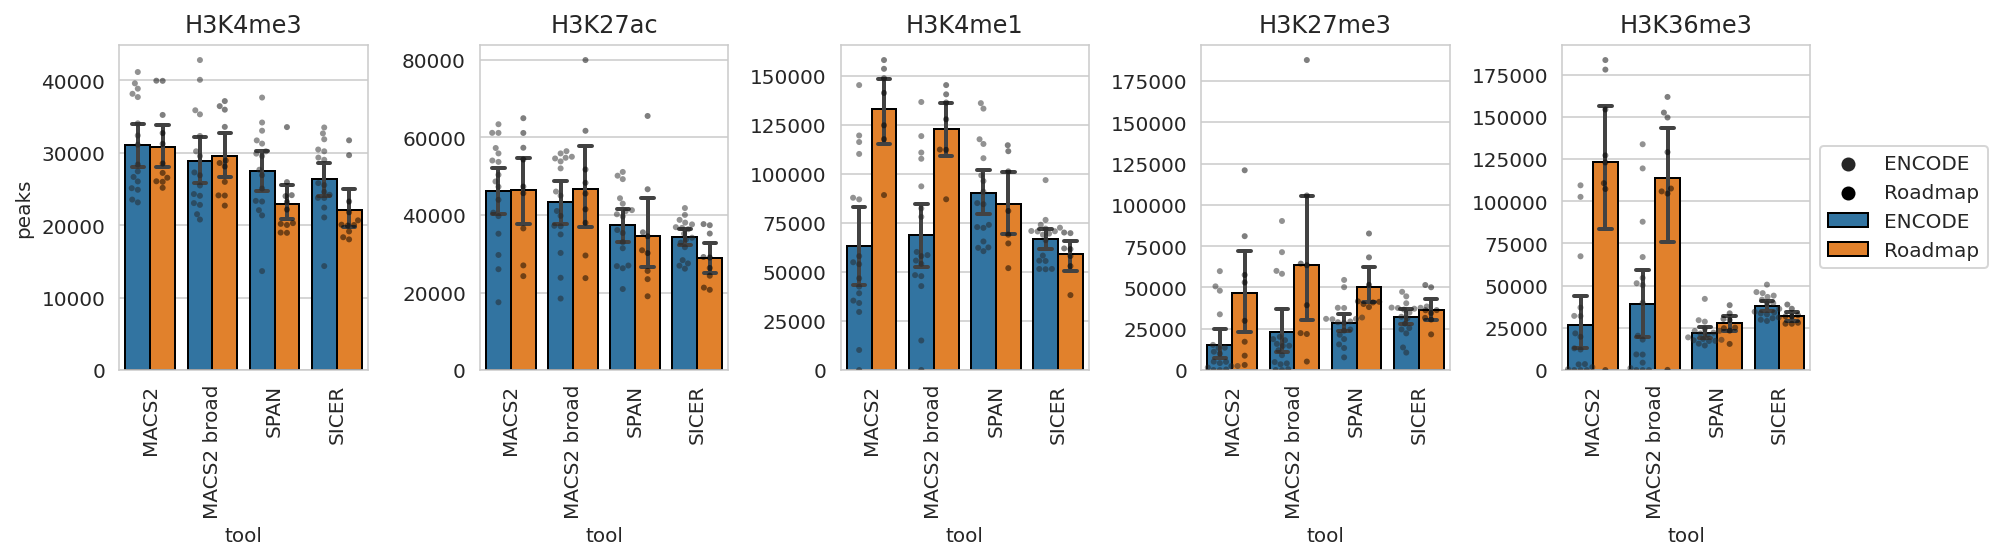

In [664]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

H3K4me3 ENCODE


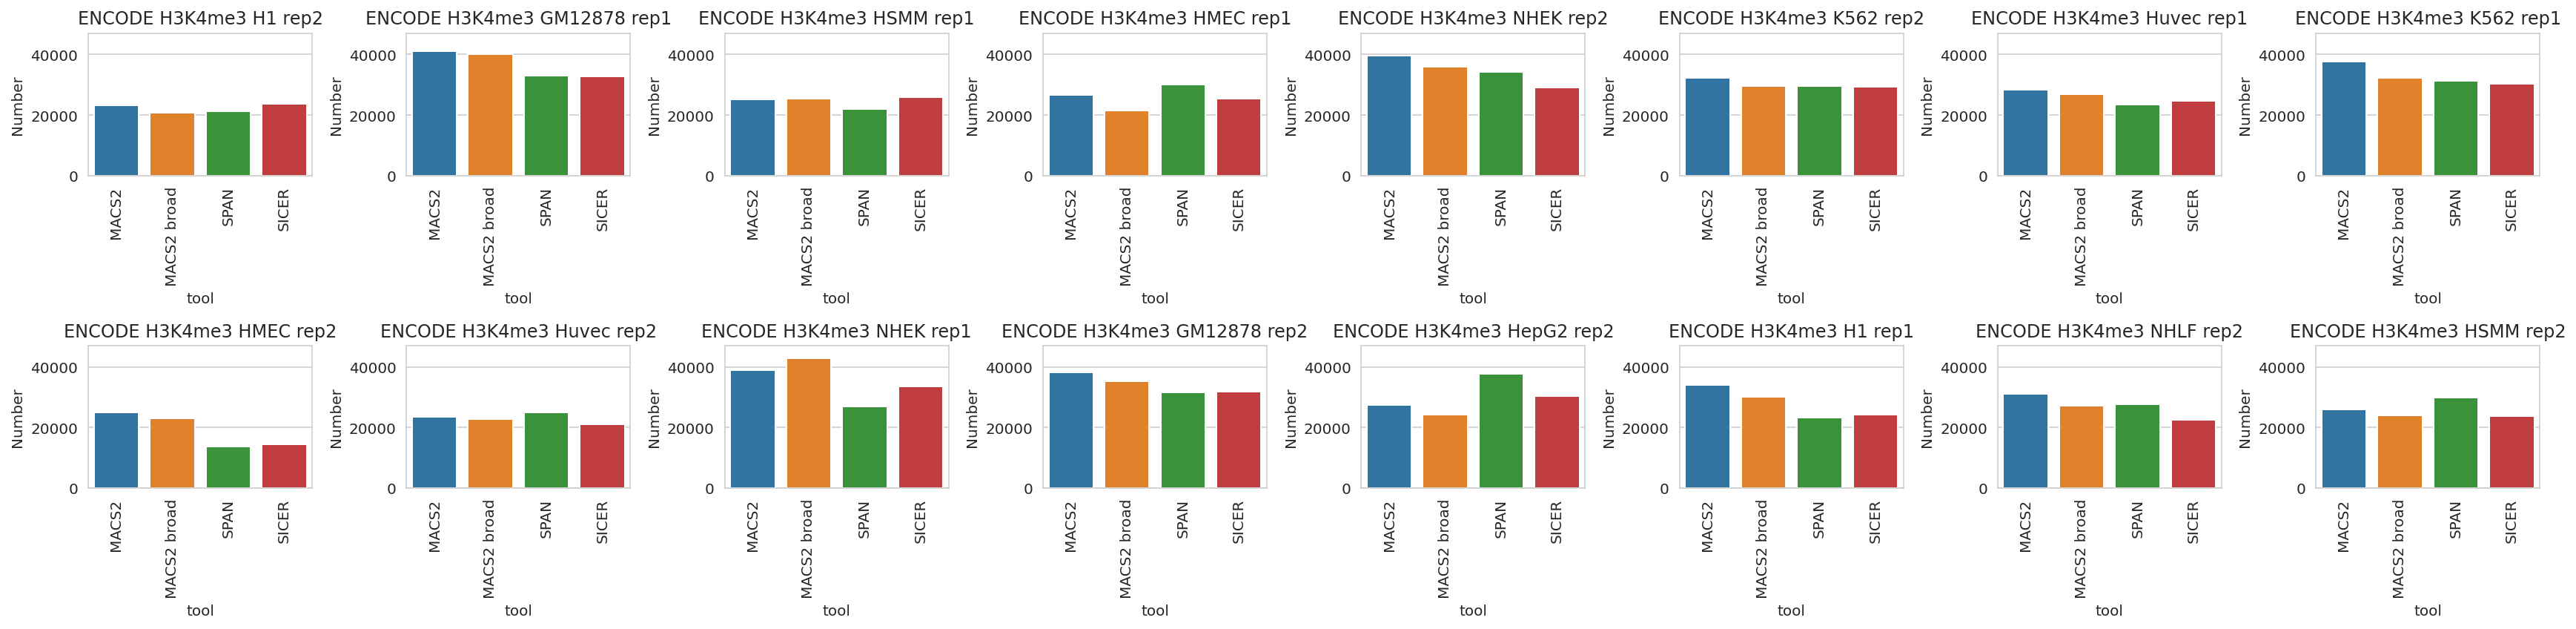

H3K4me3 Roadmap


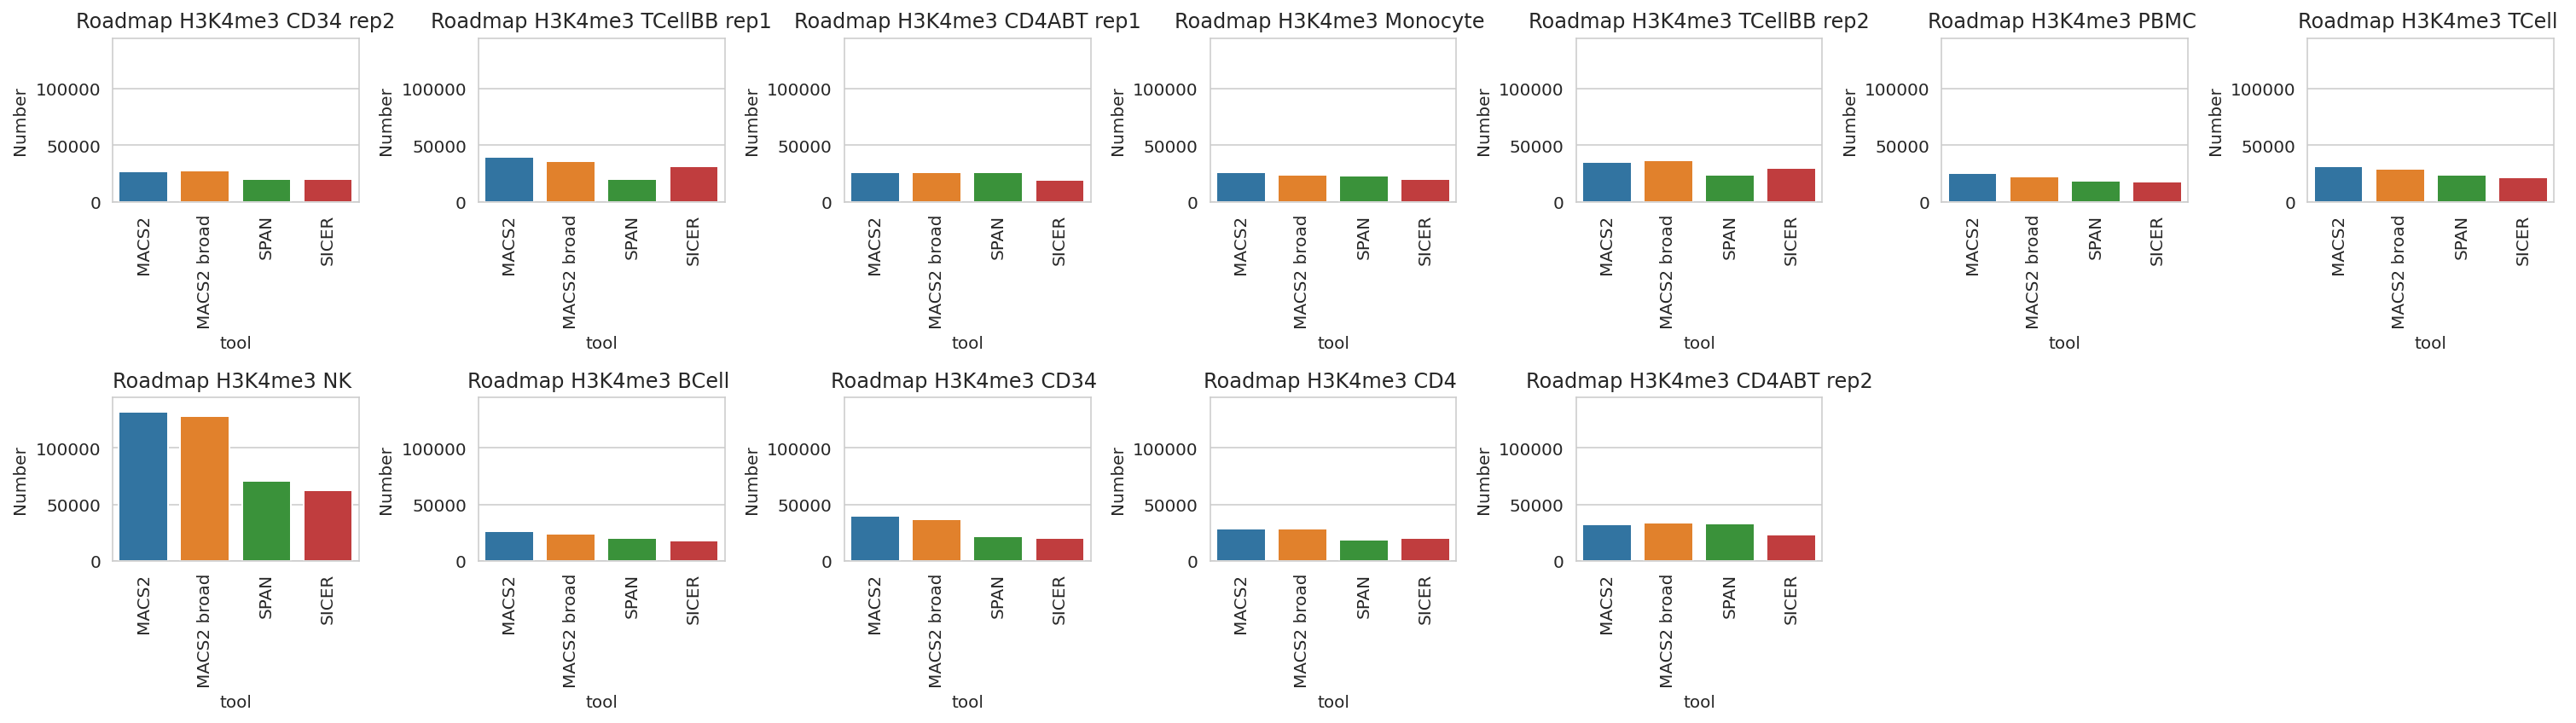

H3K27ac ENCODE


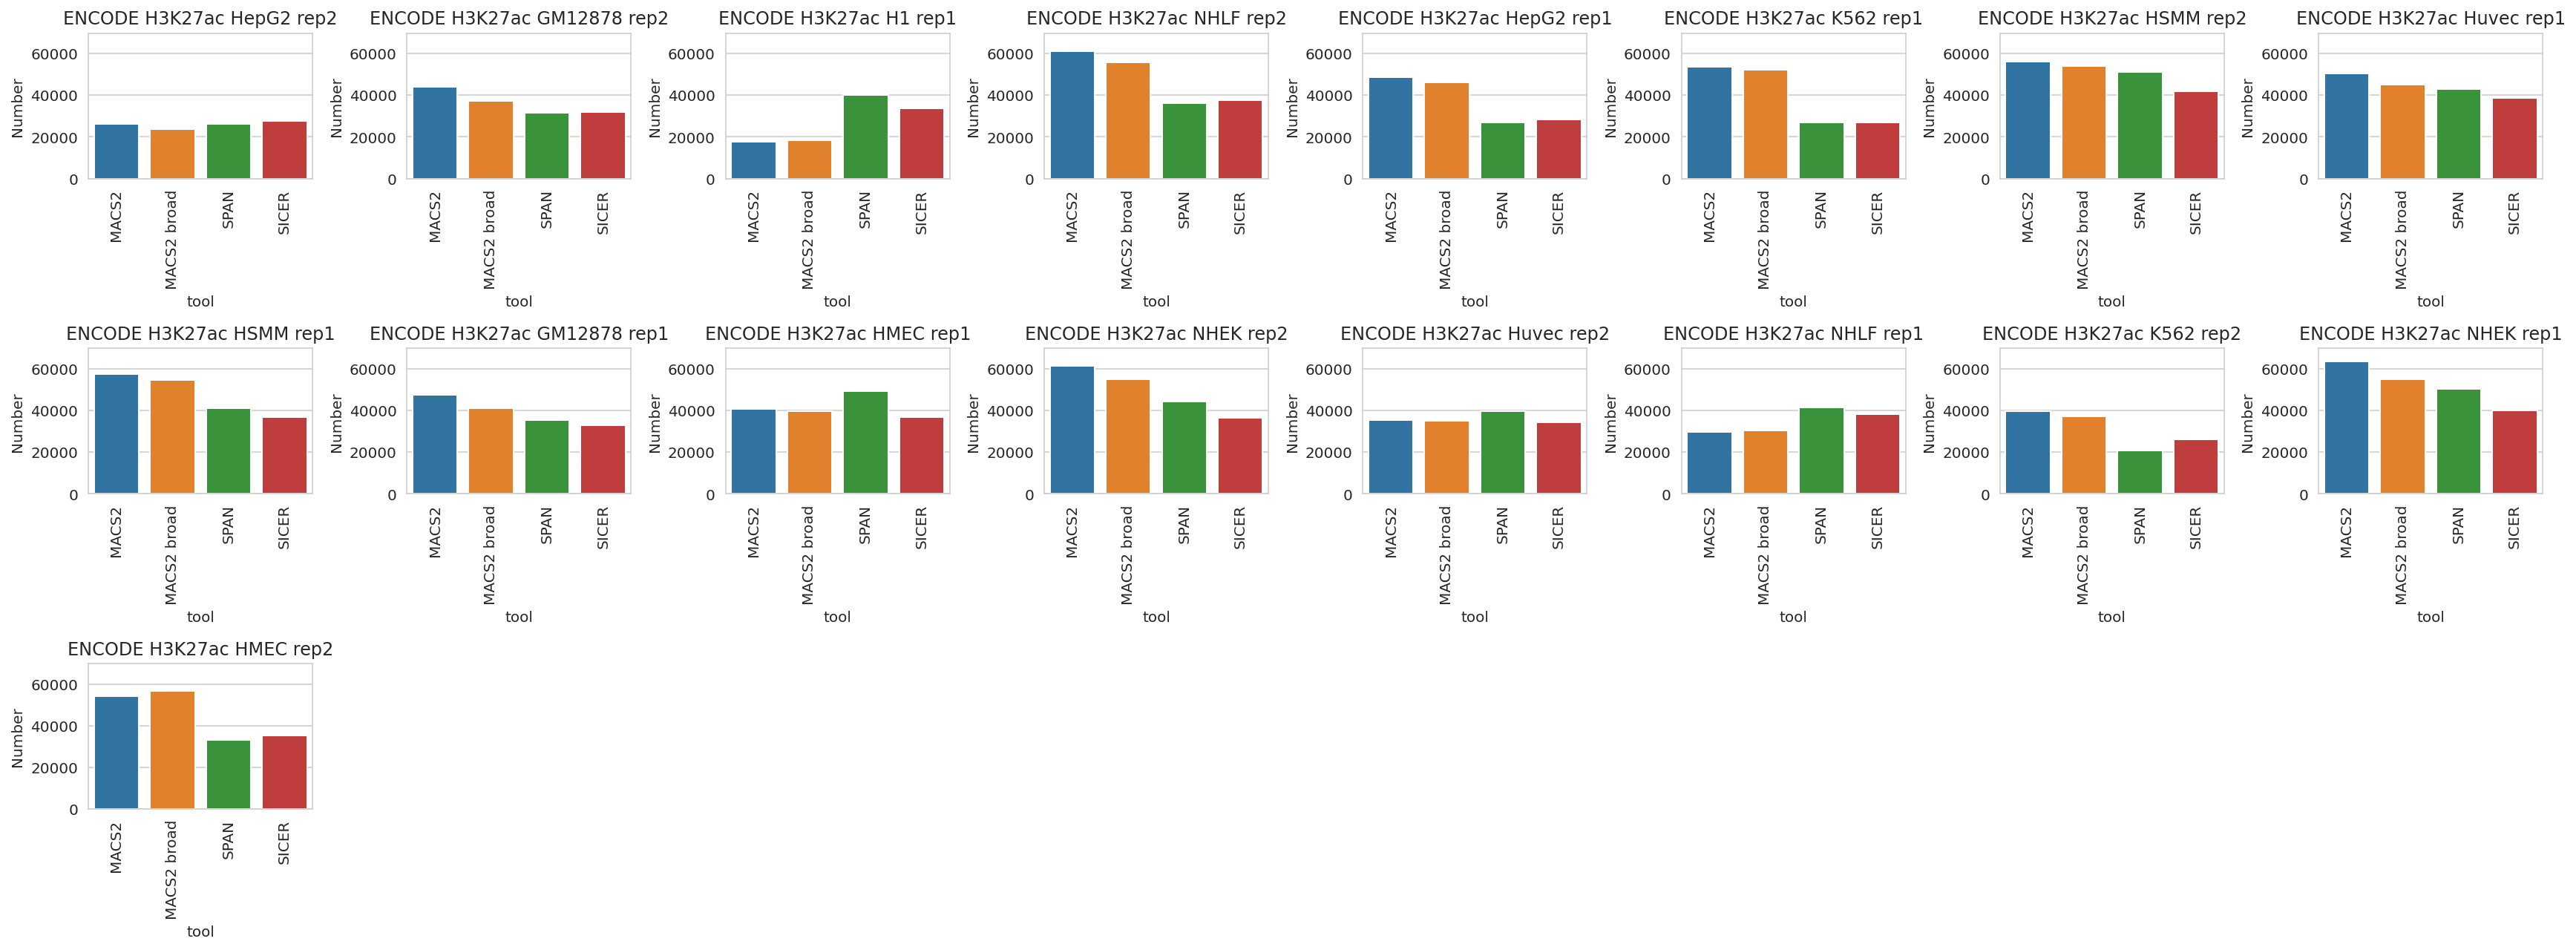

H3K27ac Roadmap


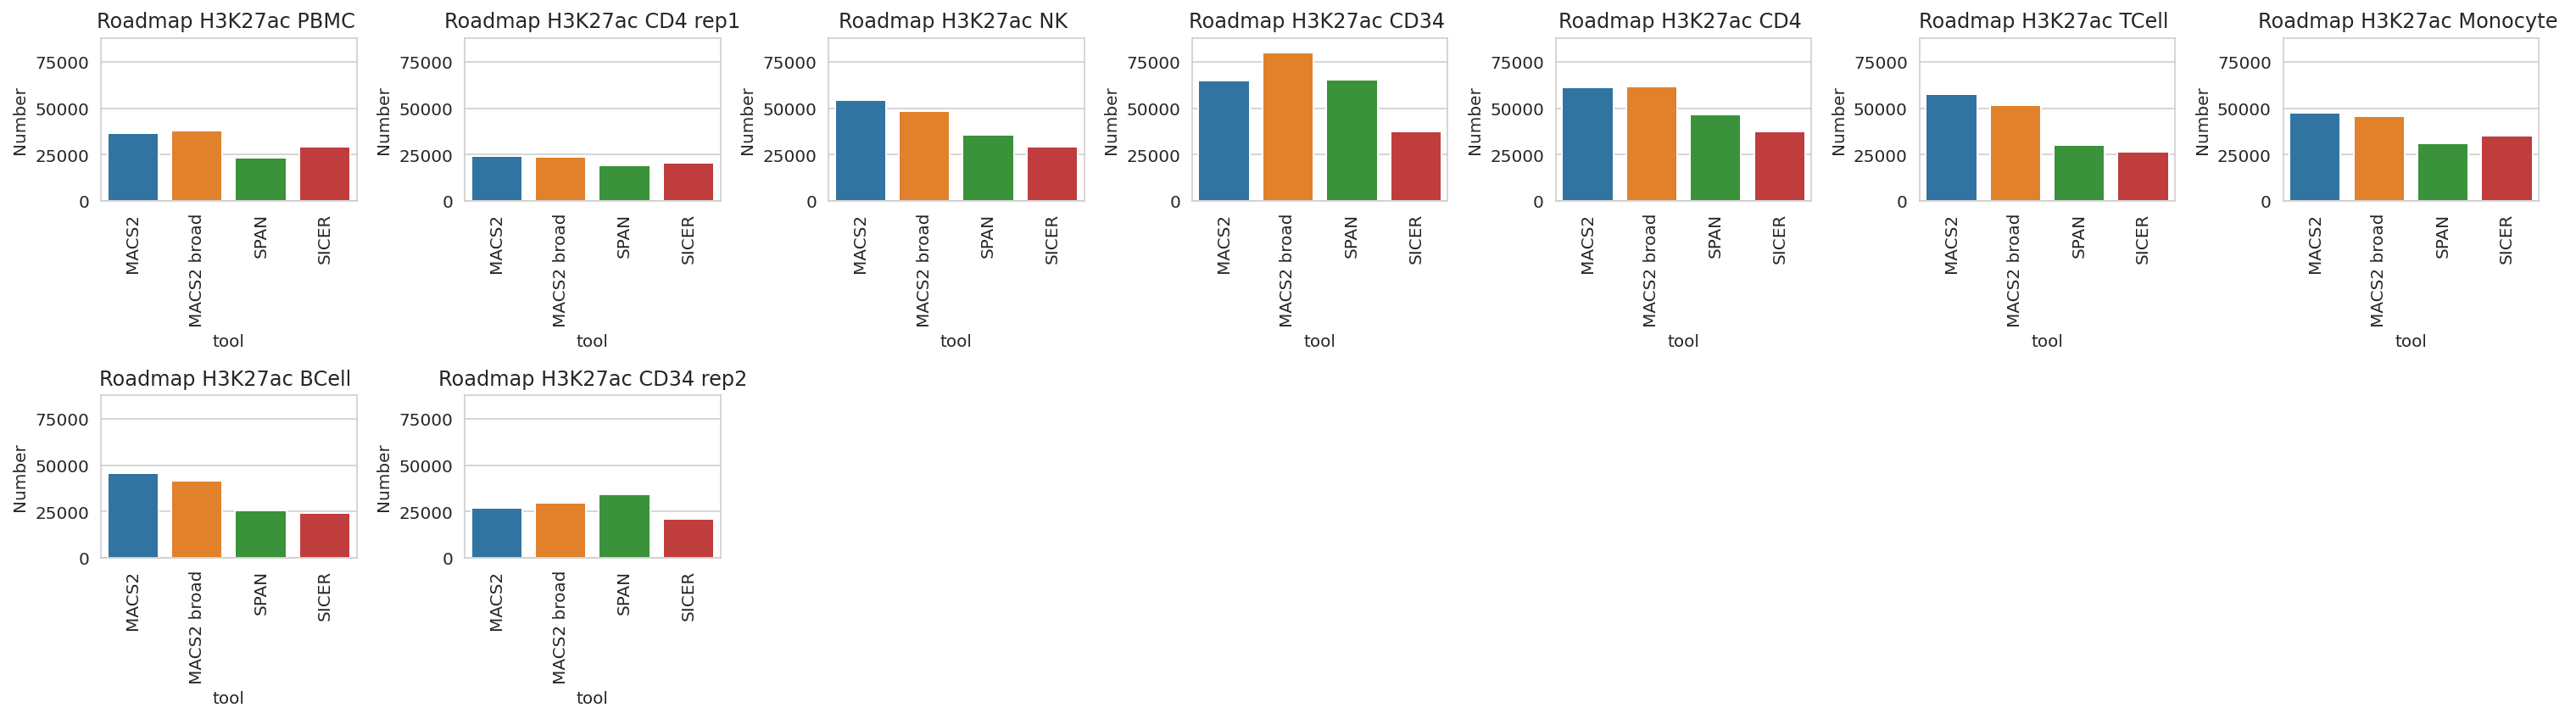

H3K4me1 ENCODE


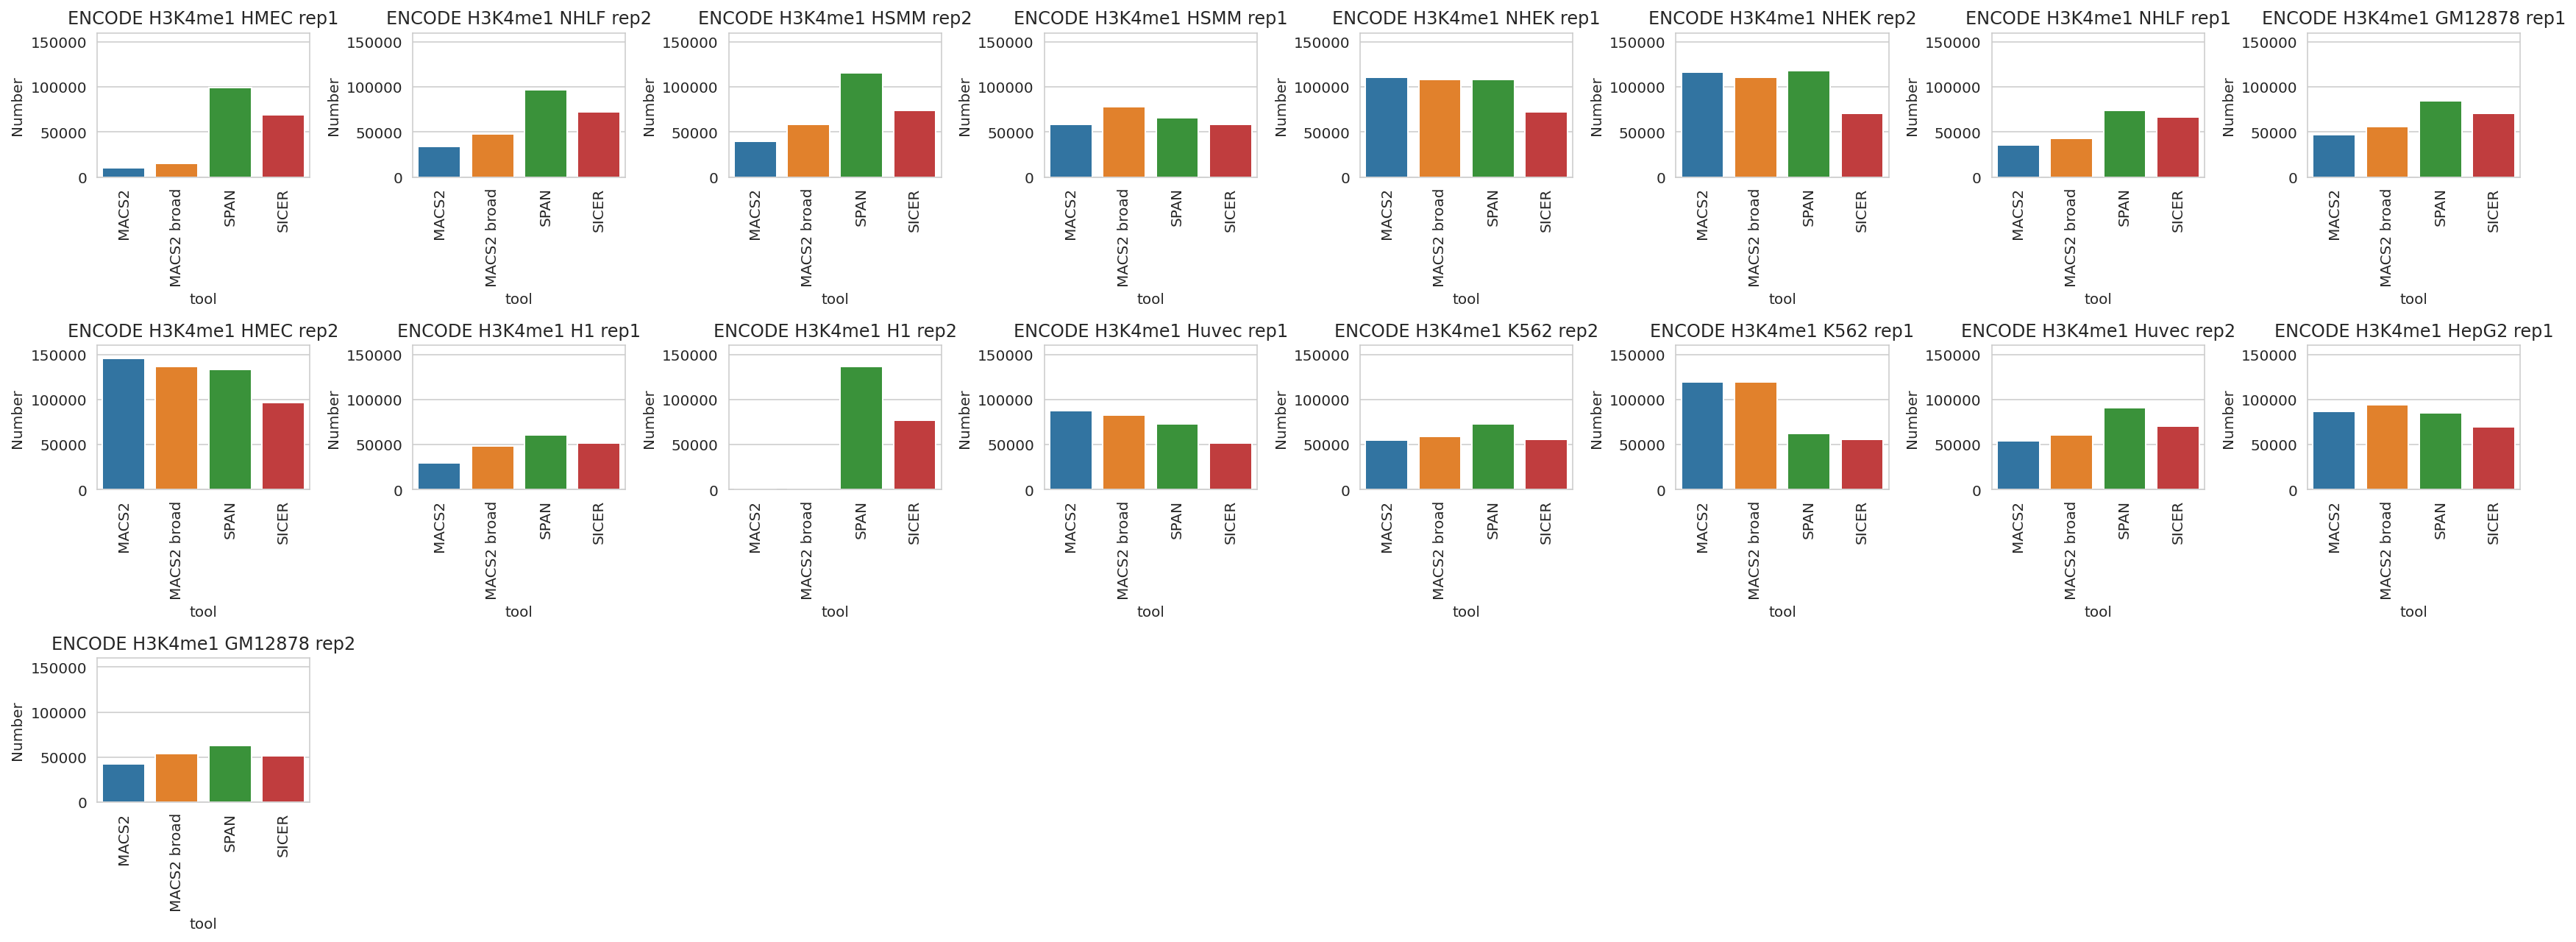

H3K4me1 Roadmap


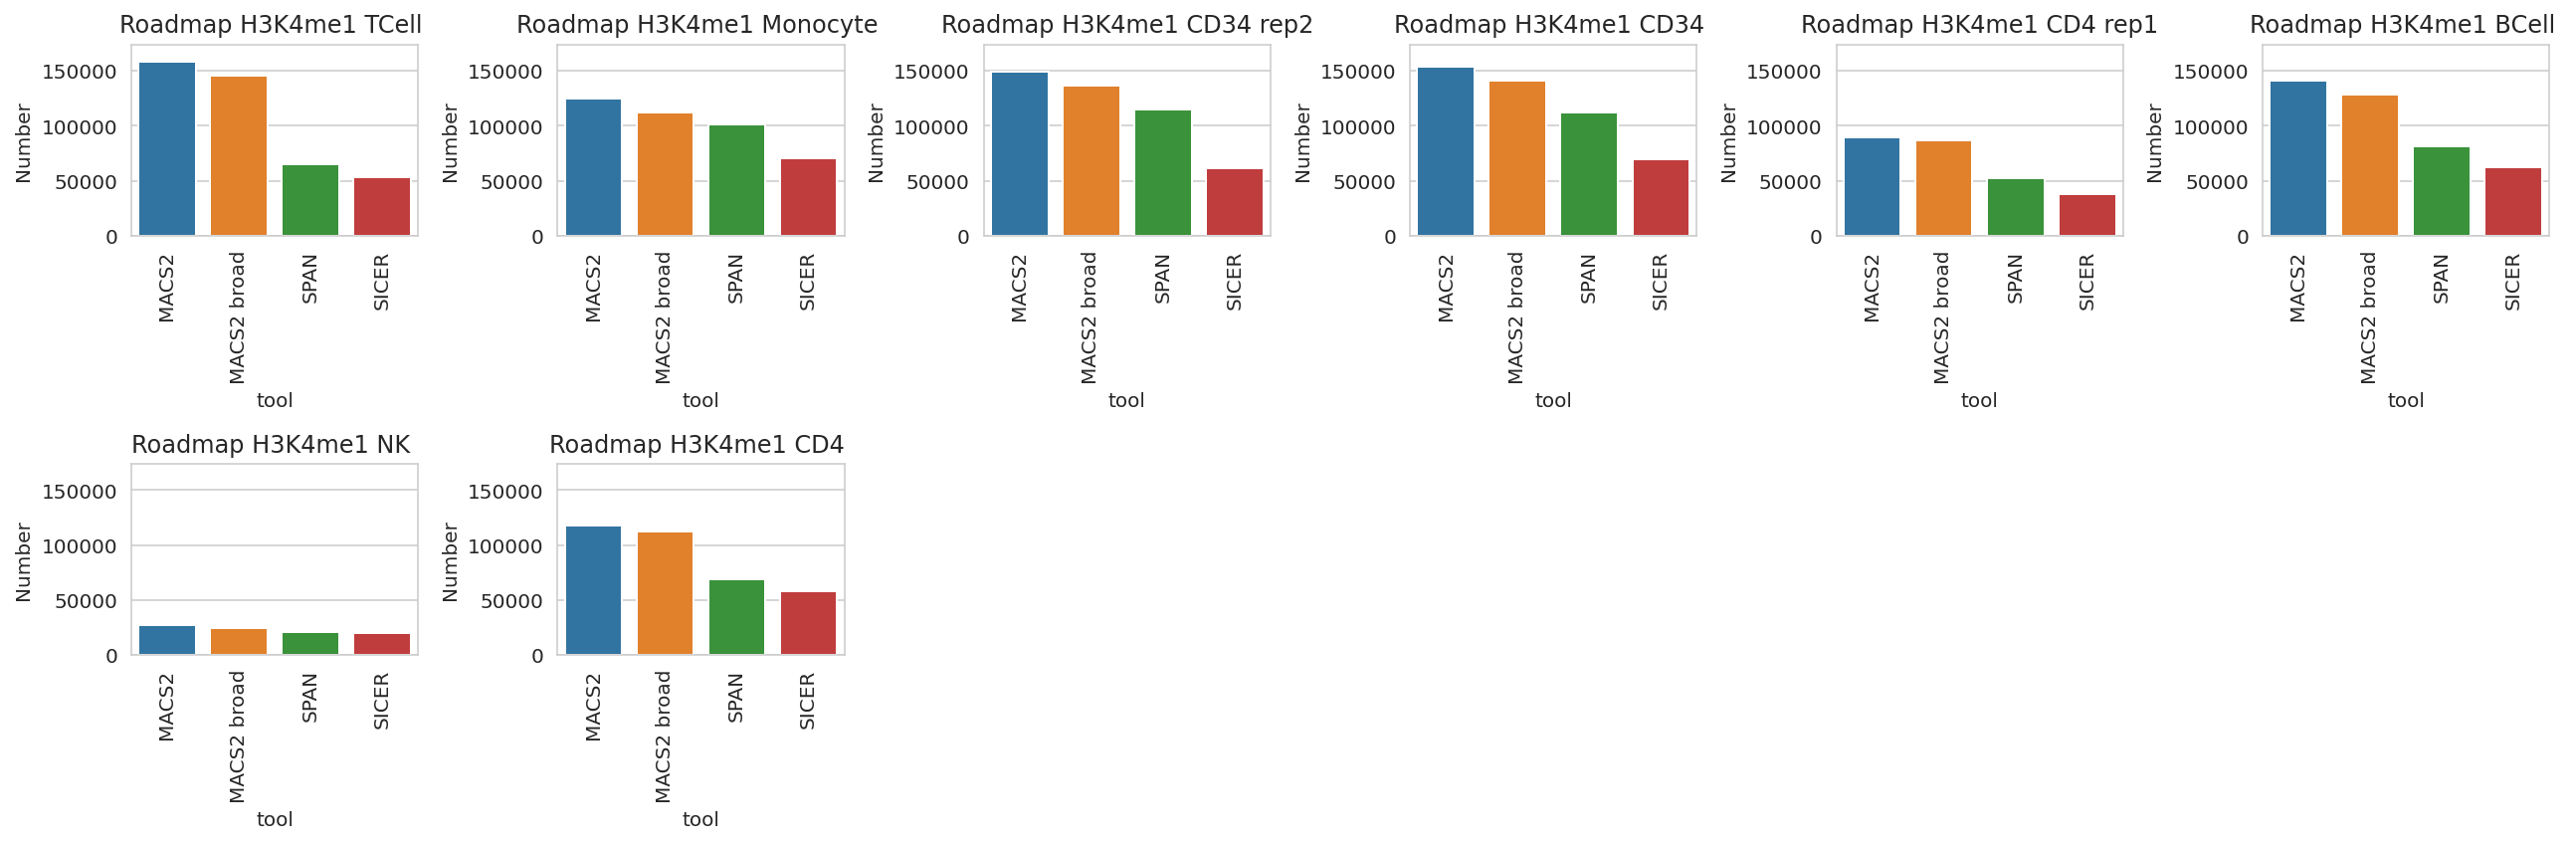

H3K27me3 ENCODE


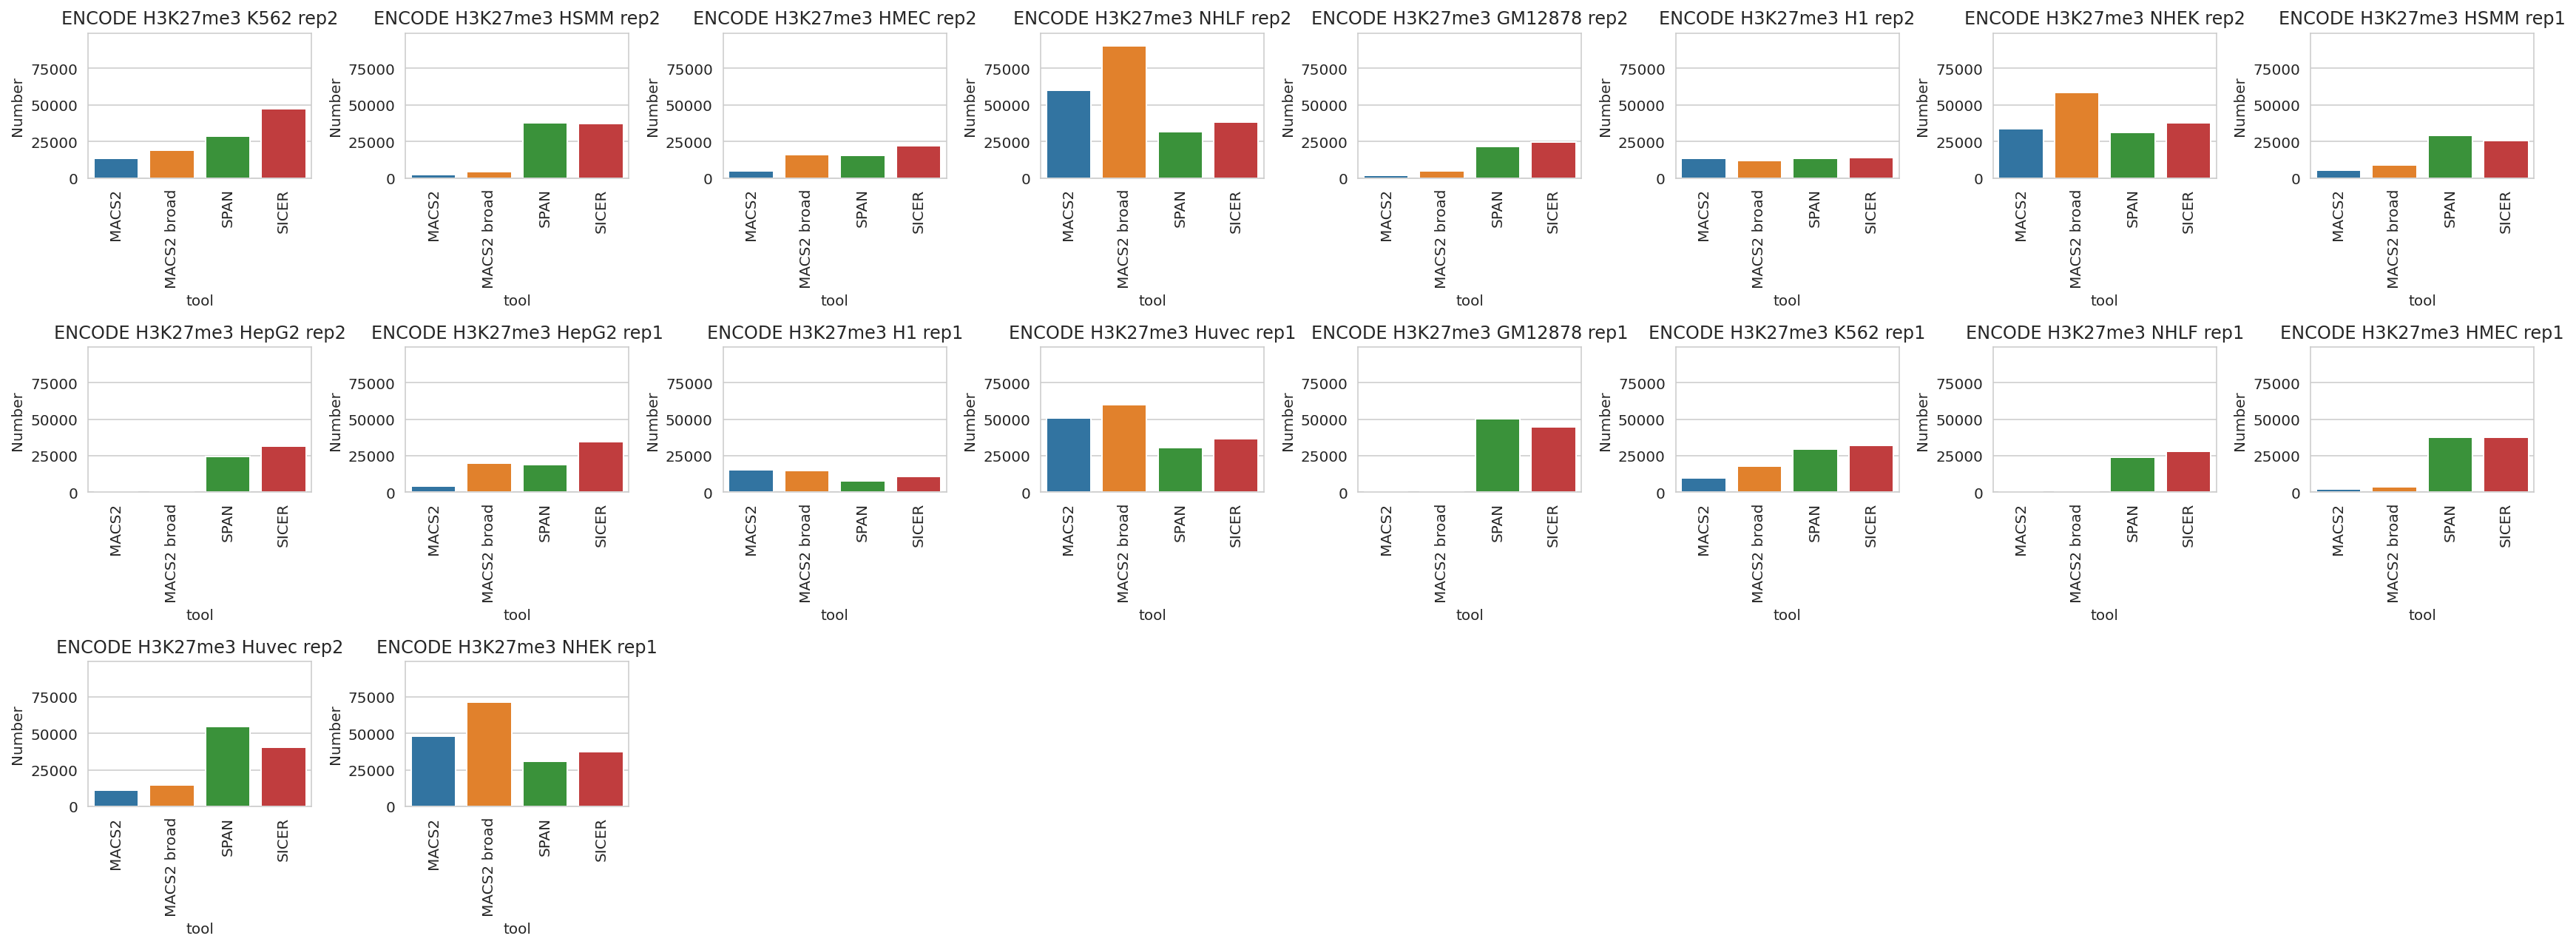

H3K27me3 Roadmap


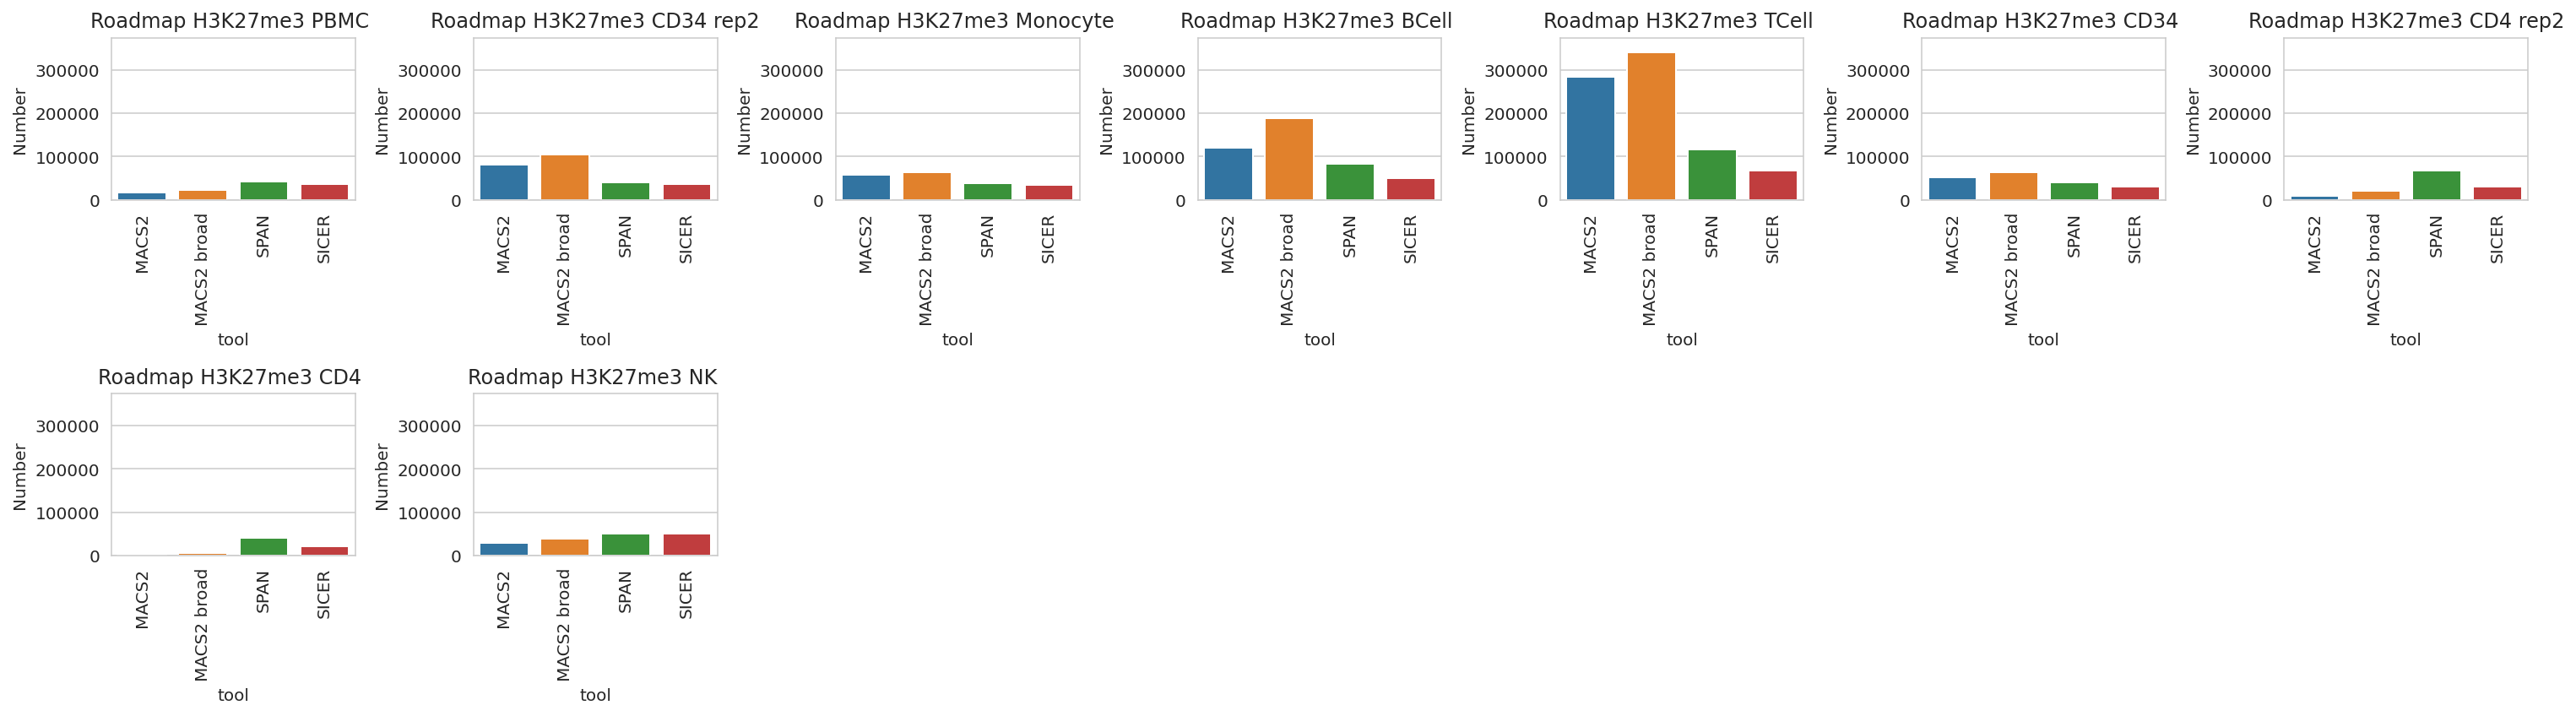

H3K36me3 ENCODE


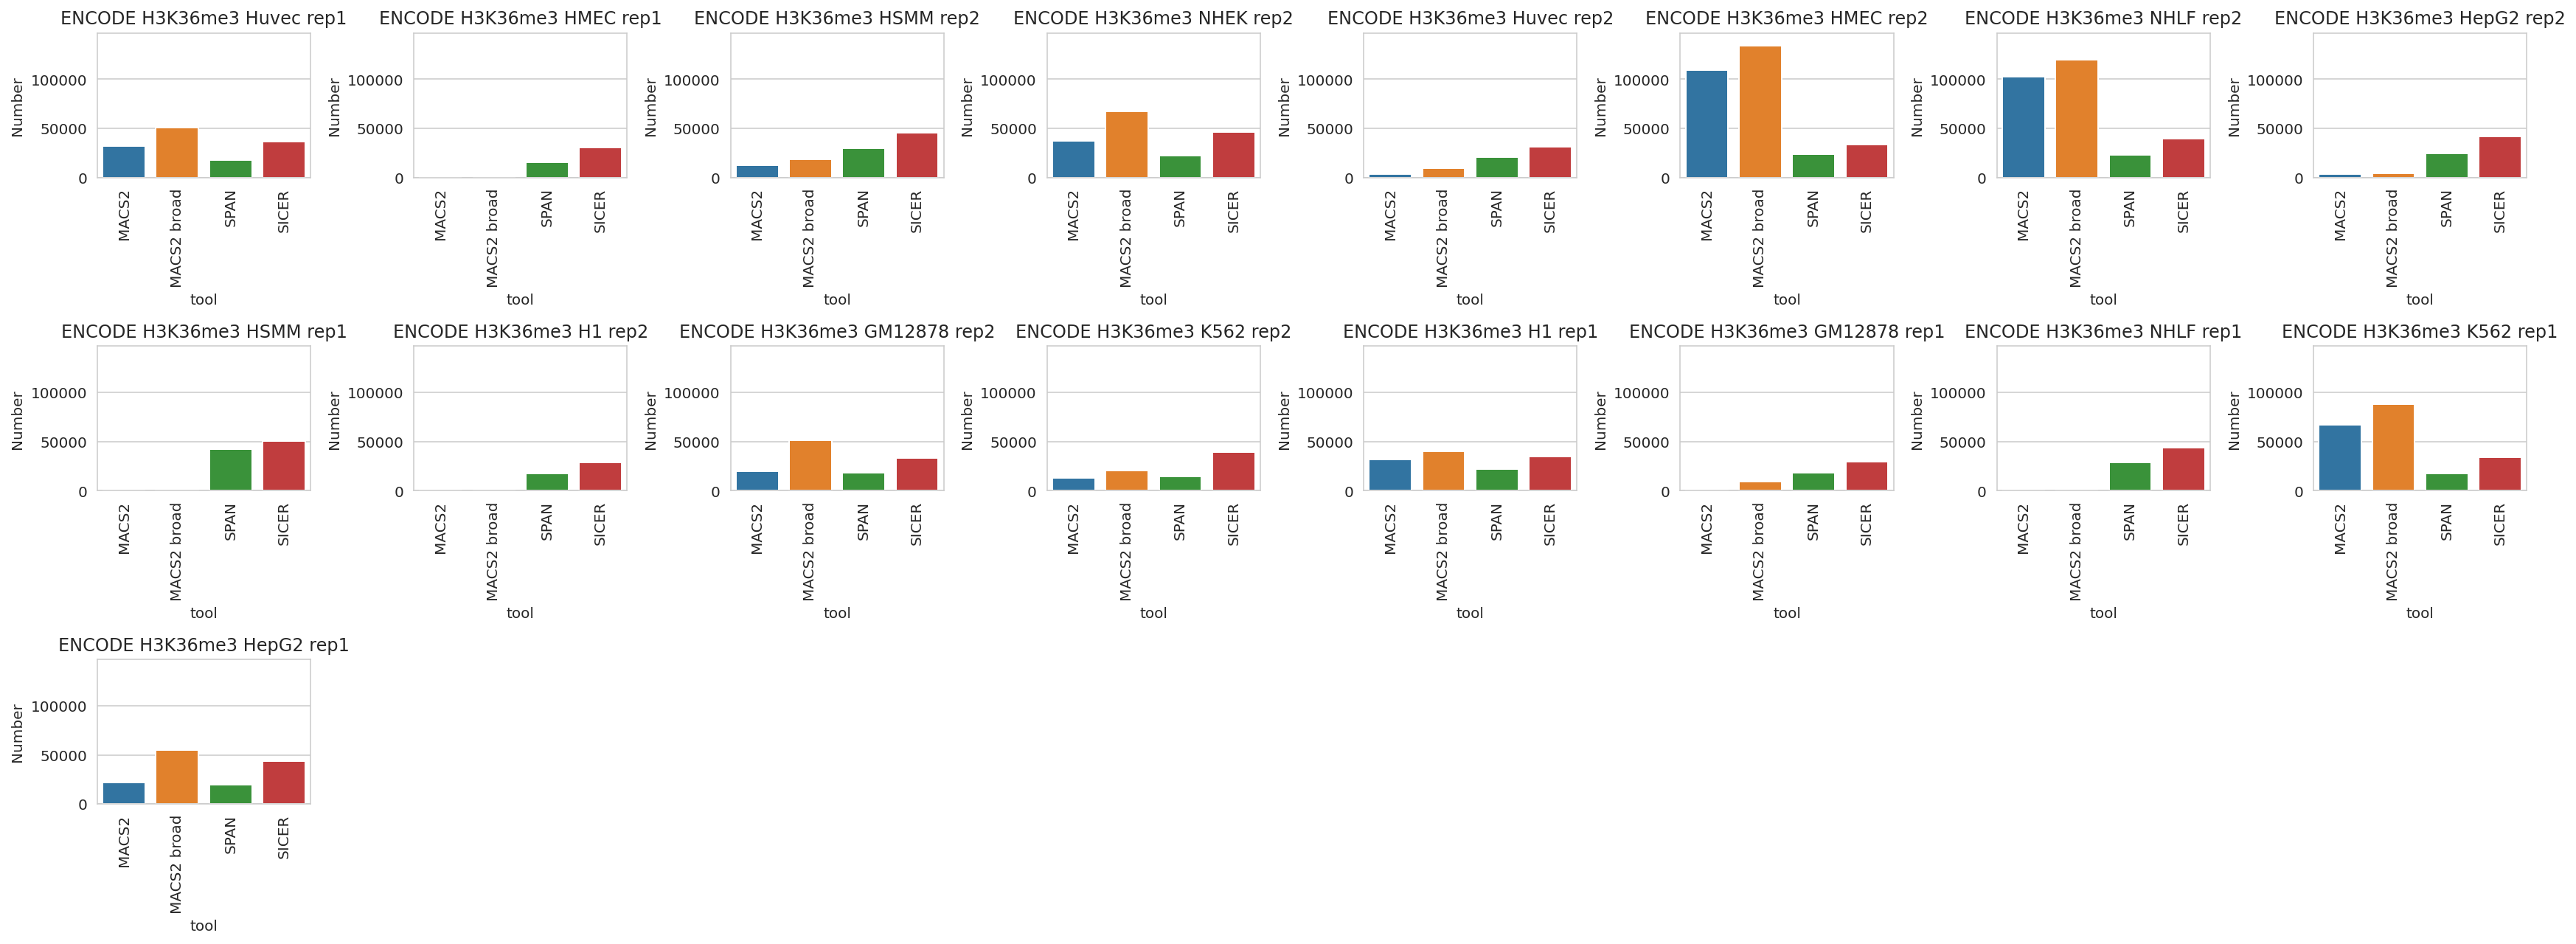

H3K36me3 Roadmap


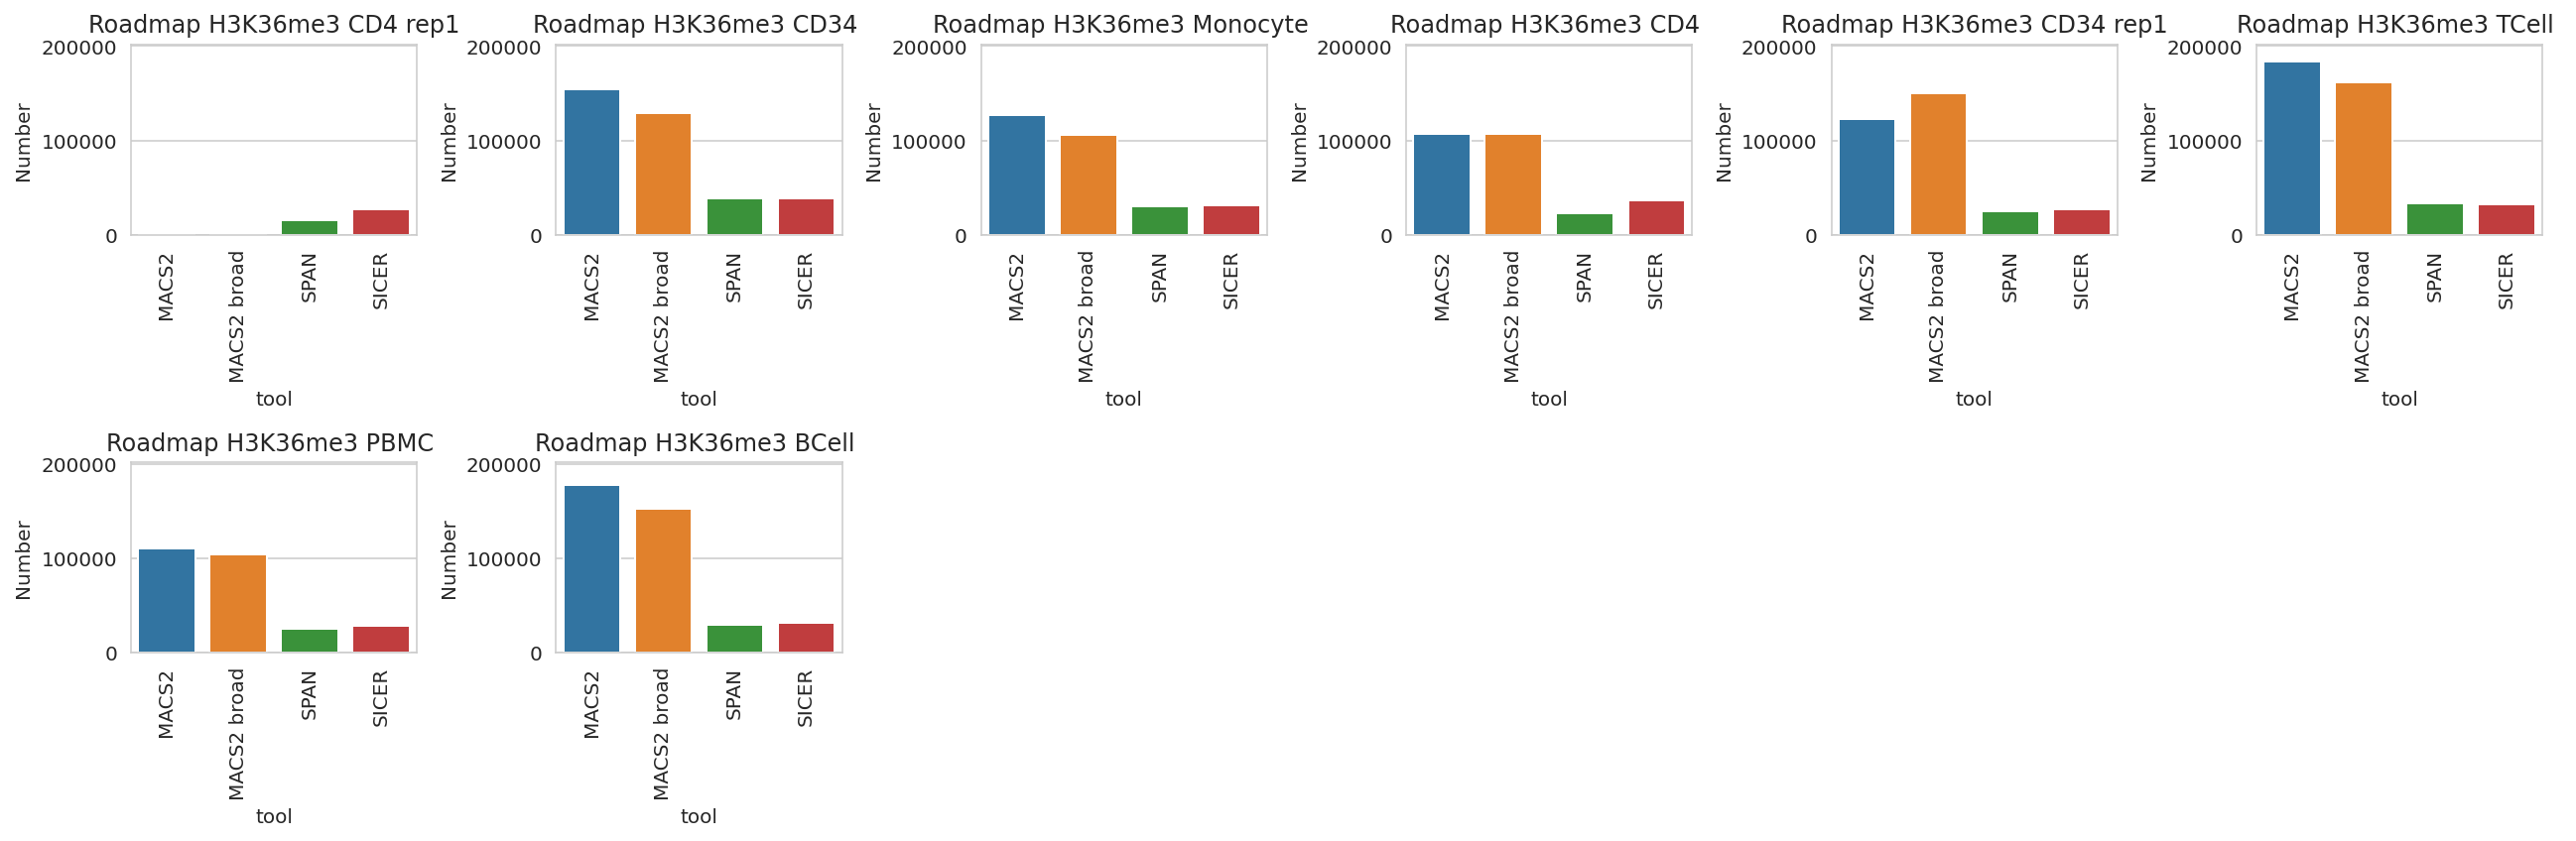

In [12]:
import math
for m, ds in product(MODIFICATIONS, ['ENCODE', 'Roadmap']):
    print(m, ds)
    t = df_peaks[(df_peaks['dataset'] == ds) & (df_peaks['modification'] == m)]
    experiments = [(c, r) for _, (c, r) in t[['cell', 'replicate']].drop_duplicates().iterrows()]
    ncols = int(math.floor(math.sqrt(len(experiments)) + 4))
    nrows = int(math.ceil(len(experiments) / ncols))
    plt.figure(figsize=(3 * ncols, 3 * nrows))
    axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
    for i, (c, r) in enumerate(experiments):
        ax = axs[i]
        ax.title.set_text(f'{ds} {m} {c} {r}')
        g_results = sns.barplot(data=t[(t['cell'] == c) & (t['replicate']==r)],
                            x='tool', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                            )
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_ylabel('Number')
        ax.set_ylim(0, t['peaks'].max() * 1.1)
    plt.tight_layout()
    plt.show()

In [13]:
# Remove outliers
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', '')]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

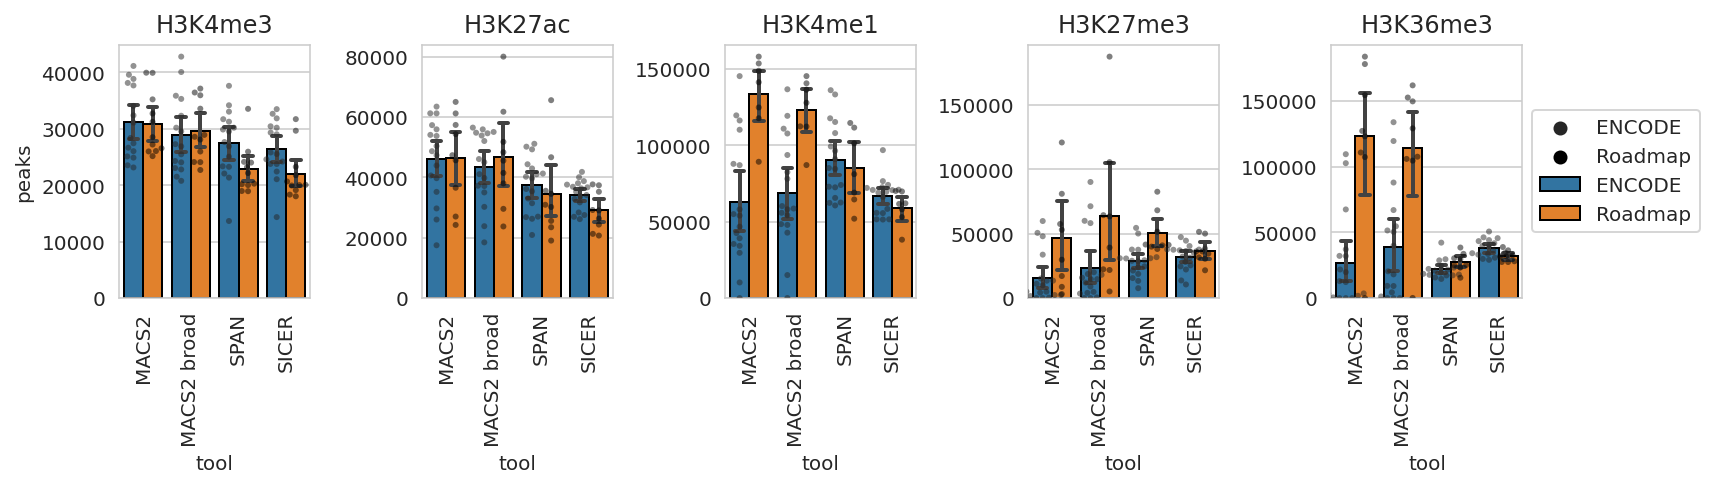

In [14]:
plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) -1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

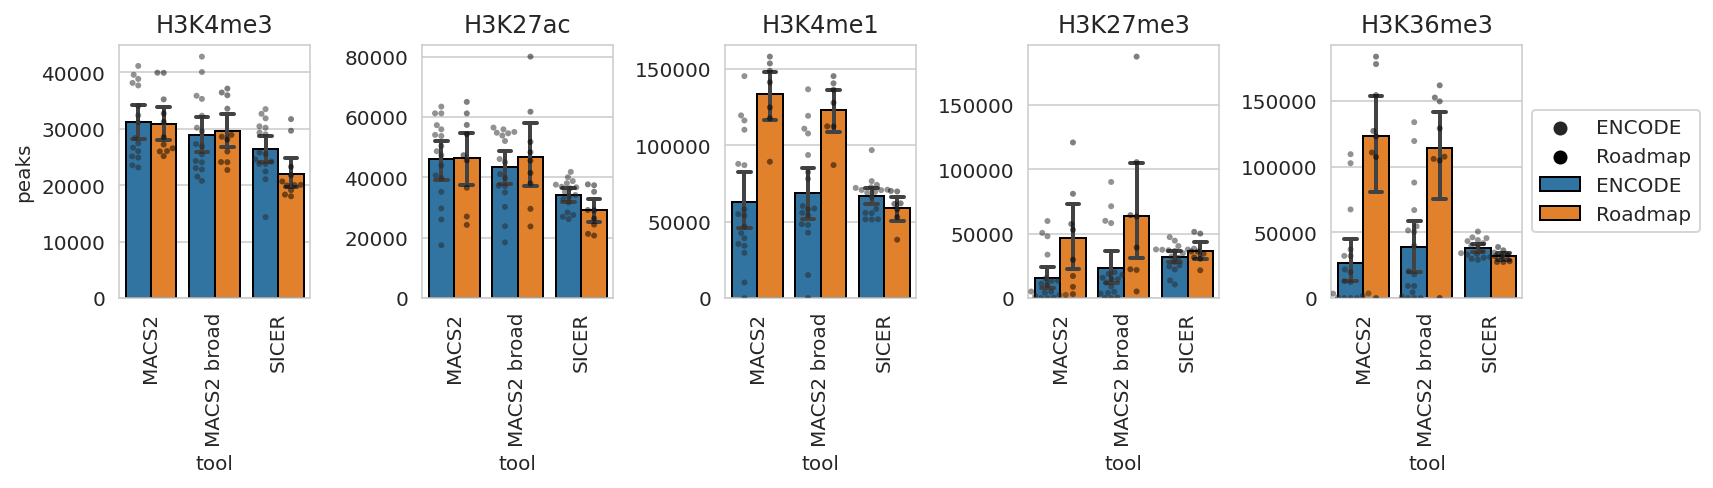

In [15]:
plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SICER'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) -1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [284]:
df_peaks['ds_c_r'] = df_peaks['dataset'] + ' ' + df_peaks['cell'] + ' ' + df_peaks['replicate']
print('H3K4me1 MACS2 broad ENCODE < 60k peaks')
g1 = df_peaks[(df_peaks['modification'] == 'H3K4me1') & 
              (df_peaks['dataset'] == 'ENCODE') & 
              (df_peaks['tool'] == 'MACS2 broad') & 
              (df_peaks['peaks'] < 60_000)].copy()
display(g1)

print('H3K4me1 MACS2 broad ENCODE > 80k peaks')
g2 = df_peaks[(df_peaks['modification'] == 'H3K4me1') &
              (df_peaks['dataset'] == 'ENCODE') &
              (df_peaks['tool'] == 'MACS2 broad') &
              (df_peaks['peaks'] > 80_000)].copy()

display(g2)

g1_ds_c_r = set(g1['ds_c_r'])
g2_ds_c_r = set(g2['ds_c_r'])

H3K4me1 MACS2 broad ENCODE < 60k peaks


file modification     cell  \
108  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  GM12878   
115  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HSMM   
124  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HMEC   
129  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     NHLF   
130  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  GM12878   
142  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     NHLF   
144  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1       H1   
148  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     K562   
161  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1       H1   

    replicate  peaks         tool dataset               ds_c_r  
108      rep1  55876  MACS2 broad  ENCODE  ENCODE GM12878 rep1  
115      rep2  58165  MACS2 broad  ENCODE     ENCODE HSMM rep2  
124      rep1  15099  MACS2 broad  ENCODE     ENCODE HMEC rep1  
129      rep1  42869  MACS2 broad  ENCODE     ENCODE NHLF rep1  
130      rep2  54232  MACS2 broad  ENCODE  ENCODE GM12878 rep2  
142      rep2  47946  MACS2 broad  ENCODE     ENCODE NHLF rep2  
144      rep1  48462  MACS2 broad  ENCODE       ENCODE H1 rep1  
148      rep2  58678  MACS2 broad  ENCODE     ENCODE K562 rep2  
161      rep2     62  MACS2 broad  ENCODE       ENCODE H1 rep2

H3K4me1 MACS2 broad ENCODE > 80k peaks


file modification   cell  \
86   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  Huvec   
93   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   NHEK   
112  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   K562   
119  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   HMEC   
141  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   NHEK   
167  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  HepG2   

    replicate   peaks         tool dataset             ds_c_r  
86       rep1   82501  MACS2 broad  ENCODE  ENCODE Huvec rep1  
93       rep1  107843  MACS2 broad  ENCODE   ENCODE NHEK rep1  
112      rep1  119404  MACS2 broad  ENCODE   ENCODE K562 rep1  
119      rep2  136806  MACS2 broad  ENCODE   ENCODE HMEC rep2  
141      rep2  111005  MACS2 broad  ENCODE   ENCODE NHEK rep2  
167      rep1   93762  MACS2 broad  ENCODE  ENCODE HepG2 rep1

Peaks


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


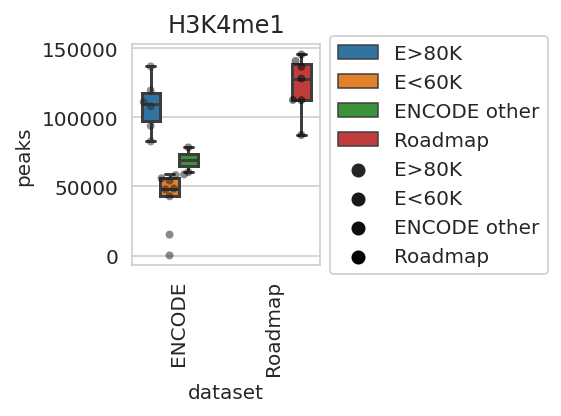

In [332]:
print('Peaks')
plt.figure(figsize=(4, 3))
ax = plt.axes()
t = df_peaks[(df_peaks['modification'] == 'H3K4me1') & (df_peaks['tool'] == 'MACS2 broad')]
sns.boxplot(data=t, x='dataset', y='peaks',
            hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
            'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in t['ds_c_r']] if m == 'H3K4me1' else None,
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='dataset', y='peaks',
              hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
              'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in t['ds_c_r']] if m == 'H3K4me1' else None,
              dodge=True, size=4, palette='dark:black', alpha=0.5,
              ax=ax)

sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
ax.title.set_text(m)
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Lengths

In [244]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    t['footprint'] = sum(lengths)
    t['ds_c_r'] = dataset + ' ' + cell + ' ' + rep
    ts.append(t)
df_lens = pd.concat(ts).reset_index(drop=True)
del ts, t
df_lens.sample(10)

Load lengths


0it [00:00, ?it/s]

length  dataset modification     cell replicate         tool  \
1720301  2199.0   ENCODE      H3K4me1     K562      rep1        SICER   
3624973   426.0  Roadmap      H3K4me1     CD34      rep2  MACS2 broad   
1737834   599.0   ENCODE      H3K27ac       H1      rep1        SICER   
1730068  5199.0   ENCODE     H3K36me3       H1      rep2        SICER   
3824425  1556.0  Roadmap     H3K36me3      CD4            MACS2 broad   
628687    351.0   ENCODE     H3K27me3     K562      rep1        MACS2   
2495623  5926.0   ENCODE     H3K36me3       H1      rep1         SPAN   
4139449  2999.0  Roadmap      H3K4me1     CD34      rep2        SICER   
3019417  6184.0   ENCODE      H3K4me3  GM12878      rep2         SPAN   
4023630  5599.0  Roadmap      H3K27ac      CD4      rep1        SICER   

         footprint               ds_c_r  
1720301  244446561     ENCODE K562 rep1  
3624973  142229505    Roadmap CD34 rep2  
1737834   92199504       ENCODE H1 rep1  
1730068  105359107       ENCODE H1 rep2  
3824425  101133367         Roadmap CD4   
628687     3897646     ENCODE K562 rep1  
2495623  174020347       ENCODE H1 rep1  
4139449  234748088    Roadmap CD34 rep2  
3019417   85506006  ENCODE GM12878 rep2  
4023630   59693688     Roadmap CD4 rep1

In [262]:
# for ds in ['ENCODE', 'Roadmap']:
#     print(ds)
#     plt.figure(figsize=(18, 3))    
#     axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
#     for i, m in enumerate(MODIFICATIONS):
#         ax = axs[i]
#         g_results = sns.histplot(data=df_lens[(df_lens['dataset'] == ds) & (df_lens['modification'] == m)], 
#                                  x='length', hue='tool', ax=ax,
#                                  stat='density', common_bins=False, common_norm=False,
#                                  bins=50, kde=True, log_scale=True, alpha=0.2,
#                                  palette=TOOLS_PALETTE,
#                                  hue_order=TOOLS)
#         g_results.set(xscale='log')
#         g_results.set_ylim(0, 3)
#         g_results.set_xlim(1e2, 7e4)
#         ax.title.set_text(m)
#         if i < len(axs) - 1:
#             ax.legend().set_visible(False)
#         else:
#             sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.show()    
#     

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


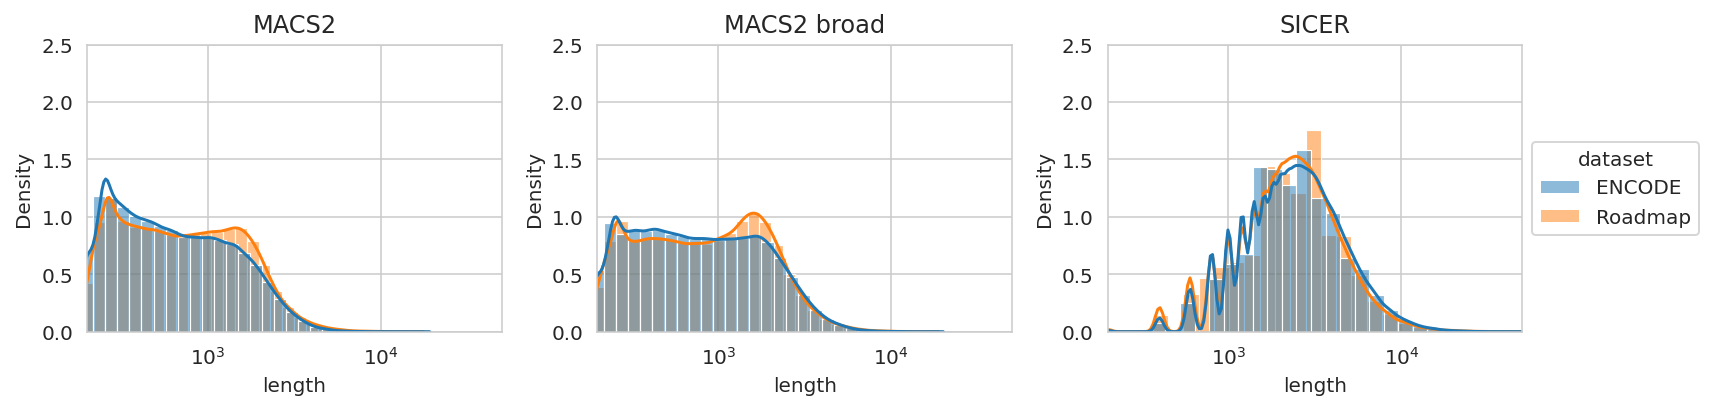

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


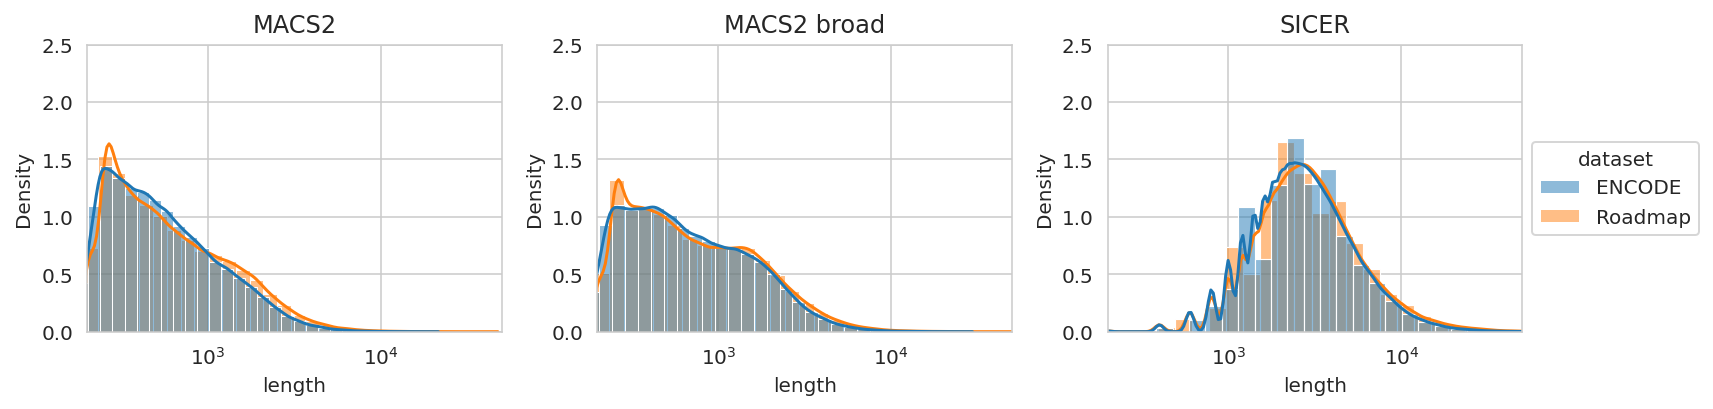

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


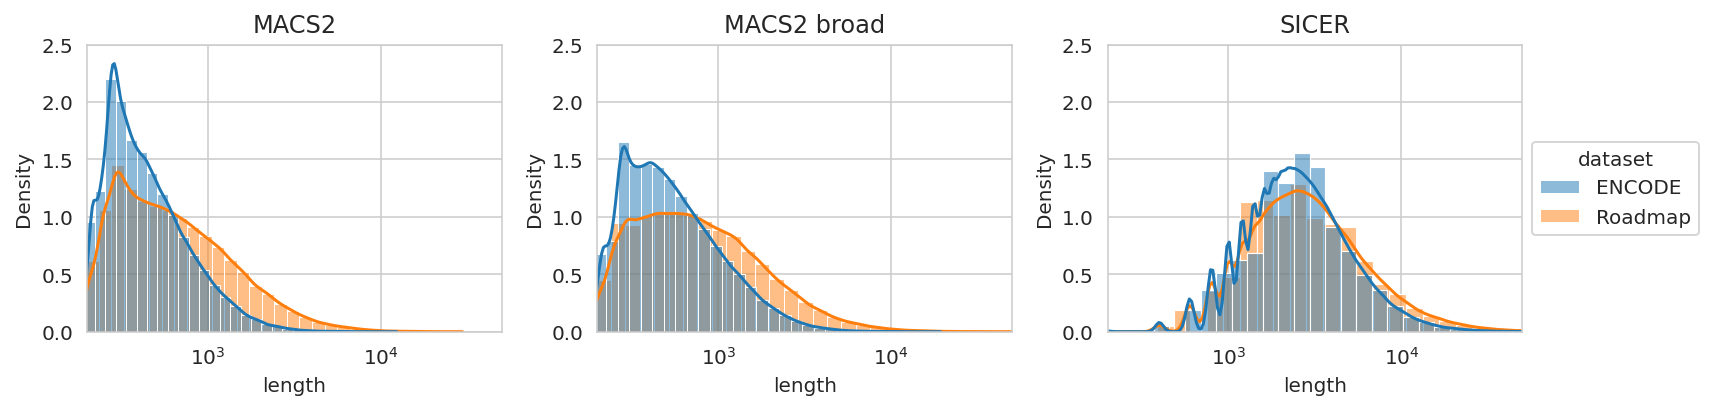

H3K27me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


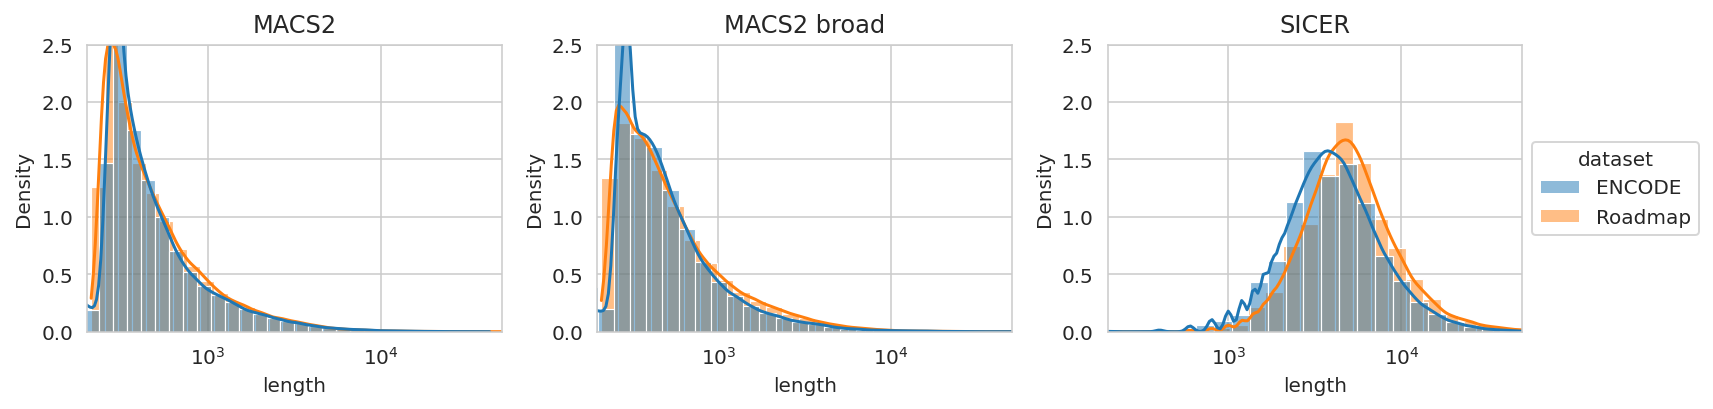

H3K36me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


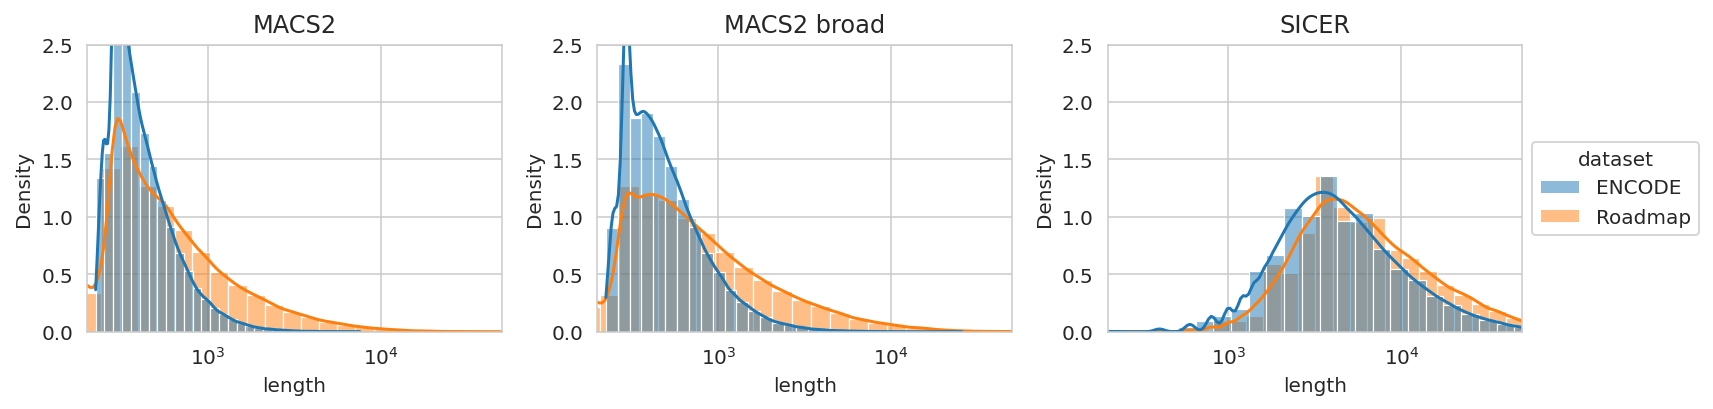

In [18]:
for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=df_lens[(df_lens['modification'] == m) & (df_lens['tool'] == tool)],
                                 x='length', hue='dataset', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 # palette=TOOLS_PALETTE,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 5e4)
        ax.title.set_text(f'{tool}')
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K36me3


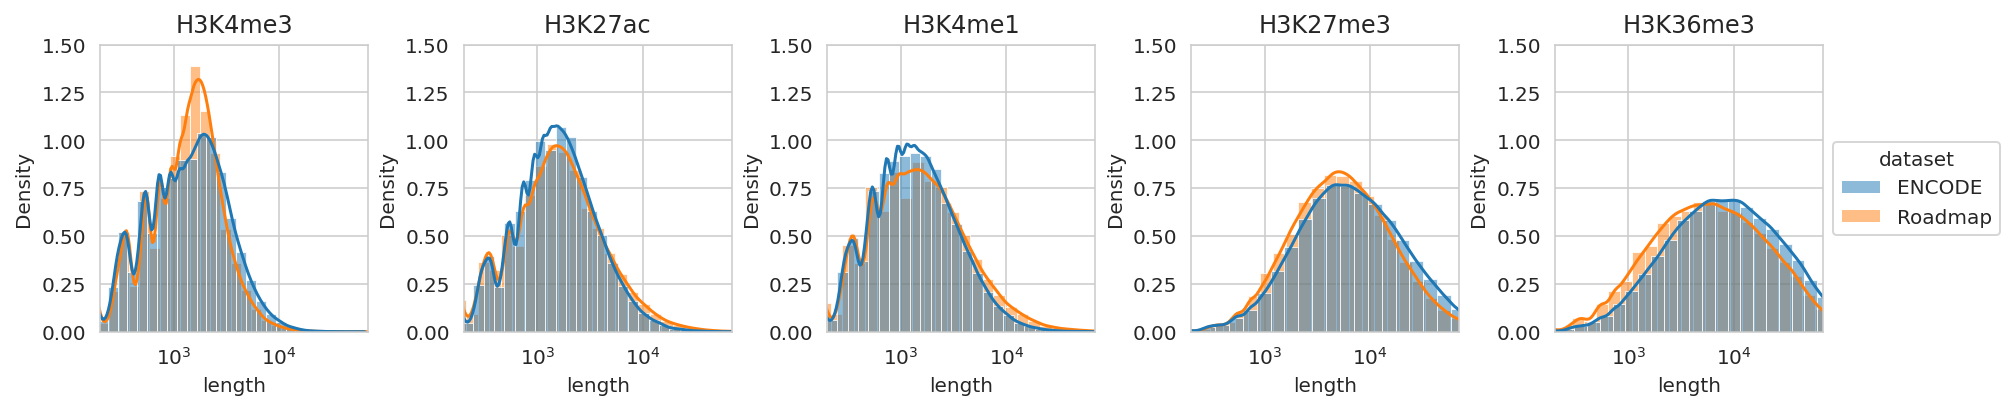

In [19]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=df_lens[(df_lens['modification'] == m) & (df_lens['tool'] == 'SPAN')],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # palette=TOOLS_PALETTE,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 1.5)
    g_results.set_xlim(200, 7e4)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

In [241]:
# df_lens['cell_rep'] = df_lens['cell'] + ' ' + df_lens['replicate']
# 
# for m in MODIFICATIONS:
#     print(m)
#     plt.figure(figsize=(24, 12))
#     t = list(df_lens[df_lens['modification'] == m].groupby(['dataset', 'cell_rep']))
#     plots = len(t)
#     ncols = int(math.ceil(math.sqrt(plots)))
#     nrows = int(math.ceil(plots / ncols))
#     axs = [plt.subplot(nrows, ncols, i + 1) for i in range(plots)]
# 
#     for i, ((ds, cellrep), dt) in enumerate(t):
#         ax = axs[i]
#         sns.histplot(data=dt,
#                      x='length', hue='tool', 
#                      stat='density', common_bins=False, common_norm=False,
#                      bins=30, kde=True, log_scale=True, alpha=0.5,
#                      palette=TOOLS_PALETTE,
#                      ax=ax)
#         
#         ax.set_title(f'{ds} {cellrep}')
#         ax.set(xscale='log')
#         ax.set_ylim(0, 2.5)
#         ax.set_xlim(200, 7e4)
#         if (i + 1) == plots:
#             sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#         else:
#             ax.legend().set_visible(False)
#         if i % ncols != 0:
#             ax.set_ylabel(None)
#         if i < ncols:
#             # ax.set_xticks([], minor=False)
#             # ax.set_xticklabels([])
#             ax.set_xlabel(None)
#     plt.tight_layout()
#     plt.show()

## Average length

In [576]:
df_lens_aggr = df_lens[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index().drop_duplicates()
df_lens_aggr['ds_c_r'] = df_lens_aggr['dataset'] + ' ' + df_lens_aggr['cell'] + ' ' + df_lens_aggr['replicate']
df_lens_aggr.sample(3)

dataset modification     cell replicate   tool      length   footprint  \
68  ENCODE     H3K27me3  GM12878      rep1  MACS2  346.935484     10755.0   
0   ENCODE      H3K27ac  GM12878      rep1  MACS2  892.584500  41890163.0   
92  ENCODE     H3K27me3     HSMM      rep1  MACS2  330.969177   1696548.0   

                 ds_c_r  
68  ENCODE GM12878 rep1  
0   ENCODE GM12878 rep1  
92     ENCODE HSMM rep1

H3K4me3
H3K27ac


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K4me1


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K27me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K36me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


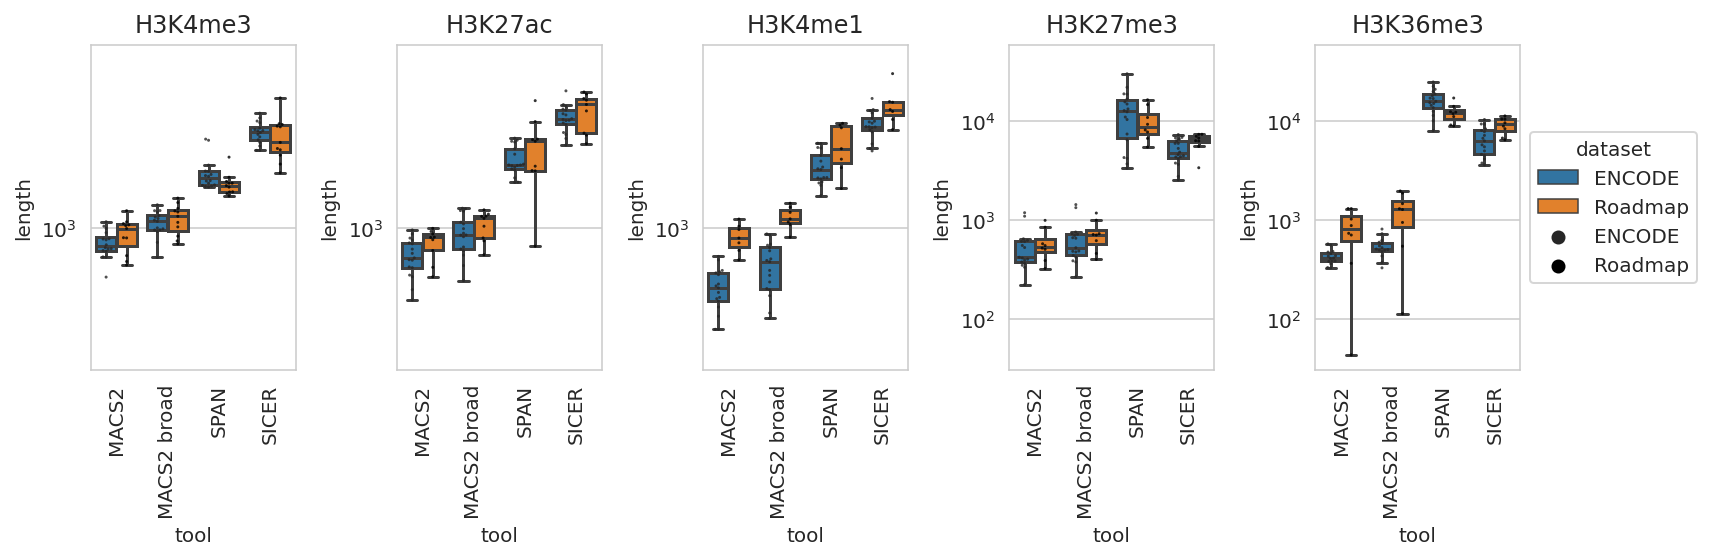

In [577]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    t = df_lens_aggr[df_lens_aggr['modification'] == m].copy()
    sns.boxplot(data=t, x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=t, x='tool', y='length', hue='dataset',
                  dodge=True, size=1.5, palette='dark:black', alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN','SICER'],
                  ax=ax)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K27me3', 'H3K36me3']:
        ax.set_ylim(bottom=200, top=8e3)
    else:
        ax.set_ylim(bottom=30, top=6e4)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K4me1
H3K27me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K36me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


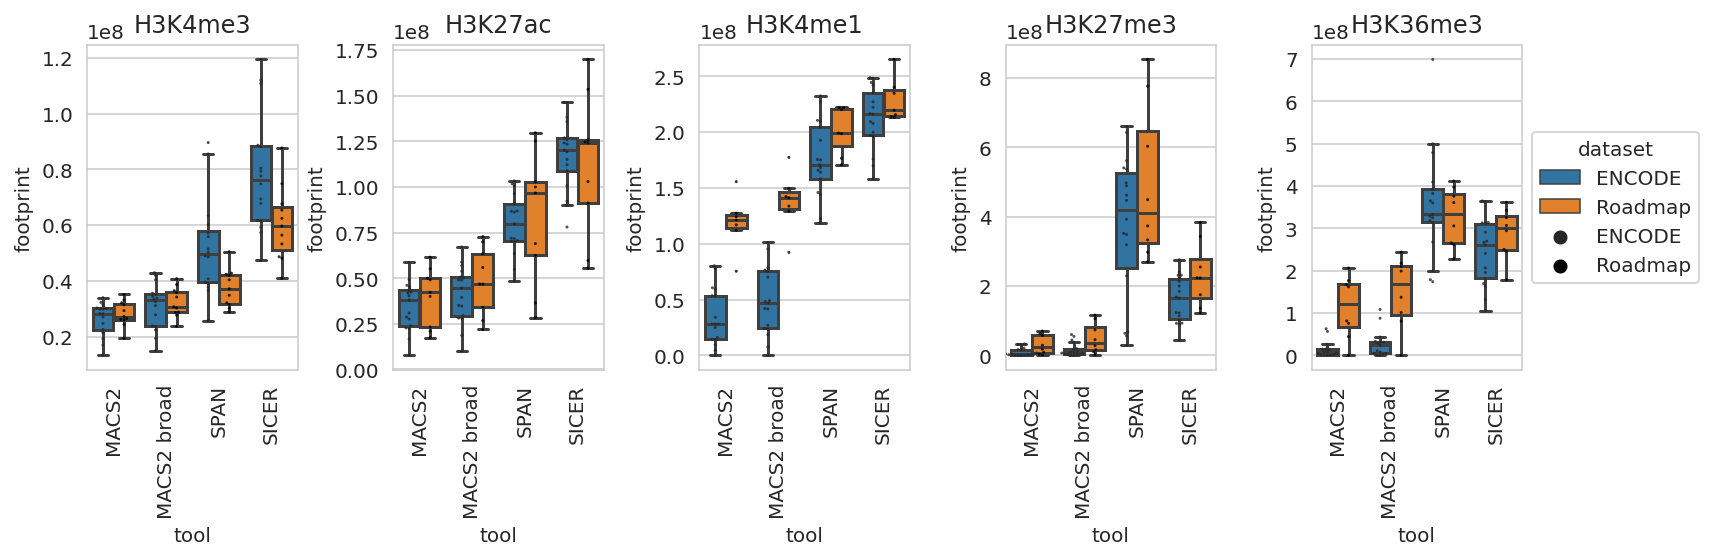

In [257]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='footprint', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='footprint', hue='dataset',
                  dodge=True, size=1.5, palette='dark:black', alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN','SICER'],
                  ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # if m not in ['H3K27me3', 'H3K36me3']:
    #     ax.set_ylim(1, 4e3)
    # else:
    #     ax.set_ylim(1, 1.7e4)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K36me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


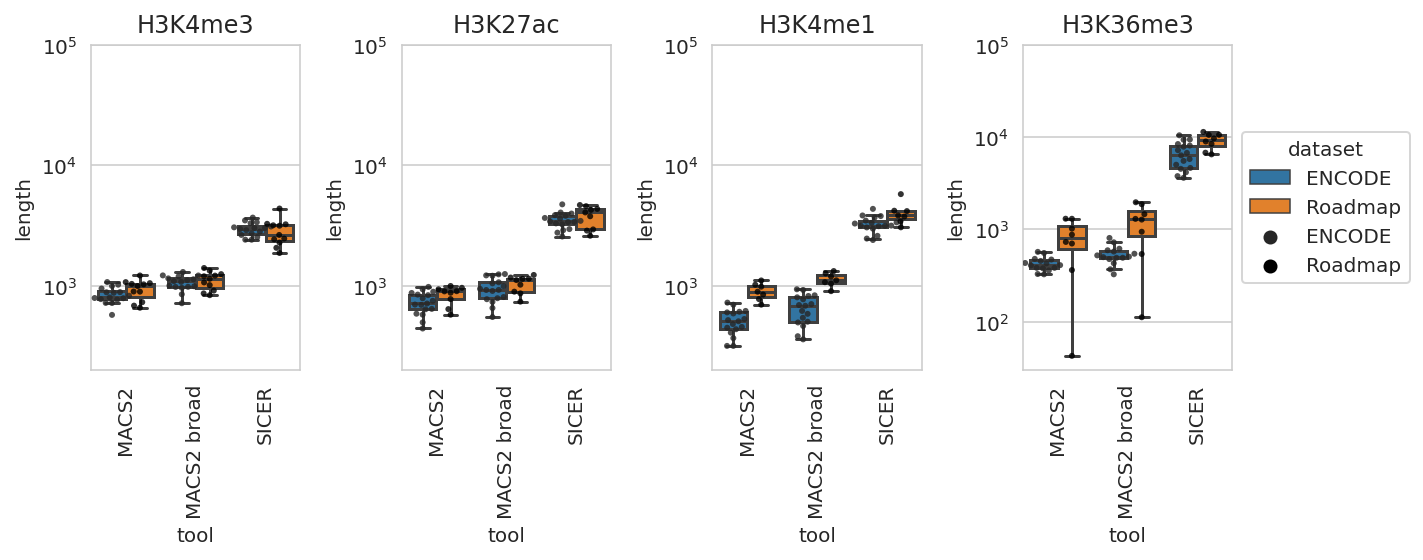

In [665]:
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='length', hue='dataset',
                  dodge=True, size=3,
                  palette='dark:black', alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SICER'],
                  ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K27me3', 'H3K36me3']:
        ax.set_ylim(bottom=200, top=1e5)
    else:
        ax.set_ylim(bottom=30, top=1e5)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

## BAMs

In [24]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

In [25]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'

df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

In [26]:
df_bams

bam_file modification      cell  \
0    /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3      NHLF   
1    /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3      NHEK   
2    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac      NHEK   
3    /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K27me3      HSMM   
4    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1      K562   
..                                                 ...          ...       ...   
154  /home/jetbrains/data/2023_Immune/bams/BCell_H3...      H3K4me3     BCell   
155  /home/jetbrains/data/2023_Immune/bams/Monocyte...      H3K27ac  Monocyte   
156  /home/jetbrains/data/2023_Immune/bams/CD34_H3K...     H3K36me3      CD34   
157  /home/jetbrains/data/2023_Immune/bams/CD4_H3K4...      H3K4me1       CD4   
158  /home/jetbrains/data/2023_Immune/bams/PBMC_H3K...     H3K27me3      PBMC   

    replicate     reads  dataset  
0        rep1  14385159   ENCODE  
1        rep2   7569713   ENCODE  
2        rep1   9377615   ENCODE  
3        rep2   8356060   ENCODE  
4        rep2   7777248   ENCODE  
..        ...       ...      ...  
154            24648172  Roadmap  
155            20750359  Roadmap  
156            20291379  Roadmap  
157      rep1  18117773  Roadmap  
158            20417465  Roadmap  

[159 rows x 6 columns]

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


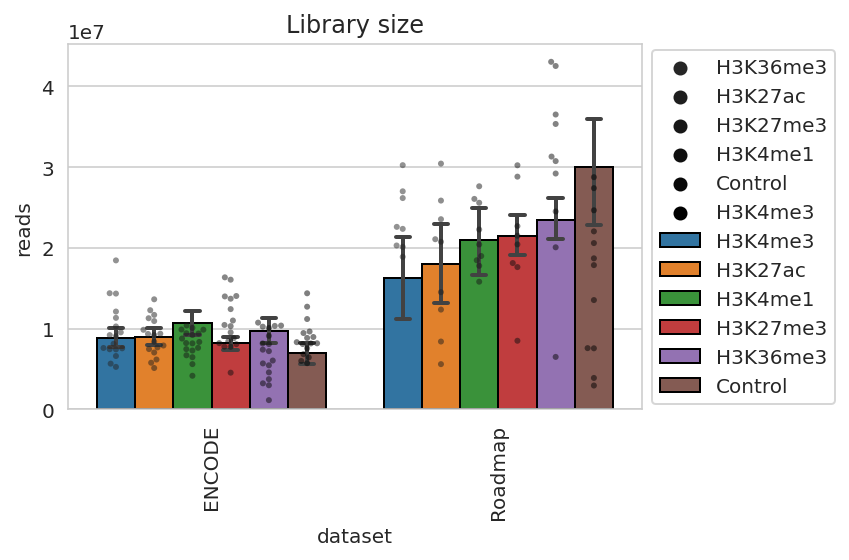

In [27]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
sns.barplot(data=df_bams, hue='modification', x='dataset', y='reads',
            capsize=.05, errwidth=2, edgecolor="black",
            hue_order=MODIFICATIONS+['Control'],
            ax=ax)
sns.swarmplot(data=df_bams, hue='modification', x='dataset', y='reads',
              dodge=True, size=3, palette='dark:black', alpha=0.5,
              ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [845]:
df_peaks_lens = pd.merge(df_peaks[['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
                         df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
                         on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_peaks_lens = pd.merge(df_peaks_lens,
                         df_lens_aggr[['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']],
                         on=['dataset', 'modification', 'cell', 'replicate', 'tool'], how='inner')
df_peaks_lens.sample(3)

dataset modification  cell replicate         tool  peaks     reads  \
1     ENCODE     H3K27me3  K562      rep2  MACS2 broad  18762   9211786   
394  Roadmap      H3K4me3  PBMC                  MACS2  25166  17863571   
428  Roadmap      H3K27ac   CD4                  SICER  37659  14516237   

        length    footprint  
1     265.0098    5017796.0  
394  1027.8760   25968954.0  
428  4056.8200  153413341.0



peaks vs length


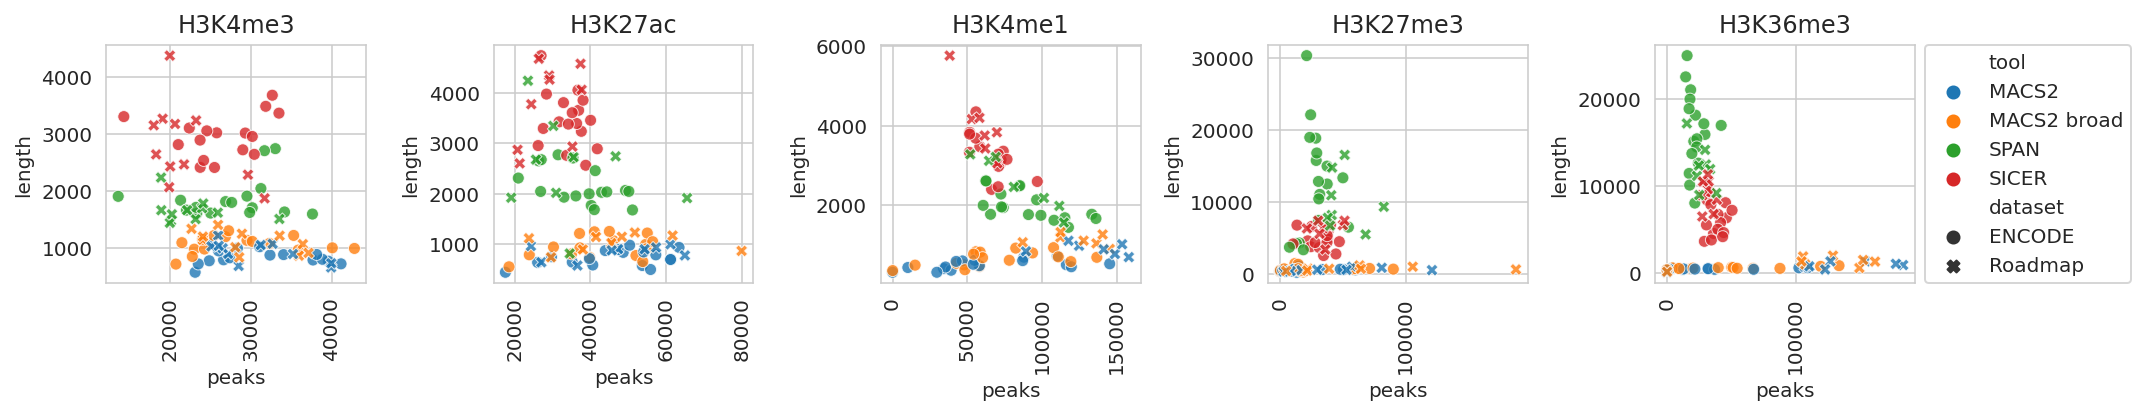



peaks vs reads


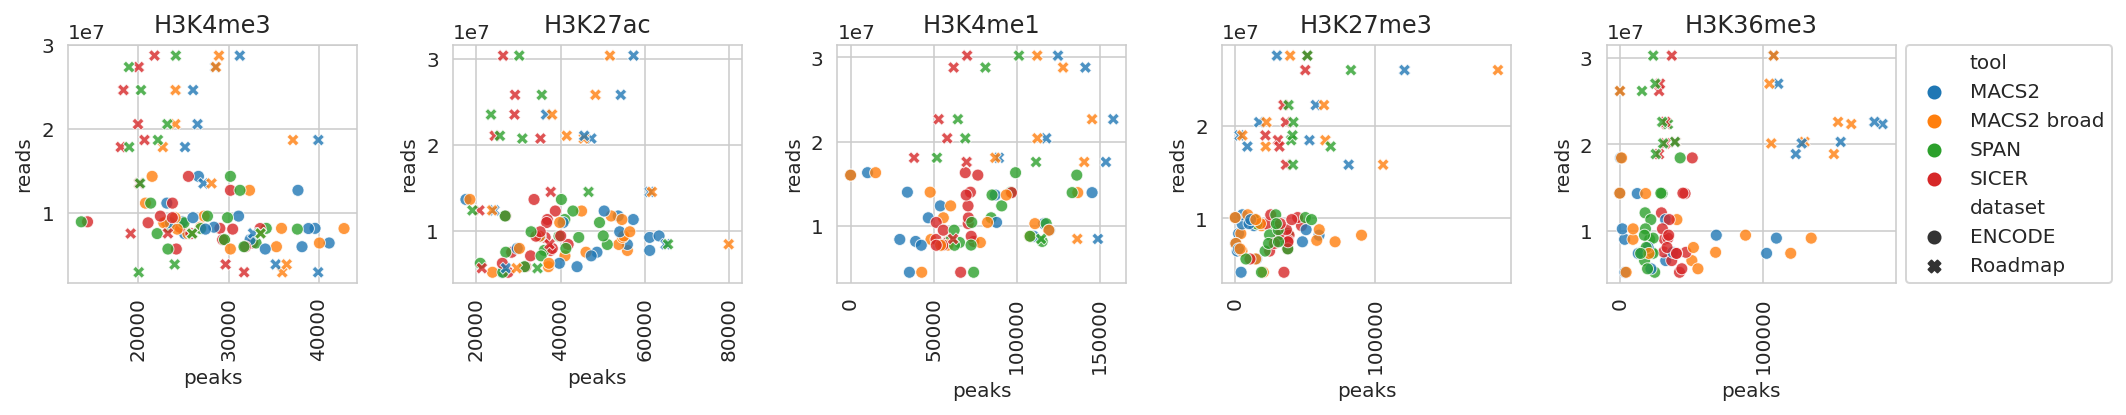

In [846]:
for x, y in [('peaks', 'length'), ('peaks', 'reads')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
        ax = axs[i]
        sns.scatterplot(
            df_peaks_lens[df_peaks_lens['modification'] == m], x=x, y=y, hue='tool', 
            alpha=0.8,
            style='dataset',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            ax = ax)
        ax.title.set_text(m)
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        if x != 'reads':
            ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()



peaks vs length


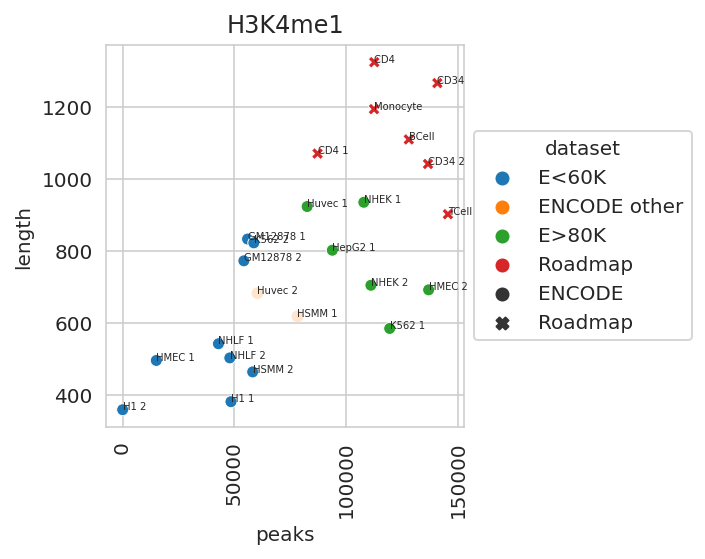



peaks vs reads


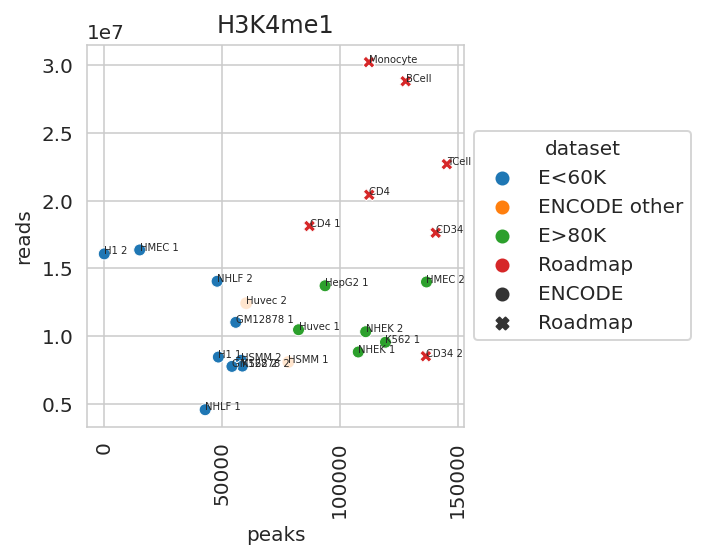

In [847]:
for x, y in [('peaks', 'length'), ('peaks', 'reads')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(5, 4))
    ax = plt.axes()
    tt = df_peaks_lens[(df_peaks_lens['modification'] == 'H3K4me1') & (df_peaks_lens['tool'] == 'MACS2 broad')].copy()
    tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
    sns.scatterplot(
        tt, x=x, y=y, 
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    for xv, yv, cell, rep in zip(tt[x], tt[y], tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
    ax.title.set_text('H3K4me1')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if x != 'reads':
        ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

# BigWigs

In [345]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}


def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [346]:
encode_bws = load_bws(GSE26320_PATH + '/bw', ['H3K4me1'], GSE26320_CELLS, GSE26320_REPS, 'Input')
encode_bws['dataset'] = 'ENCODE'
display(encode_bws.sample(3))

immune_bws = load_bws(IMMUNE_PATH + '/bw', ['H3K4me1'], IMMUNE_CELLS, IMMUNE_REPS, 'Control')
immune_bws['dataset'] = 'Roadmap'
display(immune_bws.sample(3))
all_bws = pd.concat([encode_bws, immune_bws]).reset_index(drop=False)

  0%|          | 0/103 [00:00<?, ?it/s]

file modification     cell  \
15  /home/jetbrains/data/2023_GSE26320/bw/GSM64647...      Control     NHEK   
5   /home/jetbrains/data/2023_GSE26320/bw/GSM64640...      H3K4me1     HSMM   
1   /home/jetbrains/data/2023_GSE26320/bw/GSM64632...      H3K4me1  GM12878   

   replicate dataset  
15      rep1  ENCODE  
5       rep1  ENCODE  
1       rep1  ENCODE

  0%|          | 0/56 [00:00<?, ?it/s]

file modification      cell  \
12  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...      H3K4me1  Monocyte   
5   /home/jetbrains/data/2023_Immune/bw/NK_Control...      Control        NK   
10  /home/jetbrains/data/2023_Immune/bw/BCell_Cont...      Control     BCell   

   replicate  dataset  
12            Roadmap  
5             Roadmap  
10            Roadmap

In [366]:
import pyBigWig

total_coverages = {}
ts = []
for _, (ds, m, c, r) in tqdm(list(all_bws[['dataset', 'modification', 'cell', 'replicate']].iterrows())):
    print(ds, m, c, r)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['dataset'] == ds)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    
    try:
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr)
            print('Total coverage', total_coverage)
            # Multiplier to align BAM coverage with BigWig estimation
            total_coverage *= 1.1e-2
            total_coverages[(ds, m, c, r)] = total_coverage
    except Exception:
        pass
        # print('ERROR')

total_coverages_df = pd.DataFrame([(ds, m, c, r, n) for (ds, m, c, r), n in total_coverages.items()],
                                  columns=['dataset', 'modification', 'cell', 'replicate', 'reads'])
total_coverages_df.sample(5)

  0%|          | 0/53 [00:00<?, ?it/s]

ENCODE Control HSMM rep1
/home/jetbrains/data/2023_GSE26320/bw/GSM646410_HSMM_Input_rep1.bw
Total coverage 894815013.0
ENCODE H3K4me1 GM12878 rep1
/home/jetbrains/data/2023_GSE26320/bw/GSM646322_GM12878_H3K4me1_rep1.bw
Total coverage 1068252750.0
ENCODE H3K4me1 NHLF rep1
/home/jetbrains/data/2023_GSE26320/bw/GSM646482_NHLF_H3K4me1_rep1.bw
Total coverage 369591300.0
ENCODE H3K4me1 HMEC rep2
/home/jetbrains/data/2023_GSE26320/bw/GSM646381_HMEC_H3K4me1_rep2.bw
Total coverage 1111280200.0
ENCODE Control GM12878 rep1
/home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
Total coverage 562992392.0
ENCODE H3K4me1 HSMM rep1
/home/jetbrains/data/2023_GSE26320/bw/GSM646400_HSMM_H3K4me1_rep1.bw
Total coverage 653983869.0
ENCODE H3K4me1 K562 rep1
/home/jetbrains/data/2023_GSE26320/bw/GSM646440_K562_H3K4me1_rep1.bw
Total coverage 778520838.0
ENCODE H3K4me1 K562 rep2
/home/jetbrains/data/2023_GSE26320/bw/GSM646441_K562_H3K4me1_rep2.bw
Total coverage 747470650.0
ENCODE Control NHLF re

dataset modification  cell replicate         reads
6    ENCODE      H3K4me1  K562      rep1  8.563729e+06
2    ENCODE      H3K4me1  NHLF      rep1  4.065504e+06
30   ENCODE      Control    H1      rep2  2.772636e+06
36  Roadmap      Control   CD4            3.967016e+07
8    ENCODE      Control  NHLF      rep2  7.373895e+06

In [361]:
# Prepare BAM files
WD = os.path.expanduser('~/data/2023_wiggle')

BLACKLIST_PATH = WD + '/hg38-blacklist.v2.bed'
blacklist_df = pd.read_csv(BLACKLIST_PATH, sep='\t', header=None)
blacklist_df.rename({0: 'chr', 1: 'start', 2: 'end'}, axis=1, inplace=True)
blacklist_df

chr     start       end                   3
0    chr10         0     45700     Low Mappability
1    chr10  38481300  38596500  High Signal Region
2    chr10  38782600  38967900  High Signal Region
3    chr10  39901300  41712900  High Signal Region
4    chr10  41838900  42107300  High Signal Region
..     ...       ...       ...                 ...
631   chrY   4343800   4345800  High Signal Region
632   chrY  10246200  11041200  High Signal Region
633   chrY  11072100  11335300  High Signal Region
634   chrY  11486600  11757800  High Signal Region
635   chrY  26637300  57227400  High Signal Region

[636 rows x 4 columns]

In [445]:
def collect_bw_stats(bw_path, control_bw_path, chrom_sizes, blacklist, region, top_regions, work_regions, resolution):
    print('Prepare chromosome indexes')
    chr_indx = {}
    indx = 0
    for chr, chr_size in chrom_sizes.items():
        if '_' in chr:
            continue
        bins = int(math.floor(chr_size / region))
        chr_indx[chr] = (indx, indx + bins)
        indx += bins
    chromosomes = list(chr_indx.keys())

    print('Compute coverage in regions')
    region_coverages = np.zeros(indx)
    with pyBigWig.open(bw_path) as bw:
        for chr, (istart, iend) in chr_indx.items():
            region_coverages[istart: iend] = \
                np.array([x or 0 for x in bw.stats(chr, 1, CHROM_SIZES[chr], nBins=iend - istart, exact=True, type='sum')])
    
    print('Processing blacklisted regions')
    blacklist_marked = 0
    for chr, start, end in zip(blacklist['chr'], blacklist['start'], blacklist['end']):
        if chr not in chr_indx:
            continue
        offset = chr_indx[chr][0]
        for x in range(int(math.floor(start / region)), int(math.ceil(end / region)) + 1):
            region_coverages[min(x - offset, len(region_coverages) - 1)] = 0
            blacklist_marked += 1
    print(f'Marked {blacklist_marked} / {len(region_coverages)} bins as blacklist')

    if top_regions > len(region_coverages):
        raise Exception(f'Too many top regions {top_regions} > {len(region_coverages)}')
    
    print('Split by chromosomes')
    chr_xs = [[] for _ in range(len(chr_indx))]  # Create new array for each chromosome index
    ichr = 0
    for x in np.sort(np.argpartition(region_coverages, -top_regions)[-top_regions:]):
        while chr_indx[chromosomes[ichr]][1] < x:
            ichr += 1
        chr_xs[ichr].append(x)

    print('Collect final regions')
    peaks = []
    for ichr, xs in enumerate(chr_xs):
        chr = chromosomes[ichr]
        offset = chr_indx[chr][0]
        for i, x in enumerate(xs):
            peaks.append((chr, (x - offset) * region, (x + 1 - offset) * region))
    df = pd.DataFrame(peaks, columns=['chromosome', 'start', 'end'])
    if len(df) > work_regions:
        print(f'Pick {work_regions} / {top_regions} uniform regions for computation speedup')
        step = int(math.ceil(len(df) / float(work_regions)))
        df = df.iloc[range(0, len(df), step)].copy()
    
    print('Collecting bigwig stats')
    sums, means, stds, control_sums, control_means, control_stds = [], [], [], [], [], []
    with pyBigWig.open(bw_path) as bw:
        with pyBigWig.open(control_bw_path) as cbw: 
            for _, (chr, start, end) in df.iterrows():
                stats = np.array(bw.stats(
                    chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
                sums.append(np.sum(stats))
                means.append(np.mean(stats))
                stds.append(np.std(stats))
                control_stats = np.array(cbw.stats(
                    chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
                control_sums.append(np.sum(control_stats))
                control_means.append(np.mean(control_stats))
                control_stds.append(np.std(control_stats))
    df['sum'] = sums
    df['mean'] = means
    df['std'] = stds
    df['control_sum'] = control_sums
    df['control_mean'] = control_means
    df['control_std'] = control_stds
    return df

In [635]:
REGION = 10_000
TOP_REGIONS = 50_000
WORK_REGIONS = 1000
RESOLUTION = 50

# Compute on top chromosomes for speed
chrom_sizes_part = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

ts = []
for _, (bw_path, ds, m, c, r) in tqdm(list(all_bws[['file', 'dataset', 'modification', 'cell', 'replicate']].iterrows())):
    if m == 'Control':
        continue
    print(ds, m, c, r, bw_path)
    ct = all_bws[(all_bws['modification'] == 'Control') &
                 (all_bws['cell'] == c) &
                 (all_bws['replicate'] == r) &
                 (all_bws['dataset'] == ds)]
    if len(ct) == 0:
        continue
    cbw_path = ct['file'].values[0]
    print(bw_path, cbw_path)
    df = collect_bw_stats(bw_path, cbw_path, chrom_sizes_part, blacklist_df, REGION, TOP_REGIONS, WORK_REGIONS, RESOLUTION)
    df['dataset'] = ds
    df['modification'] = m
    df['cell'] = c
    df['replicate'] = r
    df['rpkm'] = df['sum'] / ((REGION / 1e3) * ((total_coverages[(ds, m, c, r)]) / 1e6))
    df['control_reads'] = total_coverages[(ds, 'Control', c, r)]
    df['control_rpkm'] = df['control_sum'] / ((REGION / 1e3) * ((total_coverages[(ds, 'Control', c, r)]) / 1e6))
    df['signal_to_control'] = df['rpkm'] / df['control_rpkm'] 
    ts.append(df)
df_bw_stats = pd.concat(ts).reset_index(drop=True)
df_bw_stats.sample(5)

  0%|          | 0/53 [00:00<?, ?it/s]

ENCODE H3K4me1 GM12878 rep1 /home/jetbrains/data/2023_GSE26320/bw/GSM646322_GM12878_H3K4me1_rep1.bw
/home/jetbrains/data/2023_GSE26320/bw/GSM646322_GM12878_H3K4me1_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
Prepare chromosome indexes
Compute coverage in regions
Processing blacklisted regions
Marked 3864 / 68943 bins as blacklist
Split by chromosomes
Collect final regions
Pick 1000 / 50000 uniform regions for computation speedup
ENCODE H3K4me1 NHLF rep1 /home/jetbrains/data/2023_GSE26320/bw/GSM646482_NHLF_H3K4me1_rep1.bw
/home/jetbrains/data/2023_GSE26320/bw/GSM646482_NHLF_H3K4me1_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646492_NHLF_Input_rep1.bw
Prepare chromosome indexes
Compute coverage in regions
Processing blacklisted regions
Marked 3864 / 68943 bins as blacklist
Split by chromosomes
Collect final regions
Pick 1000 / 50000 uniform regions for computation speedup
ENCODE H3K4me1 HMEC rep2 /home/jetbrains/data/2023_GSE26320/bw/GSM646381_HMEC_

chromosome      start        end     sum   mean        std  control_sum  \
3781        chr3   55020000   55030000  1250.0   6.25  17.275344       2700.0   
728         chr3   11380000   11390000  2800.0  14.00  26.532998       2000.0   
9086        chr1   51460000   51470000  2600.0  13.00  25.612497       1500.0   
14930       chr3  152180000  152190000  3350.0  16.75  29.273495       1700.0   
3870        chr3  117780000  117790000   950.0   4.75  15.489916       1350.0   

       control_mean  control_std dataset modification     cell replicate  \
3781          13.50    24.346458  ENCODE      H3K4me1     HSMM      rep1   
728           10.00    22.912878  ENCODE      H3K4me1  GM12878      rep1   
9086           7.50    19.843135  ENCODE      H3K4me1       H1      rep2   
14930          8.50    20.068632  ENCODE      H3K4me1  GM12878      rep2   
3870           6.75    21.022310  ENCODE      H3K4me1     HSMM      rep1   

            rpkm  control_reads  control_rpkm  signal_to_control  
3781   17.376019    9842965.143     27.430759           0.633450  
728    23.828205    6192916.312     32.294962           0.737830  
9086   18.413396    2772635.690     54.100148           0.340358  
14930  41.098704    5933447.894     28.651132           1.434453  
3870   13.205775    9842965.143     13.715379           0.962844

In [848]:
df_bw_stats['std_mean'] = df_bw_stats['std'] / df_bw_stats['mean']
df_bw_stats['control_std_mean'] = df_bw_stats['control_std'] / df_bw_stats['control_mean']
df_bw_stats['signal_to_control_std_mean'] = df_bw_stats['std_mean'] / df_bw_stats['control_std_mean']

In [849]:
tt = df_bw_stats[(df_bw_stats['cell'] == 'HMEC') & (df_bw_stats['modification'] == 'H3K4me1')]
tt.sample(3)

chromosome      start        end     sum   mean        std  control_sum  \
11063       chr1   38690000   38700000  3600.0  18.00  37.762415       1700.0   
2949        chr3  167520000  167530000  1050.0   5.25  15.327671       2850.0   
11593       chr2  169660000  169670000  3600.0  18.00  30.430248       1250.0   

       control_mean  control_std dataset  ...  cell replicate       rpkm  \
11063          8.50    21.857493  ENCODE  ...  HMEC      rep1  25.161747   
2949          14.25    27.557894  ENCODE  ...  HMEC      rep2   8.589602   
11593          6.25    17.275344  ENCODE  ...  HMEC      rep1  25.161747   

       control_reads  control_rpkm  signal_to_control  std_mean  \
11063    3322364.617     51.168375           0.491744  2.097912   
2949     9518547.599     29.941543           0.286879  2.919556   
11593    3322364.617     37.623805           0.668772  1.690569   

       control_std_mean  signal_control_std_mean  signal_to_control_std_mean  
11063          2.571470                 0.815842                    0.815842  
2949           1.933887                 1.509683                    1.509683  
11593          2.764055                 0.611627                    0.611627  

[3 rows x 21 columns]

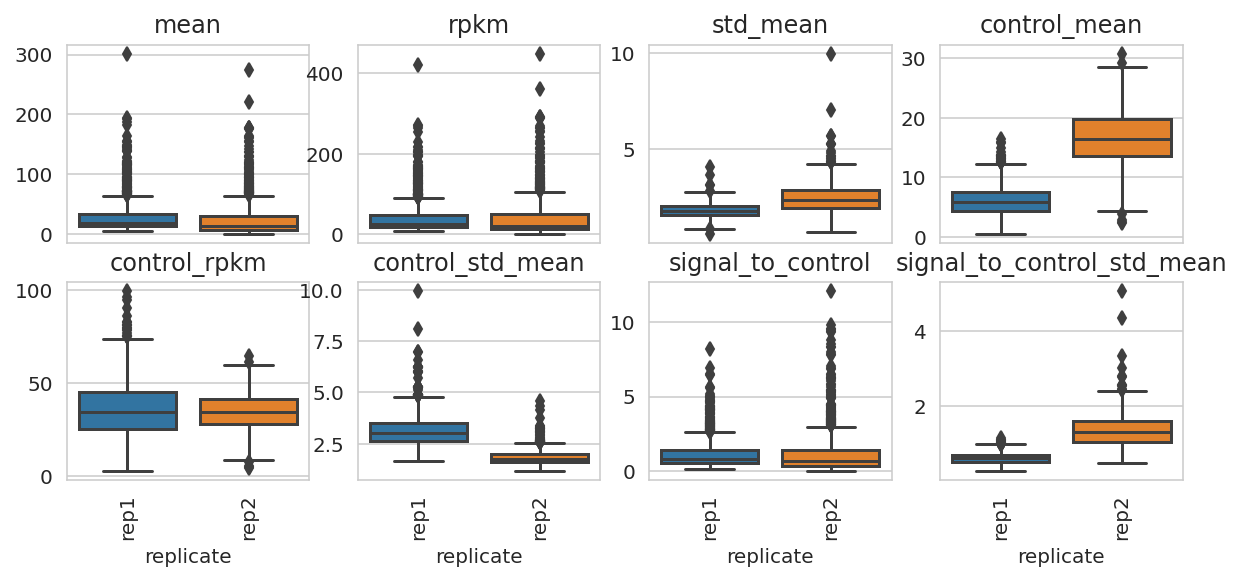

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

In [850]:
features = ['mean', 'rpkm', 'std_mean',
            'control_mean', 'control_rpkm', 'control_std_mean',
            'signal_to_control', 'signal_to_control_std_mean']

ncols = int(math.ceil(math.sqrt(len(features) + 3)))
nrows = int(math.ceil(len(features) / ncols))
plt.figure(figsize=(2.5 * ncols, 2 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features))]
for i, y in enumerate(features):
    ax = axs[i]
    plt.figure(figsize=(4, 3))
    sns.boxplot(data=tt, x='replicate', y=y, 
                order=['rep1', 'rep2'],
                showfliers=True,
                ax=ax)
    ax.title.set_text(y)
    ax.set_ylabel(None)
    if i / ncols < nrows - 1:
        ax.set_xlabel(None)
        ax.set_xticks([], minor=False)
        ax.set_xticklabels([])
    ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()

## Aggregation / percentiles

In [851]:
print('Assign groups by coverage percentiles individually in each track')
ts = []
for (ds, m, c, r), group in df_bw_stats.groupby(['dataset', 'modification', 'cell', 'replicate']):
    group = group.sort_values(by=['mean'], ascending=False)
    group['percentile'] = [10 * int(10.0 * i / len(group)) for i in range(len(group))]
    total_coverage = df_bams[(df_bams['dataset'] == ds) & 
                             (df_bams['modification'] == m) & 
                             (df_bams['cell'] == c) & 
                             (df_bams['replicate'] == r)]['reads'].values[0]
    ts.append(group)
df_bw_stats_perc = pd.concat(ts).reset_index(drop=True)
del ts
df_bw_stats_perc.sample(5)

Assign groups by coverage percentiles individually in each track


chromosome      start        end     sum   mean        std  control_sum  \
3113        chr3  172260000  172270000  9600.0  48.00  59.548300        950.0   
14471       chr1  226070000  226080000  1800.0   9.00  24.879711       1900.0   
19716       chr3  177950000  177960000  2850.0  14.25  24.175142      17050.0   
1164        chr1  166940000  166950000  5100.0  25.50  54.541269       3150.0   
13859       chr2  182790000  182800000   900.0   4.50  16.725729       3200.0   

       control_mean  control_std  dataset  ... replicate       rpkm  \
3113           4.75    15.489916   ENCODE  ...      rep2  67.987923   
14471          9.50    23.659036   ENCODE  ...      rep2  19.090150   
19716         85.25    64.186739  Roadmap  ...            14.932683   
1164          15.75    29.401318   ENCODE  ...      rep2  62.568177   
13859         16.00    28.618176   ENCODE  ...      rep1   9.610563   

      control_reads  control_rpkm  signal_to_control  std_mean  \
3113   2.772636e+06     34.263427           1.984271  1.240590   
14471  6.774217e+06     28.047522           0.680636  2.764412   
19716  3.967016e+07     42.979407           0.347438  1.696501   
1164   5.933448e+06     53.088863           1.178556  2.138873   
13859  8.751536e+06     36.565009           0.262835  3.716829   

       control_std_mean  signal_control_std_mean  signal_to_control_std_mean  \
3113           3.261035                 0.380428                    0.380428   
14471          2.490425                 1.110016                    1.110016   
19716          0.752924                 2.253218                    2.253218   
1164           1.866750                 1.145774                    1.145774   
13859          1.788636                 2.078024                    2.078024   

       percentile  
3113           10  
14471          40  
19716          70  
1164           10  
13859          80  

[5 rows x 22 columns]

In [852]:
print('Compute Signal-to-noise ratio')
t = df_bw_stats_perc[
    ['dataset', 'modification', 'cell', 'replicate', 'percentile', 'mean']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'percentile']).agg('mean').reset_index()
ts = []
for (ds, m, c, r), dt in t.groupby(['dataset', 'modification', 'cell', 'replicate']):
    snr = dt[dt['percentile'] <= 10]['mean'].mean() / dt[dt['percentile'] >= 80]['mean'].mean()
    ts.append((ds, m, c, r, snr))
df_snr = pd.DataFrame(ts, columns=['dataset', 'modification', 'cell', 'replicate', 'signal_to_noise'])
df_snr['ds_c_r'] = df_snr['dataset'] + ' ' + df_snr['cell'] + ' ' + df_snr['replicate']
df_snr.sample(3)

Compute Signal-to-noise ratio


dataset modification   cell replicate  signal_to_noise             ds_c_r
12  ENCODE      H3K4me1   K562      rep2        14.623402   ENCODE K562 rep2
4   ENCODE      H3K4me1   HMEC      rep1         7.037916   ENCODE HMEC rep1
10  ENCODE      H3K4me1  Huvec      rep2        24.112225  ENCODE Huvec rep2

Signal-to-noise


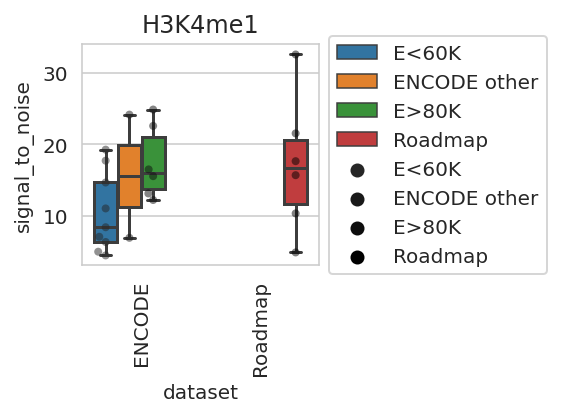

In [853]:
print('Signal-to-noise')
plt.figure(figsize=(4, 3))
ax = plt.axes()
t = df_snr[(df_snr['modification'] == 'H3K4me1')]
sns.boxplot(data=t, x='dataset', y='signal_to_noise',
            hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else 
            'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in t['ds_c_r']] if m == 'H3K4me1' else None,
            hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='dataset', y='signal_to_noise',
              hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
              'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in t['ds_c_r']] if m == 'H3K4me1' else None,
              hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
              dodge=True, size=4, alpha=0.5, palette='dark:black',
              ax=ax)

sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
ax.title.set_text(m)
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [854]:
print('Pick only top covered regions, where most of the peaks are located for average')
df_bw_stats_signal_aggr = df_bw_stats_perc[df_bw_stats_perc['percentile'] <= 10][
    ['dataset', 'modification', 'cell', 'replicate', 'sum', 'mean', 'std', 'rpkm', 'std_mean', 'signal_to_control', 
     'control_reads', 'control_sum', 'control_mean', 'control_std', 'control_rpkm', 'control_std_mean', 'signal_to_control_std_mean']
].groupby(['dataset', 'modification', 'cell', 'replicate']).agg('mean').reset_index()
df_bw_stats_signal_aggr['ds_c_r'] = df_bw_stats_signal_aggr['dataset'] + ' ' + \
                                    df_bw_stats_signal_aggr['cell'] + ' ' + df_bw_stats_signal_aggr['replicate']
df_bw_stats_signal_aggr.sample(3)

Pick only top covered regions, where most of the peaks are located for average


dataset modification  cell replicate       sum      mean         std  \
12  ENCODE      H3K4me1  K562      rep2  11435.50  57.17750   73.637179   
2   ENCODE      H3K4me1    H1      rep1   5577.25  27.88625   42.667442   
5   ENCODE      H3K4me1  HMEC      rep2  14454.75  72.27375  101.463865   

          rpkm  std_mean  signal_to_control  control_reads  control_sum  \
12  139.081168  1.442224           3.013691    6505990.535      3085.75   
2    77.919788  1.603945           1.877550    9008537.879      3795.25   
5   118.248141  1.509866           3.373837    9518547.599      3636.50   

    control_mean  control_std  control_rpkm  control_std_mean  \
12      15.42875    27.635066     47.429365          1.889786   
2       18.97625    31.089870     42.129478          1.669969   
5       18.18250    30.097731     38.204358          1.729498   

    signal_to_control_std_mean            ds_c_r  
12                    0.779826  ENCODE K562 rep2  
2                     0.967281    ENCODE H1 rep1  
5                     0.889403  ENCODE HMEC rep2

# Analyze vs peaks number / length

In [855]:
TOOL = 'MACS2 broad'

In [856]:
df_aggr = pd.merge(df_peaks_lens,
                   df_bw_stats_signal_aggr,
                   on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_aggr = pd.merge(df_aggr,
                   df_snr.drop('ds_c_r', axis=1),
                   on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_aggr.sample(3)

dataset modification     cell replicate   tool  peaks     reads  \
64   ENCODE      H3K4me1  GM12878      rep2  MACS2  42605   7754168   
31   ENCODE      H3K4me1  GM12878      rep1   SPAN  84659  11008158   
87  Roadmap      H3K4me1      CD4             SPAN  69107  20428604   

       length    footprint       sum  ...  signal_to_control  control_reads  \
64   589.8994   24995115.0   8633.00  ...           2.490253   5.933448e+06   
31  2478.6556  209604350.0  14769.50  ...           3.072416   6.192916e+06   
87  3211.9506  221905031.0  23009.25  ...           3.161448   3.967016e+07   

    control_sum  control_mean  control_std  control_rpkm  control_std_mean  \
64      2567.75      12.83875    25.442139     43.275850          2.024972   
31      2559.50      12.79750    25.179329     41.329478          2.019724   
87     15024.50      75.12250    66.914914     37.873555          0.911065   

    signal_to_control_std_mean               ds_c_r  signal_to_noise  
64                    0.752771  ENCODE GM12878 rep2         8.369365  
31                    0.642142  ENCODE GM12878 rep1        10.997394  
87                    1.313780         Roadmap CD4         10.301880  

[3 rows x 24 columns]

Full


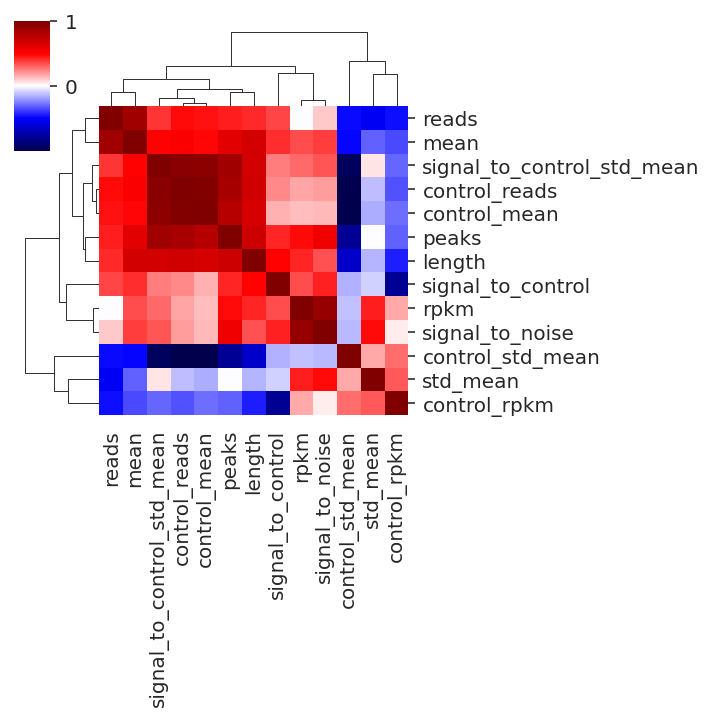

In [857]:
tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == TOOL)]
features = ['peaks', 'length',
            'reads', 'mean', 'rpkm', 'std_mean',
            'control_reads', 'control_mean', 'control_rpkm', 'control_std_mean',
            'signal_to_noise', 'signal_to_control', 'signal_to_control_std_mean']
print('Full')
sns.clustermap(tt[features].corr(method='spearman'),
               col_cluster=True, row_cluster=True,
               figsize=(5, 5),
               cmap=plt.cm.seismic)
plt.show()

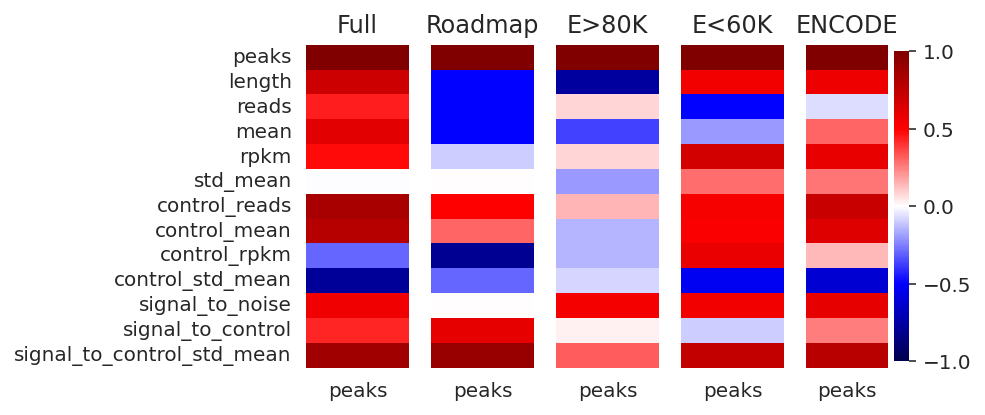

In [858]:
plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 5, i+1) for i in range(5)]
ax = axs[0]
sns.heatmap(tt[features].corr(method='spearman')[['peaks']], cmap=plt.cm.seismic, 
            vmin=-1, vmax=1, cbar=False, ax=ax)
ax.set_title('Full')

ax = axs[1]
sns.heatmap(tt[tt['dataset'] == 'Roadmap'][features].corr(method='spearman')[['peaks']], cmap=plt.cm.seismic, 
            vmin=-1, vmax=1, cbar=False, ax=ax)
ax.set_title('Roadmap')
ax.set_ylabel(None)
ax.set_yticks([], minor=False)
ax.set_yticklabels([])

ax = axs[2]
sns.heatmap(tt[tt['ds_c_r'].isin(g2_ds_c_r)][features].corr(method='spearman')[['peaks']], cmap=plt.cm.seismic, 
            vmin=-1, vmax=1, cbar=False, ax=ax)
ax.set_title('E>80K')
ax.set_ylabel(None)
ax.set_yticks([], minor=False)
ax.set_yticklabels([])

ax = axs[3]
sns.heatmap(tt[tt['ds_c_r'].isin(g1_ds_c_r)][features].corr(method='spearman')[['peaks']], cmap=plt.cm.seismic, 
            vmin=-1, vmax=1, cbar=False, ax=ax)
ax.set_title('E<60K')
ax.set_ylabel(None)
ax.set_yticks([], minor=False)
ax.set_yticklabels([])

ax = axs[4]
sns.heatmap(tt[tt['dataset'] == 'ENCODE'][features].corr(method='spearman')[['peaks']], cmap=plt.cm.seismic,
            vmin=-1, vmax=1, ax=ax)
ax.set_title('ENCODE')
ax.set_ylabel(None)
ax.set_yticks([], minor=False)
ax.set_yticklabels([])


plt.tight_layout()
plt.show()

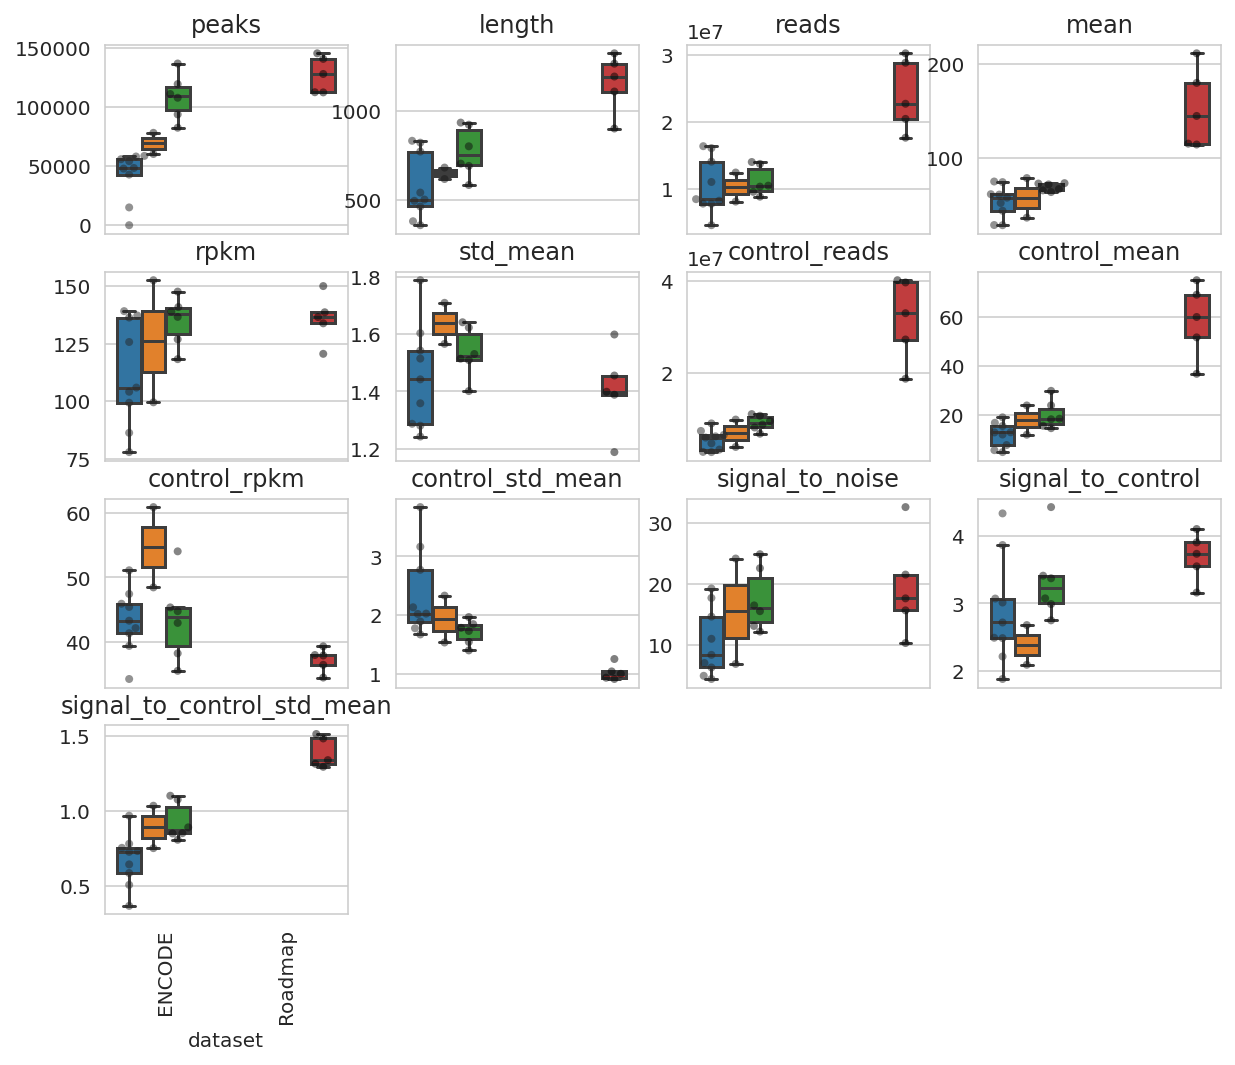

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

In [859]:
ncols = int(math.ceil(math.sqrt(len(features) + 3)))
nrows = int(math.ceil(len(features) / ncols))
plt.figure(figsize=(2.5 * ncols, 2 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features))]
for i, y in enumerate(features):
    ax = axs[i]
    plt.figure(figsize=(4, 3))
    sns.boxplot(data=tt, x='dataset', y=y,
                hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
                'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']] if m == 'H3K4me1' else None,
                hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
                showfliers=False,
                ax=ax)
    sns.swarmplot(data=tt, x='dataset', y=y,
                  hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
                  'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']] if m == 'H3K4me1' else None,
                  hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
                  dodge=True, size=4, alpha=0.5, palette='dark:black',
                  ax=ax)
    ax.title.set_text(y)
    ax.set_ylabel(None)
    if i / ncols < nrows - 1:
        ax.set_xlabel(None)
        ax.set_xticks([], minor=False)
        ax.set_xticklabels([])
    ax.xaxis.set_tick_params(rotation=90)
    if i % nrows == -1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    
plt.tight_layout()
plt.show()

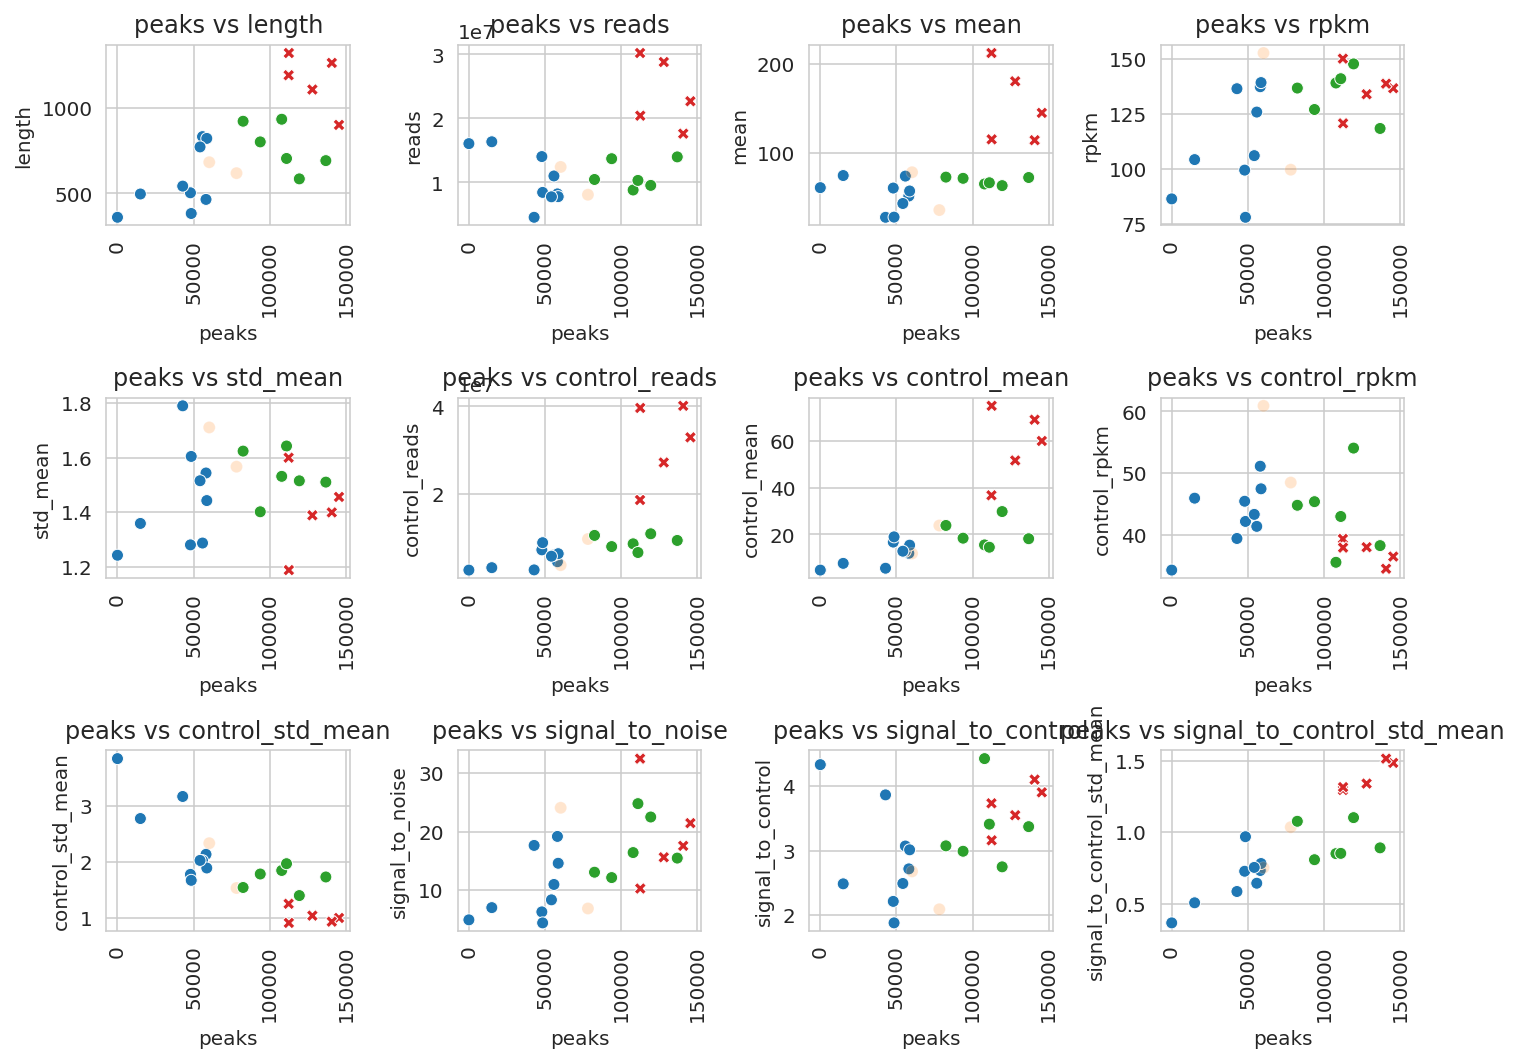

In [860]:
ncols = int(math.ceil(math.sqrt(len(features) - 1)))
nrows = int(math.ceil((len(features) - 1) / ncols))
plt.figure(figsize=(2.5 * ncols, 2.5 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features) - 1)]
for i, y in enumerate(f for f in features if f!='peaks'):
    ax = axs[i]
    tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == TOOL)].copy()
    tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
    sns.scatterplot(
        tt, x='peaks', y=y,
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    ax.title.set_text(f'peaks vs {y}')
    ax.xaxis.set_tick_params(rotation=90)
    if i % nrows == -1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
plt.tight_layout()
plt.show()



peaks vs signal_to_control_std_mean
Correlation 0.8712591756070017, p 1.3130486592673992e-07


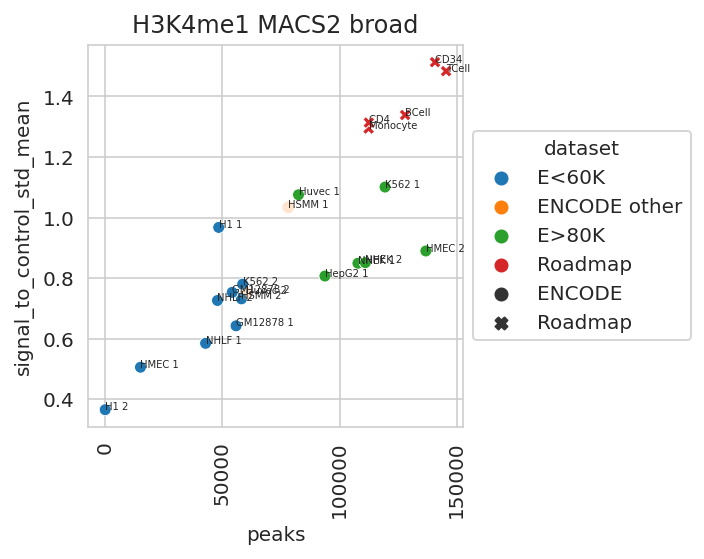

In [861]:
from scipy.stats import spearmanr 
for x, y in [('peaks', 'signal_to_control_std_mean')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(5, 4))
    ax = plt.axes()
    tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == TOOL)].copy()
    tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
    sns.scatterplot(
        tt, x=x, y=y,
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    for xv, yv, cell, rep in zip(tt[x], tt[y], tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
    corr, p = spearmanr(tt[x], tt[y])
    print(f'Correlation {corr}, p {p}')
    ax.title.set_text(f'H3K4me1 {TOOL}')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if x != 'reads':
        ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

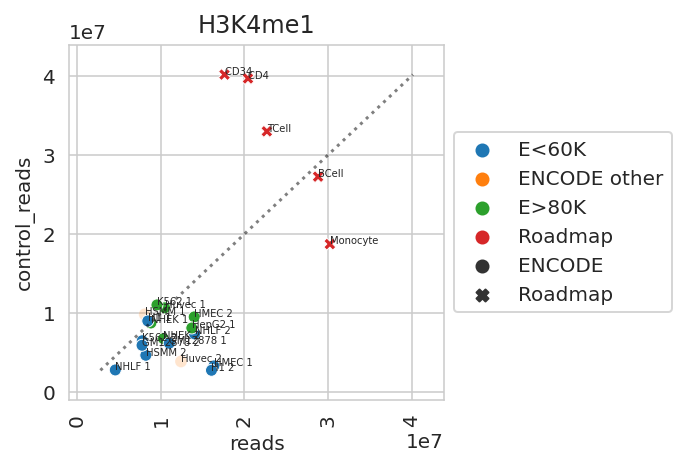

In [862]:
for (x, y) in [('reads', 'control_reads')]:
    plt.figure(figsize=(5, 3.5))
    ax = plt.axes()
    tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == 'MACS2 broad')].copy()
    tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
    sns.scatterplot(
        tt, x=x, y=y,
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    for xv, yv, cell, rep in zip(tt[x], tt[y], tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
    minr = min(tt[x].min(), tt[y].min())
    maxr = max(tt[x].max(), tt[y].max())
    sns.lineplot(x=[minr, maxr], y=[minr, maxr], color='black', ax=ax, alpha=0.5, linestyle='dotted')
    ax.set_xlim(minr - 0.1 * (maxr - minr), maxr + 0.1 * (maxr - minr))
    ax.set_ylim(minr - 0.1 * (maxr - minr), maxr + 0.1 * (maxr - minr))
    ax.title.set_text('H3K4me1')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

In [863]:
tt[tt['cell'] == 'HMEC'][features]

peaks    length     reads      mean        rpkm  std_mean  control_reads  \
1    15099  496.5141  16351916  74.47875  104.111970  1.358437    3322364.617   
33  136806  692.6024  13989144  72.27375  118.248141  1.509866    9518547.599   

    control_mean  control_rpkm  control_std_mean  signal_to_noise  \
1        7.62625     45.908567          2.771376         7.037916   
33      18.18250     38.204358          1.729498        15.509388   

    signal_to_control  signal_to_control_std_mean  
1            2.484662                    0.505384  
33           3.373837                    0.889403

In [864]:
tt[tt['cell'] == 'H1'][features]

peaks      length     reads      mean       rpkm  std_mean  control_reads  \
37  48462  381.988800   8443445  27.88625  77.919788  1.603945    9008537.879   
41     62  359.709677  16061844  60.91125  86.275612  1.241878    2772635.690   

    control_mean  control_rpkm  control_std_mean  signal_to_noise  \
37      18.97625     42.129478          1.669969         4.427267   
41       4.74500     34.227360          3.839604         4.946604   

    signal_to_control  signal_to_control_std_mean  
37           1.877550                    0.967281  
41           4.337802                    0.364944

PCA of aggregated datasets


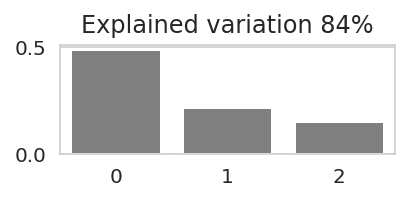

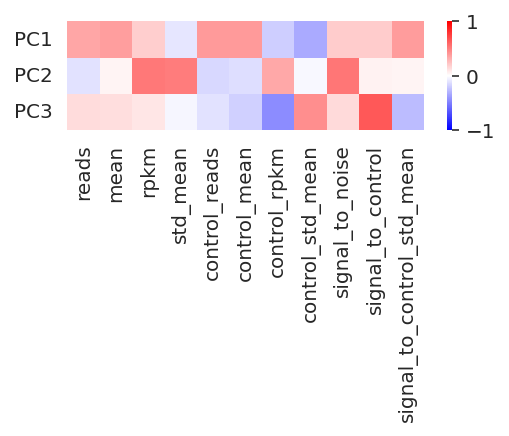

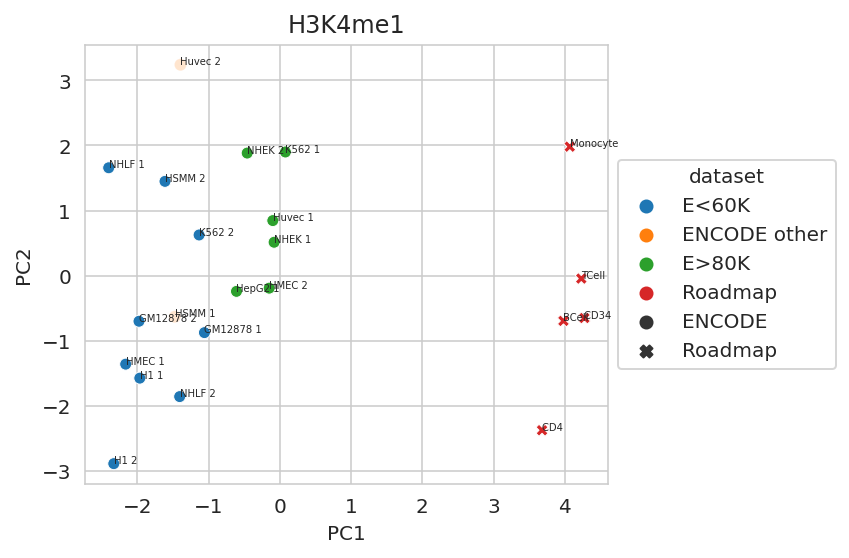

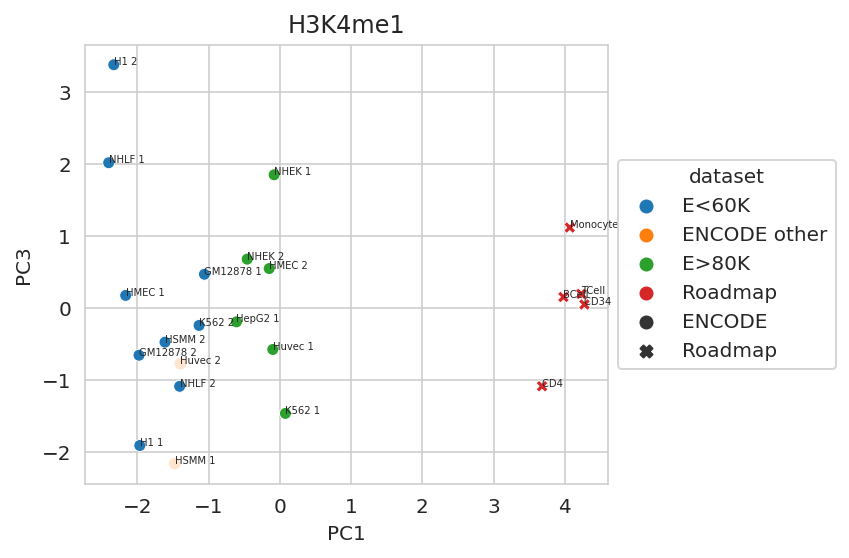

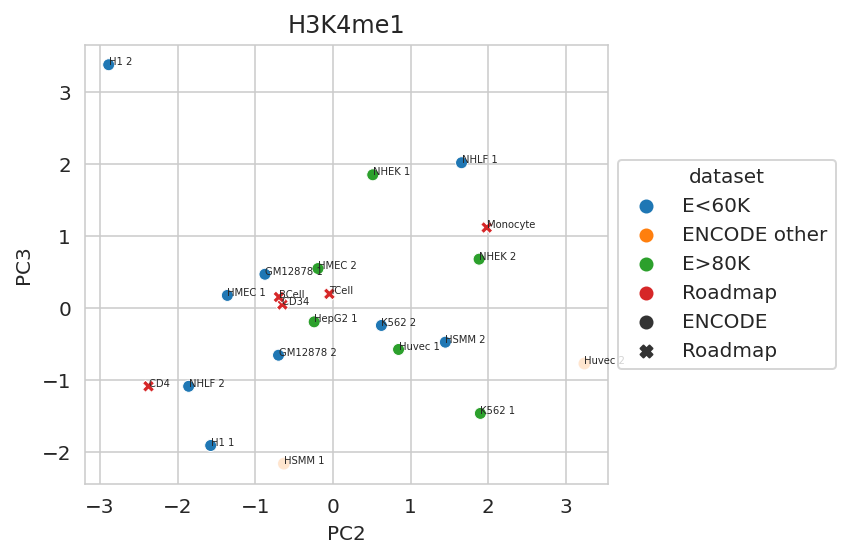

In [865]:
print('PCA of aggregated datasets')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# n = 'mle'
n = 3
pca = PCA(n_components=n)
# pca_features = [f for f in features if f not in ['peaks', 'length', 'reads', 'mean', 'control_mean']]
pca_features = [f for f in features if f not in ['peaks', 'length']]
ttn = StandardScaler().fit_transform(tt[pca_features]) # (n_samples x n_features)
result_pca = pca.fit_transform(ttn)

plt.figure(figsize=(3, 1))
plt.title(f'Explained variation {int(np.sum(pca.explained_variance_ratio_) * 100)}%')
sns.barplot(x=list(range(pca.n_components_)), y=pca.explained_variance_ratio_, color='gray')
plt.show()

rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)

plt.figure(figsize=(4, 1))
sns.heatmap(pca.components_,
            cmap='bwr', vmin=-1, vmax=1,
            yticklabels=[f'PC{i + 1}' for i in range(pca.n_components_)],
            xticklabels=pca_features)
plt.show()

for c1, c2 in [(0, 1), (0, 2), (1, 2)]:
    xs = result_pca[:, c1]
    ys = result_pca[:, c2]
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    sns.scatterplot(
        tt, x=xs, y=ys,
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    for xv, yv, cell, rep in zip(xs, ys, tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
    ax.title.set_text('H3K4me1')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel(f'PC{c1+1}')
    ax.set_ylabel(f'PC{c2+1}')
    plt.tight_layout()
    plt.show()

# Difference

In [617]:
def compute_diffs(df, modifications, cells, replicates):
    tools = df['tool'].unique()
    rows = []    
    tf = tempfile.mktemp()
    for m, c, r in tqdm(list(product(modifications, cells, replicates))):
        print(m, c, r)
        t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == 'SPAN')]
        if len(t) == 0:
            continue
        span_file = sorted_file(t['file'].values[0])
        # Processing single tools information
        for tool in tools:
            if tool == 'SPAN':
                continue
            t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == tool)]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
                !bedtools intersect {args} -wa -v > {tf}
                peaks = lines(tf)
                rows.append((m, c, r, name, peaks))

    return pd.DataFrame(rows, columns=['modification', 'cell', 'replicate', 'name', 'peaks'])

## ENCODE

In [618]:
df_encode_diff = compute_diffs(df_encode_peaks, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_diff.sample(5)

  0%|          | 0/90 [00:00<?, ?it/s]

H3K4me3 GM12878 rep1
H3K4me3 GM12878 rep2
H3K4me3 HMEC rep1
H3K4me3 HMEC rep2
H3K4me3 HSMM rep1
H3K4me3 HSMM rep2
H3K4me3 K562 rep1
H3K4me3 K562 rep2
H3K4me3 NHEK rep1
H3K4me3 NHEK rep2
H3K4me3 NHLF rep1
H3K4me3 NHLF rep2
H3K4me3 H1 rep1
H3K4me3 H1 rep2
H3K4me3 Huvec rep1
H3K4me3 Huvec rep2
H3K4me3 HepG2 rep1
H3K4me3 HepG2 rep2
H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27ac H1 rep1
H3K27ac H1 rep2
H3K27ac Huvec rep1
H3K27ac Huvec rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2
H3K4me1 GM12878 rep1
H3K4me1 GM12878 rep2
H3K4me1 HMEC rep1
H3K4me1 HMEC rep2
H3K4me1 HSMM rep1
H3K4me1 HSMM rep2
H3K4me1 K562 rep1
H3K4me1 K562 rep2
H3K4me1 NHEK rep1
H3K4me1 NHEK rep2
H3K4me1 NHLF rep1
H3K4me1 NHLF rep2
H3K4me1 H1 rep1
H3K4me1 H1 rep2
H3K4me1 Huvec rep1
H3K4me1 Huvec rep2
H3K4me1 HepG2 rep1
H3K4me1 HepG2 rep2
H3K27me3 G

modification  cell replicate                name   peaks
278      H3K4me1    H1      rep2  SPAN - MACS2 broad  136163
131      H3K27ac  HSMM      rep2        SICER - SPAN     153
350     H3K27me3  NHEK      rep1  SPAN - MACS2 broad    9028
372     H3K27me3    H1      rep1        SPAN - MACS2    1567
164      H3K27ac  NHLF      rep2  SPAN - MACS2 broad    2669

H3K4me3
H3K27ac
H3K4me1


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


H3K27me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


H3K36me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWa

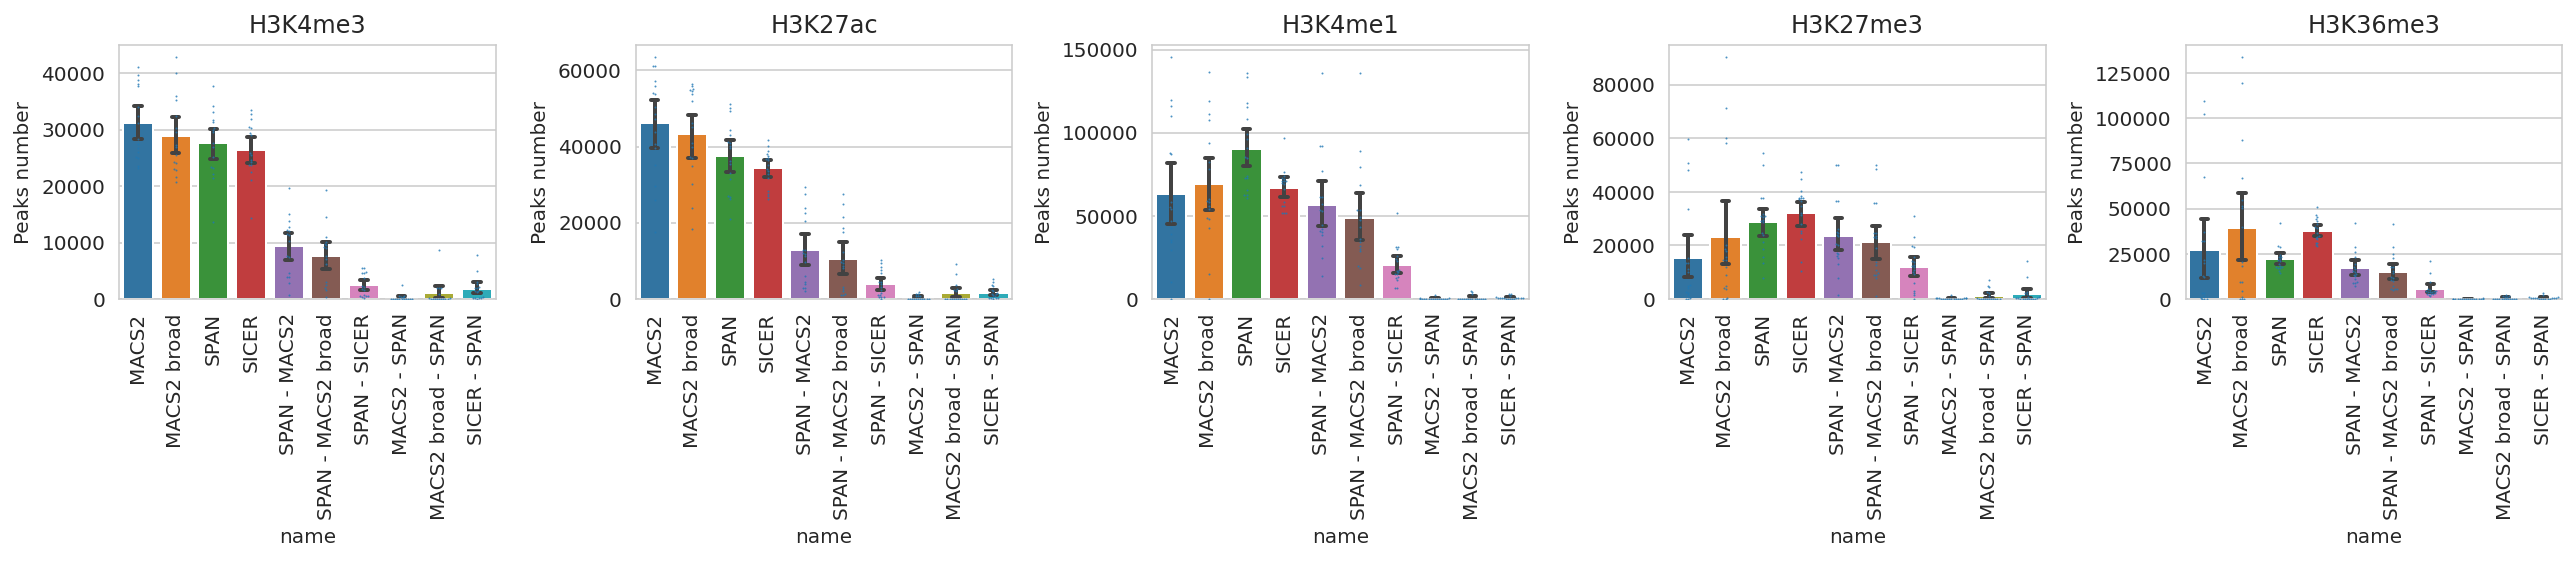

In [625]:
t = df_encode_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_encode_diff]).reset_index(drop=True)

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    print(m)
    ax.title.set_text(m)
    sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',                           
                capsize=.2, errwidth=2,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ],
                ax=ax)
    sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
                  dodge=True, size=1, alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                         ],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

## Roadmap

In [620]:
df_immune_diff = compute_diffs(df_immune_peaks, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_diff.sample(5)

  0%|          | 0/180 [00:00<?, ?it/s]

H3K4me3 CD4ABT rep1
H3K4me3 CD4ABT rep2
H3K4me3 CD4ABT rep3
H3K4me3 CD4ABT 
H3K4me3 TCellBB rep1
H3K4me3 TCellBB rep2
H3K4me3 TCellBB rep3
H3K4me3 TCellBB 
H3K4me3 BCell rep1
H3K4me3 BCell rep2
H3K4me3 BCell rep3
H3K4me3 BCell 
H3K4me3 TCell rep1
H3K4me3 TCell rep2
H3K4me3 TCell rep3
H3K4me3 TCell 
H3K4me3 Monocyte rep1
H3K4me3 Monocyte rep2
H3K4me3 Monocyte rep3
H3K4me3 Monocyte 
H3K4me3 PBMC rep1
H3K4me3 PBMC rep2
H3K4me3 PBMC rep3
H3K4me3 PBMC 
H3K4me3 NK rep1
H3K4me3 NK rep2
H3K4me3 NK rep3
H3K4me3 NK 
H3K4me3 CD34 rep1
H3K4me3 CD34 rep2
H3K4me3 CD34 rep3
H3K4me3 CD34 
H3K4me3 CD4 rep1
H3K4me3 CD4 rep2
H3K4me3 CD4 rep3
H3K4me3 CD4 
H3K27ac CD4ABT rep1
H3K27ac CD4ABT rep2
H3K27ac CD4ABT rep3
H3K27ac CD4ABT 
H3K27ac TCellBB rep1
H3K27ac TCellBB rep2
H3K27ac TCellBB rep3
H3K27ac TCellBB 
H3K27ac BCell rep1
H3K27ac BCell rep2
H3K27ac BCell rep3
H3K27ac BCell 
H3K27ac TCell rep1
H3K27ac TCell rep2
H3K27ac TCell rep3
H3K27ac TCell 
H3K27ac Monocyte rep1
H3K27ac Monocyte rep2
H3K27ac Mono

modification      cell replicate                name  peaks
35       H3K4me3     TCell                  SICER - SPAN     80
14       H3K4me3   TCellBB      rep1  SPAN - MACS2 broad    346
40       H3K4me3  Monocyte                  SPAN - SICER   3010
145      H3K4me1        NK                  MACS2 - SPAN     94
157      H3K4me1      CD34                  MACS2 - SPAN    249

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


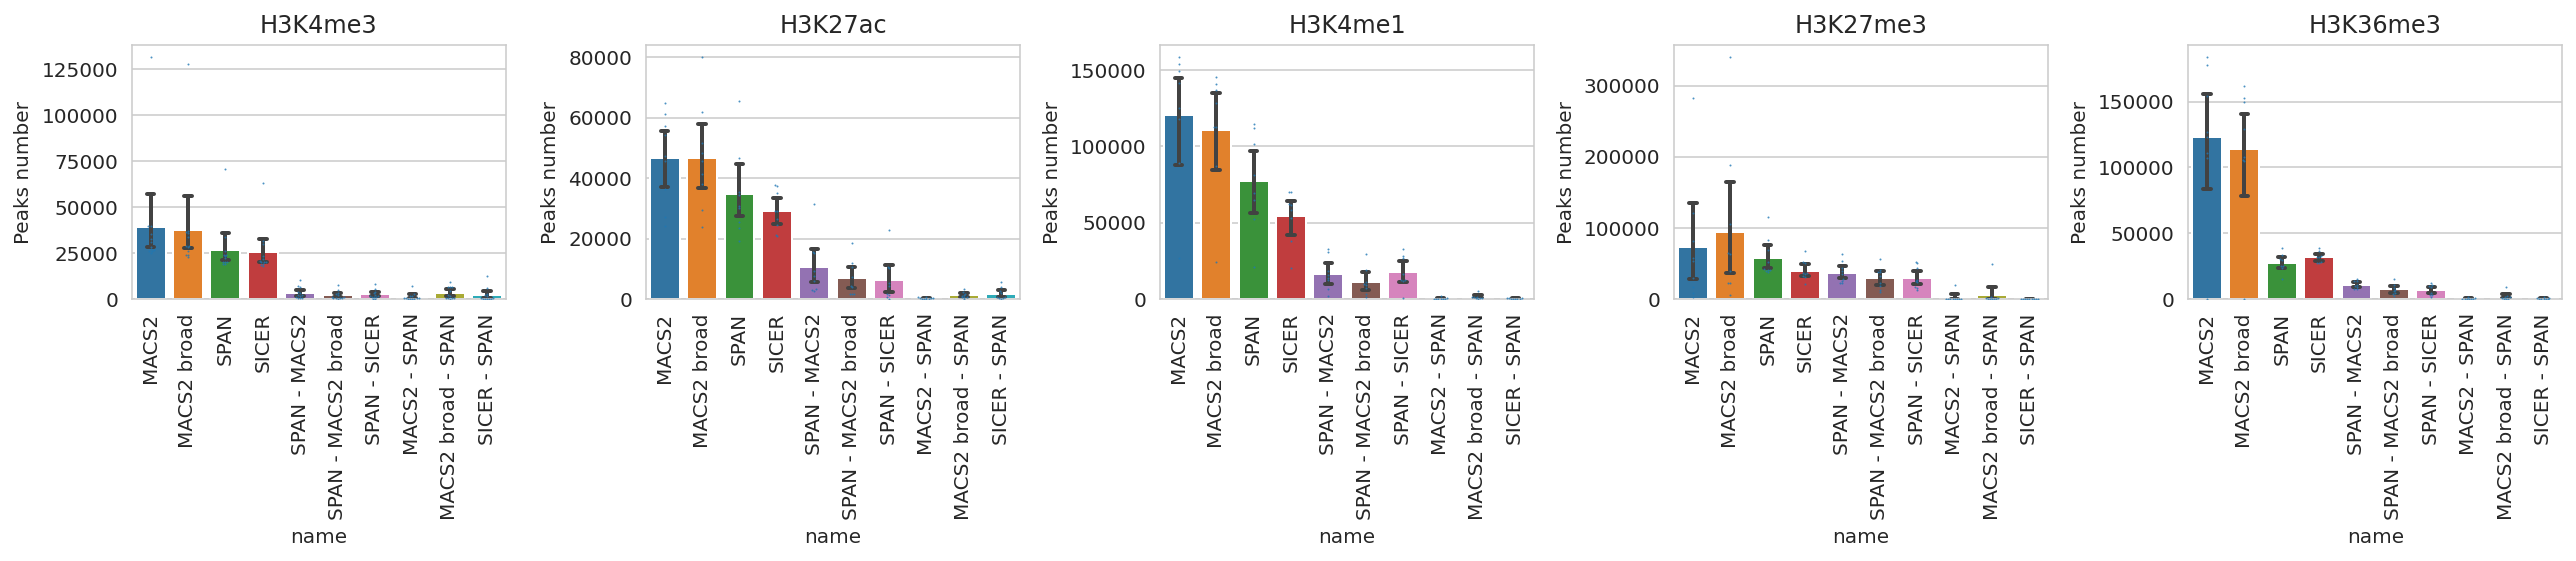

In [624]:
t = df_immune_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_immune_diff]).reset_index(drop=True)

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    ax.title.set_text(m)
    sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',
                capsize=.2, errwidth=2,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ],
                ax=ax)
    sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
                  dodge=True, size=1, alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                         ],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

# Jaccard & Overlap

In [593]:
def compute_reps_overlap(df_peaks, modifications, cells):
    reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    tf = tempfile.mktemp()

    tools = list(sorted(set(df_peaks['tool'])))
    for m, c in tqdm(product(modifications, cells)):
        print(m, c)
        tm = df_peaks[(df_peaks['modification'] == m) & (df_peaks['cell'] == c)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    file1 = sorted_file(t1['file'].values[0])
                    file2 = sorted_file(t2['file'].values[0])
                    peaks1 = t1['peaks'].values[0]
                    peaks1_len = int(bedl(file1).sum())
                    peaks2 = t2['peaks'].values[0]
                    peaks2_len = int(bedl(file2).sum())
                    !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                    overlap1 = lines(tf)
                    !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                    overlap2 = lines(tf)
                    !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                    overlap_len = int(last_col(tf).sum())

                    reps_overlap.loc[len(reps_overlap)] = \
                        (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                        overlap1, overlap2, overlap_len)
    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]                    
    return reps_overlap

## Jaccard ENCODE 

In [594]:
t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS 
                         for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_encode_peaks
df_encode_reps = compute_reps_overlap(t, MODIFICATIONS, GSE26320_CELLS)
df_encode_reps.sample(5)

0it [00:00, ?it/s]

H3K4me3 GM12878
H3K4me3 HMEC
H3K4me3 HSMM
H3K4me3 K562
H3K4me3 NHEK
H3K4me3 NHLF
H3K4me3 H1
H3K4me3 Huvec
H3K4me3 HepG2
H3K27ac GM12878
H3K27ac HMEC
H3K27ac HSMM
H3K27ac K562
H3K27ac NHEK
H3K27ac NHLF
H3K27ac H1
H3K27ac Huvec
H3K27ac HepG2
H3K4me1 GM12878
H3K4me1 HMEC
H3K4me1 HSMM
H3K4me1 K562
H3K4me1 NHEK
H3K4me1 NHLF
H3K4me1 H1
H3K4me1 Huvec
H3K4me1 HepG2
H3K27me3 GM12878
H3K27me3 HMEC
H3K27me3 HSMM
H3K27me3 K562
H3K27me3 NHEK
H3K27me3 NHLF
H3K27me3 H1
H3K27me3 Huvec
H3K27me3 HepG2
H3K36me3 GM12878
H3K36me3 HMEC
H3K36me3 HSMM
H3K36me3 K562
H3K36me3 NHEK
H3K36me3 NHLF
H3K36me3 H1
H3K36me3 Huvec
H3K36me3 HepG2


modification     cell         tool  rep1  rep2  peaks1  peaks1_len  \
27       H3K4me3    Huvec         SPAN  rep1  rep2   23359    37686891   
9        H3K4me3     HSMM  MACS2 broad  rep1  rep2   25487    31098508   
56       H3K27ac    HepG2        MACS2  rep1  rep2   48652    40342410   
128     H3K36me3  GM12878        MACS2  rep1  rep2    1741      667402   
109     H3K27me3     NHEK  MACS2 broad  rep1  rep2   71383    54519904   

     peaks2  peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len  \
27    25062    40705509           18583           18675           30059169   
9     24064    27790033           18935           19947           24207556   
56    26021    16705467           19539           25604           16240162   
128   19751     8554488             705             723             192514   
109   58290    37525393           24943           28071           20753507   

      jaccard  
27   0.621915  
9    0.698007  
56   0.397968  
128  0.021321  
109  0.291107

ENCODE


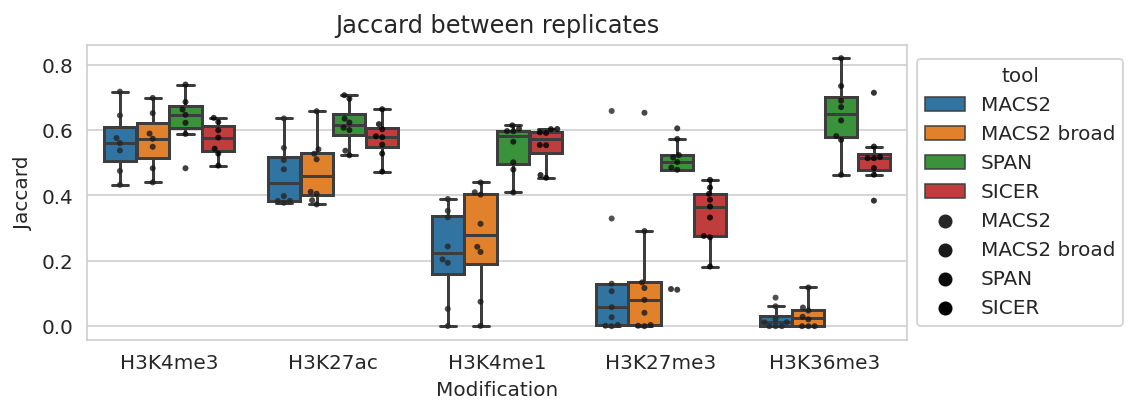

In [629]:
print('ENCODE')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


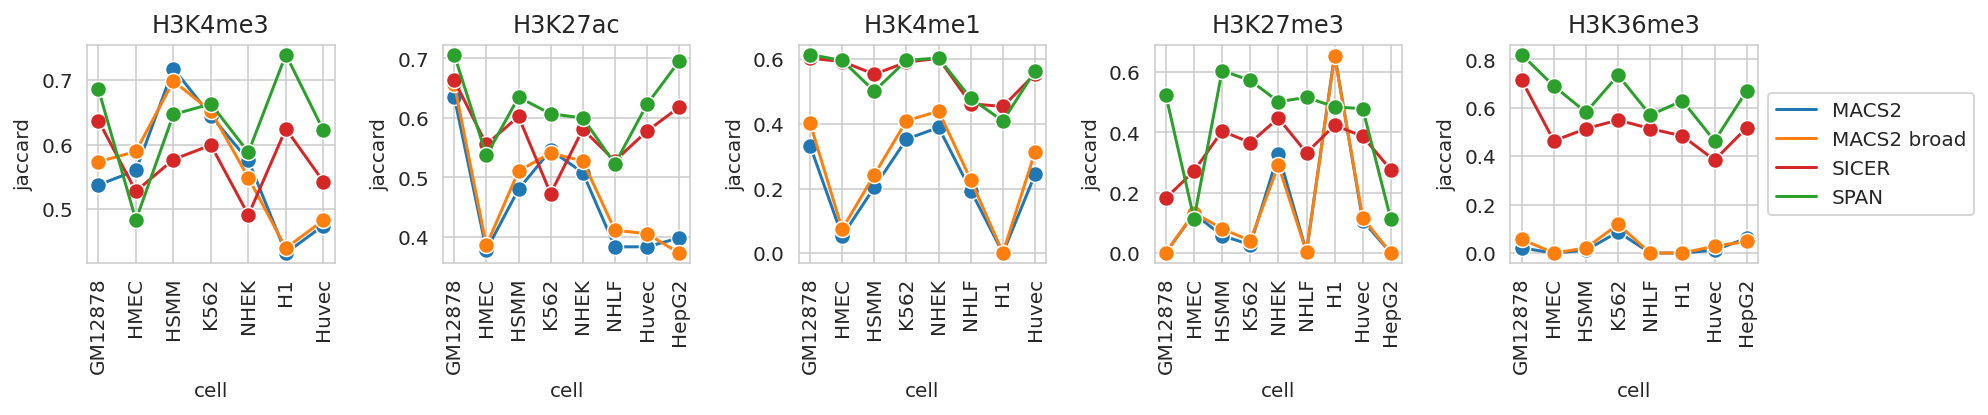

In [596]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

ENCODE


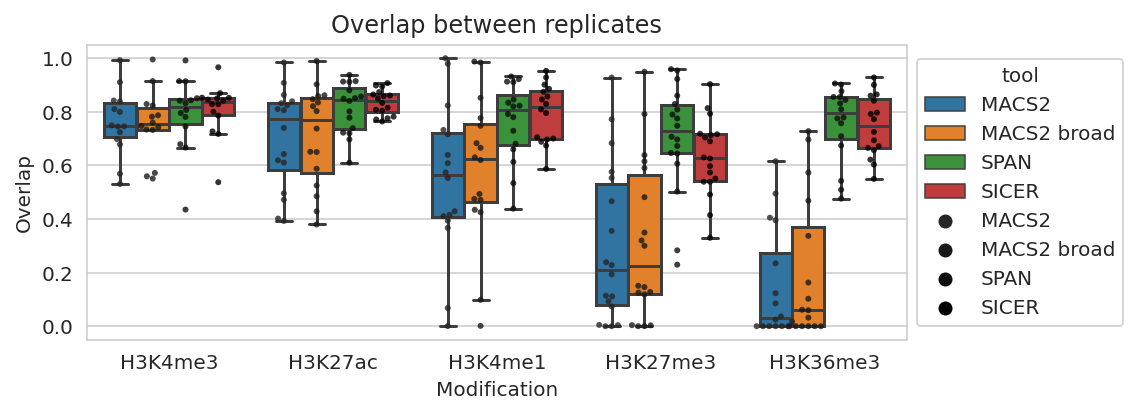

In [630]:
t = pd.concat([df_encode_reps[['modification', 'cell', 'tool']], 
               df_encode_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_encode_reps['peaks1_overlap'], df_encode_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_encode_reps['peaks2_overlap'], df_encode_reps['peaks2'])]
t['overlap'] = overlaps
print('ENCODE')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False
            )
sns.swarmplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE
H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


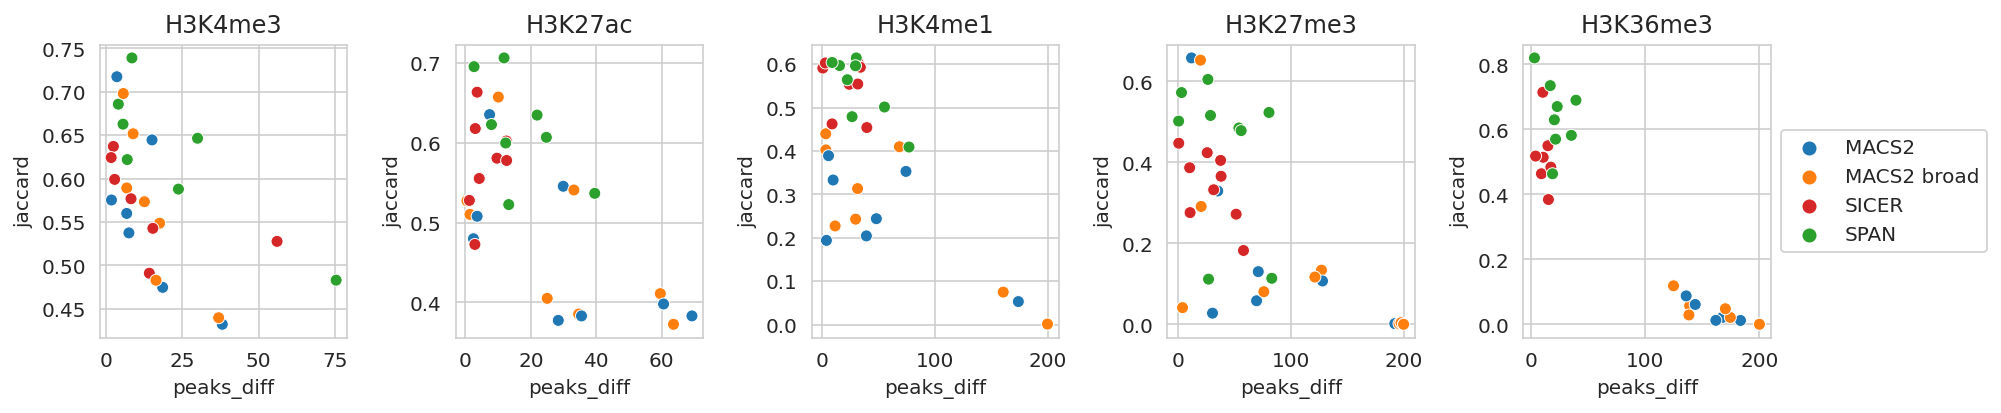

In [598]:
print('ENCODE')
df_encode_reps['peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                       (df_encode_reps['peaks1'] + df_encode_reps['peaks2']) * 200)
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='peaks_diff', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [599]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_encode_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_encode = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

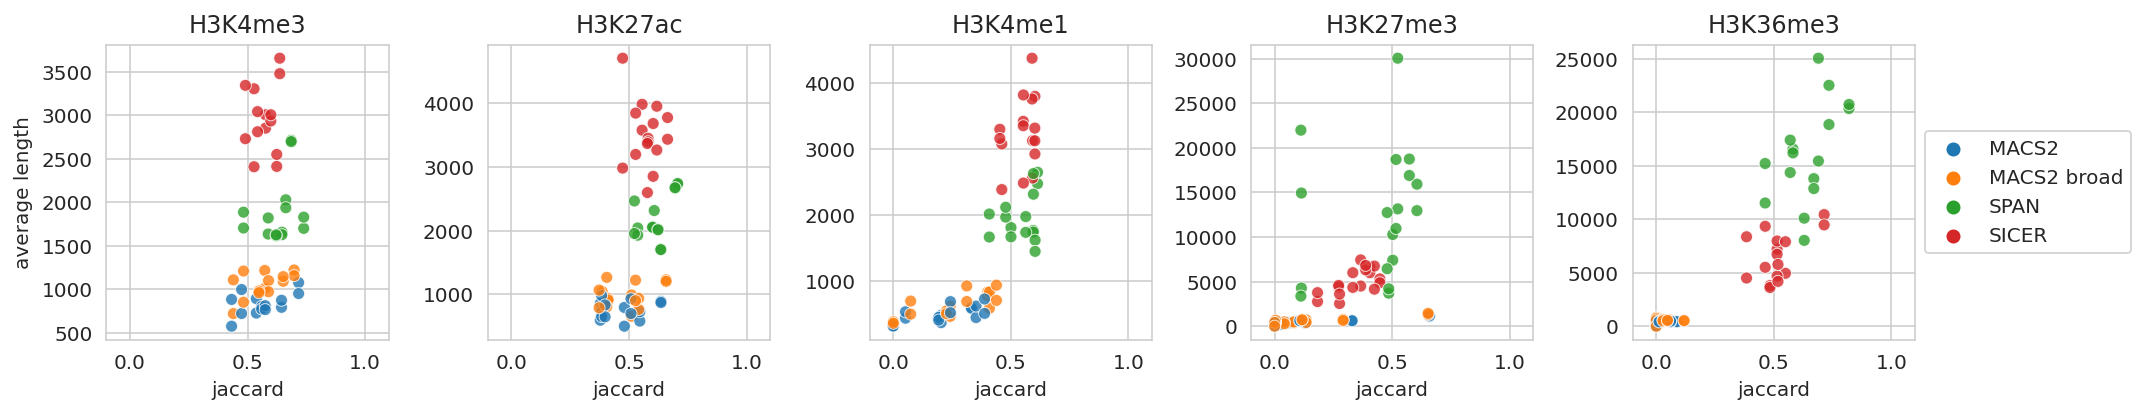

In [600]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K27ac


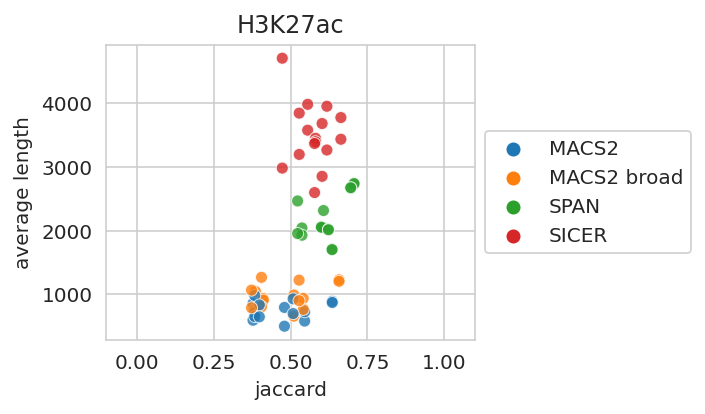

H3K4me1


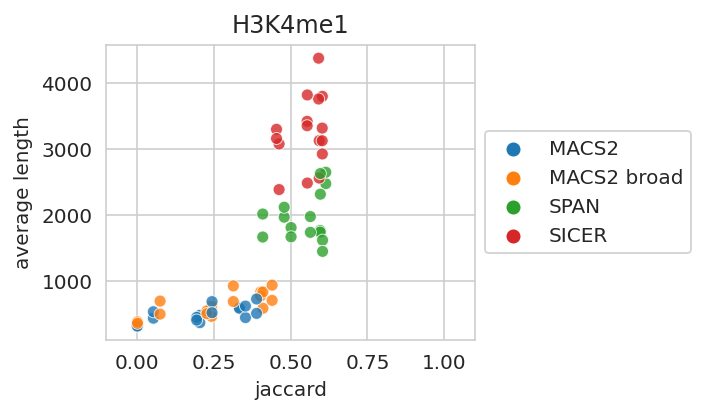

In [601]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    ax.set_ylabel('average length')
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

## Jaccard Roadmap

In [602]:
t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS 
                         for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_immune_peaks
df_immune_reps = compute_reps_overlap(t, MODIFICATIONS, IMMUNE_CELLS)
df_immune_reps.sample(5)

0it [00:00, ?it/s]

H3K4me3 CD4ABT
H3K4me3 TCellBB
H3K4me3 BCell
H3K4me3 TCell
H3K4me3 Monocyte
H3K4me3 PBMC
H3K4me3 NK
H3K4me3 CD34
H3K4me3 CD4
H3K27ac CD4ABT
H3K27ac TCellBB
H3K27ac BCell
H3K27ac TCell
H3K27ac Monocyte
H3K27ac PBMC
H3K27ac NK
H3K27ac CD34
H3K27ac CD4
H3K4me1 CD4ABT
H3K4me1 TCellBB
H3K4me1 BCell
H3K4me1 TCell
H3K4me1 Monocyte
H3K4me1 PBMC
H3K4me1 NK
H3K4me1 CD34
H3K4me1 CD4
H3K27me3 CD4ABT
H3K27me3 TCellBB
H3K27me3 BCell
H3K27me3 TCell
H3K27me3 Monocyte
H3K27me3 PBMC
H3K27me3 NK
H3K27me3 CD34
H3K27me3 CD4
H3K36me3 CD4ABT
H3K36me3 TCellBB
H3K36me3 BCell
H3K36me3 TCell
H3K36me3 Monocyte
H3K36me3 PBMC
H3K36me3 NK
H3K36me3 CD34
H3K36me3 CD4


modification     cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
8       H3K4me3     CD34        MACS2        rep2   39952    29326644   27221   
4       H3K4me3  TCellBB        MACS2  rep1  rep2   39930    26147373   35225   
2       H3K4me3   CD4ABT        SICER  rep1  rep2   19145    62402255   23270   
12      H3K27ac     CD34        MACS2        rep2   64970    49974826   27004   
37     H3K36me3     CD34  MACS2 broad        rep1  129062   243757196  149592   

    peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
8     24341167           27566           24847           21768624  0.682419  
4     31412710           31246           25818           21775570  0.608519  
2     74854330           18546           18433           51456751  0.599730  
12    17488610           19041           24400           16233325  0.316871  
37    80894791           49302          139736           77113635  0.311522

Immune


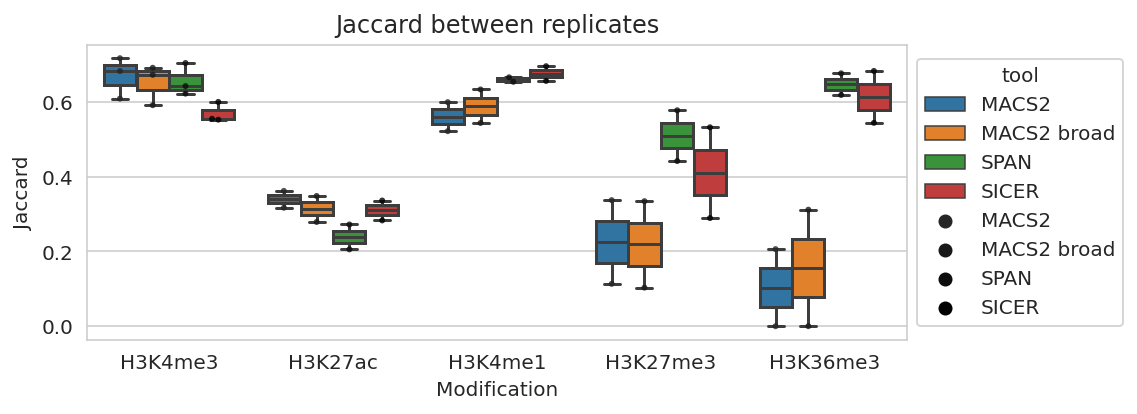

In [631]:
print('Immune')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


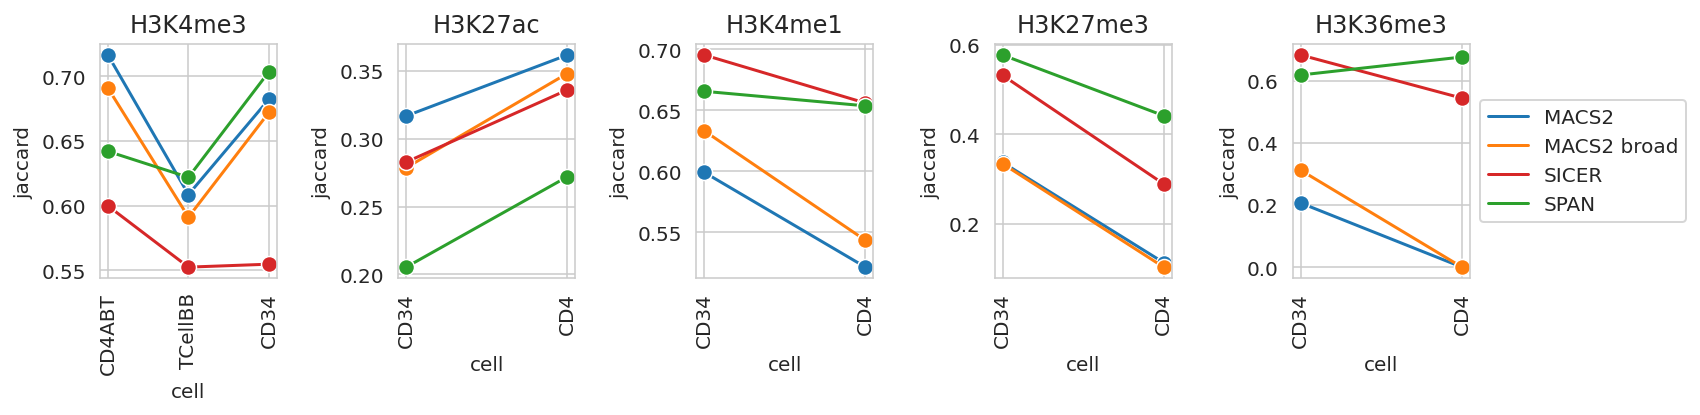

In [632]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

Immune


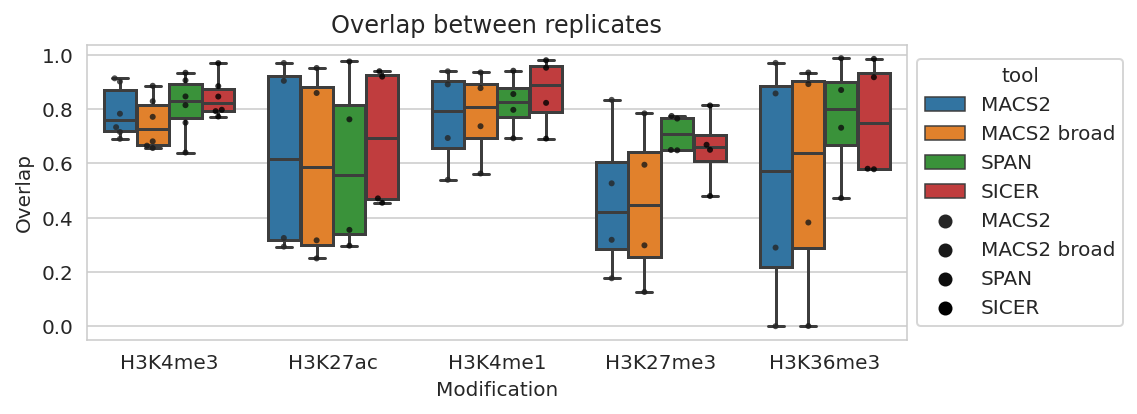

In [633]:
print('Immune')
t = pd.concat([df_immune_reps[['modification', 'cell', 'tool']],
               df_immune_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_immune_reps['peaks1_overlap'], df_immune_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_immune_reps['peaks2_overlap'], df_immune_reps['peaks2'])]
t['overlap'] = overlaps
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


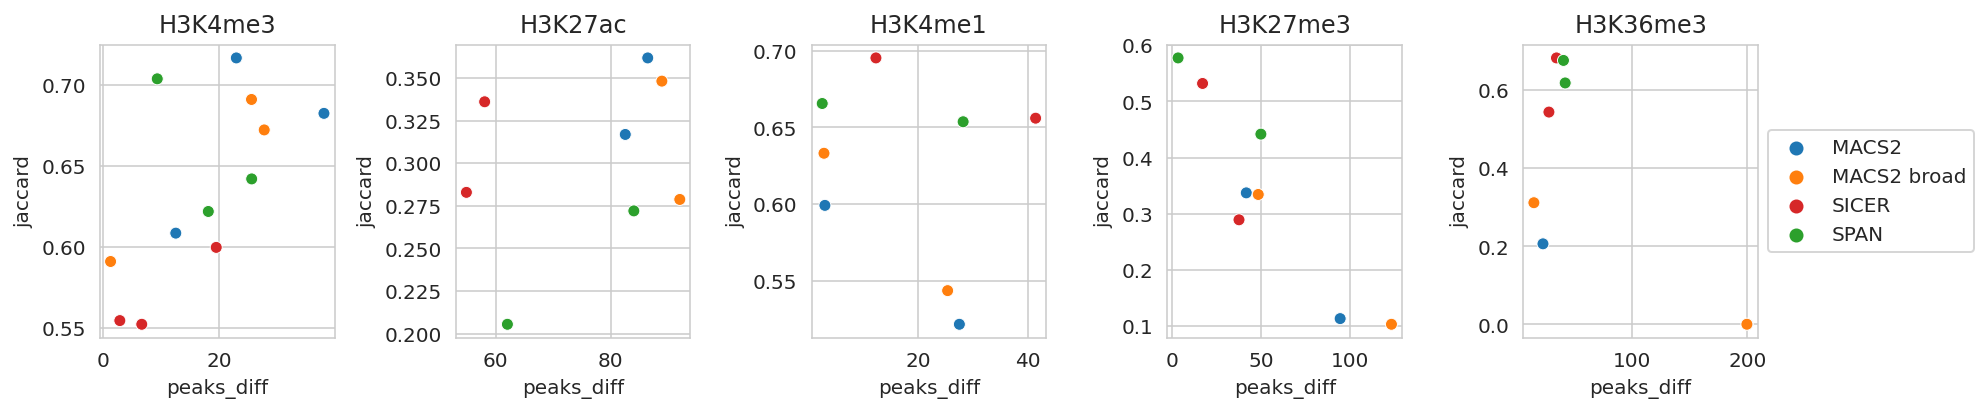

In [606]:
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) / 
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']) * 200)

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [607]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_immune_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_immune = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

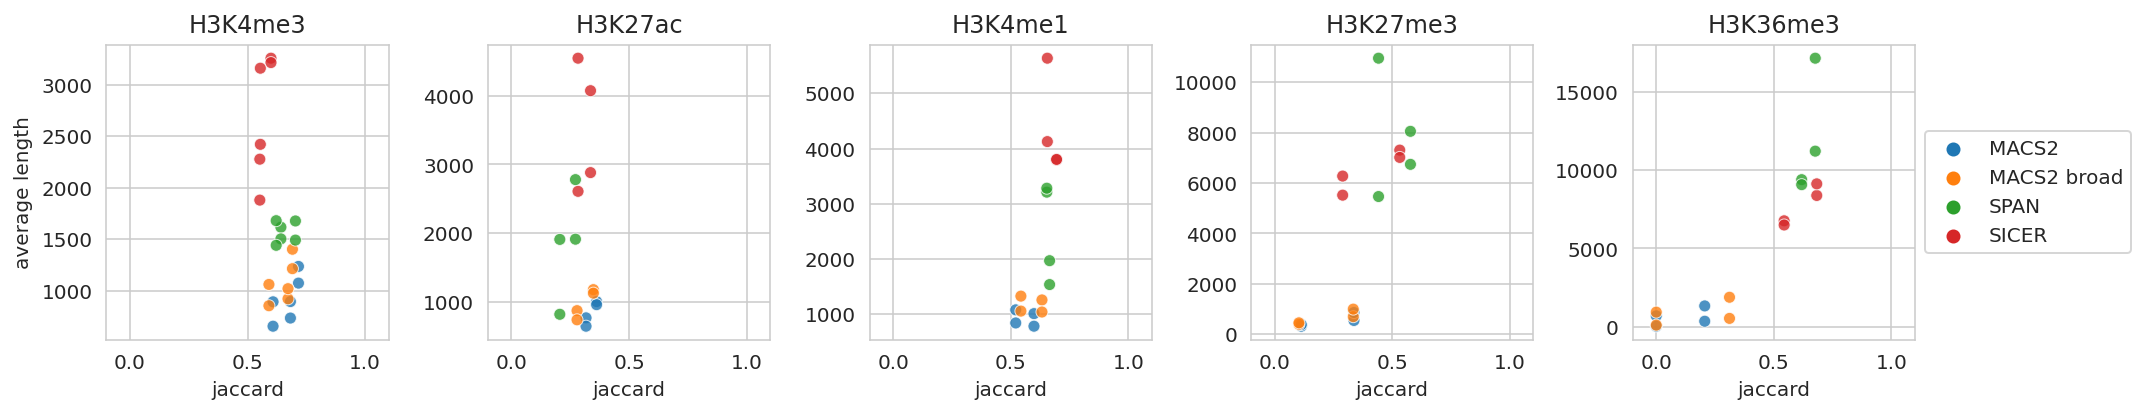

In [608]:

plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_immune[df_jaccard_avg_len_immune['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
    #     Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [609]:
STOP

NameError: name 'STOP' is not defined

# IDR

In [ ]:
def compute_reps_idr(df_peaks, modifications, cells):
    reps_idr = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2', 'peaks1', 'peaks2', 
                                     'idr_loaded_peaks1', 'idr_loaded_peaks2', 'idr_peaks', 'idr_loaded_peaks', 'idr_percentage'
                                     ], dtype=object)

    tf = tempfile.mktemp()
    tf1 = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    tools = list(sorted(set(df_peaks['tool'])))
    for m, c in tqdm(list(product(modifications, cells))):
        print(m, c)
        tm = df_peaks[(df_peaks['modification'] == m) & (df_peaks['cell'] == c)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    try:
                        file1 = t1['file'].values[0]
                        file2 = t2['file'].values[0]
                        print(tool, file1, file2)
                        peaks1 = t1['peaks'].values[0]
                        peaks2 = t2['peaks'].values[0]
                        # Process SICER peaks, add missing 8th column, as -log10 qvalue
                        if tool == 'SICER':
                            sf1 = pd.read_csv(file1, sep='\t', header=None)
                            sf1[8] = -np.log10(sf1[7])
                            sf1.to_csv(tf1, sep='\t', index=None, header=False)
                            file1 = tf1
                            sf2 = pd.read_csv(file2, sep='\t', header=None)
                            sf2[8] = -np.log10(sf2[7])
                            sf2.to_csv(tf2, sep='\t', index=None, header=False)
                            file2 = tf2
                        ! idr --input-file-type bed --rank 8 --samples {file1} {file2} 2>&1 | tee {tf}
                        with open(tf) as f:
                            idr_out = f.read()
                        # print('IDR OUT', tf, idr_out)
                        lp1, lp2 = re.findall('Number of reported peaks - (\\d+)/(\\d+)', idr_out)[0]
                        lp1, lp2 = int(lp1), int(lp2)
                        ip, ilp, iperc = re.findall('Number of peaks passing IDR cutoff of 0.05 - (\\d+)/(\\d+) \\(([\\d\\.]+)', idr_out)[0]
                        ip, ilp, iperc = int(ip), int(ilp), float(iperc)
                        print(m, c, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                        reps_idr.loc[len(reps_idr)] = \
                            (m, c, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                    except Exception as e:
                        # raise e
                        # print(e)
                        pass  # Ignore errors for now
    return reps_idr

## IDR ENCODE

In [ ]:
# t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
t = df_encode_peaks
df_encode_idr_reps = compute_reps_idr(t, MODIFICATIONS, GSE26320_CELLS)
df_encode_idr_reps.sample(5)

In [ ]:
print('ENCODE')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_percentage',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_loaded_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
for m in MODIFICATIONS:
    plt.figure(figsize=(6, 2))
    g_result = sns.boxplot(data=df_encode_idr_reps[df_encode_idr_reps['modification'] == m], 
                           x='idr_peaks', y = 'tool',
                           palette=TOOLS_PALETTE,
                           order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                           )
    ax = g_result.axes
    ax.set_title(f'IDR between {m} replicates')
    ax.set_ylabel('Tool')
    ax.set_xlabel('IDR peaks')
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(10, 2))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_encode_idr_reps[df_encode_idr_reps['modification'] == m]
    g_results = sns.scatterplot(data=t,
                                x='idr_peaks', y='idr_percentage',
                                hue='tool',
                                palette=TOOLS_PALETTE,
                                alpha=0.8,
                                ax=ax,
                                )
    for x, y, cell in zip(t['idr_peaks'], t['idr_percentage'], t['cell']):
        ax.text(x, y, cell, fontsize = 4)
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

## IDR Roadmap

In [ ]:
# t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
t = df_immune_peaks
df_immune_idr_reps = compute_reps_idr(t, MODIFICATIONS, IMMUNE_CELLS)
df_immune_idr_reps.sample(5)

In [ ]:
print('Immune')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_percentage',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
print('Immune')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_loaded_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
for m in MODIFICATIONS:
    plt.figure(figsize=(6, 2))
    g_result = sns.boxplot(data=df_immune_idr_reps[df_immune_idr_reps['modification'] == m],
                           x='idr_peaks', y = 'tool',
                           palette=TOOLS_PALETTE,
                           order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                           )
    ax = g_result.axes
    ax.set_title(f'IDR between {m} replicates')
    ax.set_ylabel('Tool')
    ax.set_xlabel('IDR peaks')
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(10, 2))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_immune_idr_reps[df_immune_idr_reps['modification'] == m]
    g_results = sns.scatterplot(data=t,
                    x='idr_peaks', y='idr_percentage',
                    hue='tool',
                    palette=TOOLS_PALETTE,
                    alpha=0.8,
                    ax=ax,
                    )
    for x, y, cell in zip(t['idr_peaks'], t['idr_percentage'], t['cell']):
        ax.text(x, y, cell, fontsize = 4)    
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()